In [1]:
import pandas as pd
import numpy as np
import random
import csv
from prettytable import PrettyTable
from pylab import *
from scipy.stats import wasserstein_distance
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
###Change the data file directory below appropriately
data = pd.read_csv('../raw_data/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv')
#data = pd.read_csv('../aggregated_data/aggregated_data.csv')
data.head()

timestamp  raw_acc:magnitude_stats:mean  raw_acc:magnitude_stats:std  \
0  1449601597                      1.000371                     0.007671   
1  1449601657                      1.000243                     0.003782   
2  1449601717                      1.000811                     0.002082   
3  1449601777                      1.001245                     0.004715   
4  1449601855                      1.001354                     0.065186   

   raw_acc:magnitude_stats:moment3  raw_acc:magnitude_stats:moment4  \
0                        -0.016173                         0.027860   
1                        -0.002713                         0.007046   
2                        -0.001922                         0.003575   
3                        -0.002895                         0.008881   
4                        -0.096520                         0.165298   

   raw_acc:magnitude_stats:percentile25  raw_acc:magnitude_stats:percentile50  \
0                              0.998221                              1.000739   
1                              0.998463                              1.000373   
2                              0.999653                              1.000928   
3                              0.999188                              1.001425   
4                              1.000807                              1.002259   

   raw_acc:magnitude_stats:percentile75  \
0                              1.003265   
1                              1.002088   
2                              1.002032   
3                              1.003500   
4                              1.003631   

   raw_acc:magnitude_stats:value_entropy  \
0                               0.891038   
1                               1.647929   
2                               1.960286   
3                               1.614524   
4                               0.837790   

   raw_acc:magnitude_stats:time_entropy  ...  label:STAIRS_-_GOING_DOWN  \
0                              6.684582  ...                        NaN   
1                              6.684605  ...                        NaN   
2                              6.684610  ...                        NaN   
3                              6.684601  ...                        NaN   
4                              6.682252  ...                        0.0   

   label:ELEVATOR  label:OR_standing  label:AT_SCHOOL  label:PHONE_IN_HAND  \
0             NaN                NaN              NaN                  NaN   
1             NaN                NaN              NaN                  NaN   
2             NaN                NaN              NaN                  NaN   
3             NaN                NaN              NaN                  NaN   
4             NaN                0.0              1.0                  NaN   

   label:PHONE_IN_BAG  label:PHONE_ON_TABLE  label:WITH_CO-WORKERS  \
0                 NaN                   NaN                    NaN   
1                 NaN                   NaN                    NaN   
2                 NaN                   NaN                    NaN   
3                 NaN                   NaN                    NaN   
4                 NaN                   NaN                    NaN   

   label:WITH_FRIENDS  label_source  
0                 NaN            -1  
1                 NaN            -1  
2                 NaN            -1  
3                 NaN            -1  
4                 0.0             2  

[5 rows x 278 columns]

# Interpolating columns with average values

In [3]:
def interpolation(df):
    col_to_avg = list(df.columns) #Start with keeping all the columns as columns to use an average interpolation on
    for k in range(len(list(df.columns))):
        if list(df.columns)[k].startswith(('discrete', 'label')): #Remove label and discrete columns from col_to_avg
            col_to_avg.remove(list(df.columns)[k])
    
    df_with_avg = df[col_to_avg].fillna(df[col_to_avg].mean()) #Interpolate nan columns for all continuous-valued columns with average
    
    col_to_zero = list(df.columns)
    for k in range(len(list(df.columns))):
        if not list(df.columns)[k].startswith(('discrete', 'label')): #Remove all columns except label and discrete
            col_to_zero.remove(list(df.columns)[k])
    
    df_with_zero = df[col_to_zero].fillna(0) #Interpolate nan values for label and discrete columns with 0
    
    return pd.concat([df_with_avg, df_with_zero], axis = 1)

# Splitting the data and loading it into a PyTorch dataloader

In [4]:
X = data.iloc[:,1:27]
y = data[['label:SITTING']]

X = X[y['label:SITTING'] == 1]
y = y[y['label:SITTING'] == 1]

X = interpolation(X).values
y = interpolation(y).values

print(len(X), len(y))

2253 2253


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
#X

# Helper Functions for Training

In [6]:
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim)

class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = 26, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
             generator_block(z_dim, 80),
            generator_block(80, 60),
            generator_block(60, 40),
            generator_block(40, 28),
            nn.Linear(28, feature_dim)
        )
    def forward(self, noise):
        return self.gen(noise)

def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class Discriminator(nn.Module):
    def __init__(self, feature_dim = 26, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, hidden_dim),
            discriminator_block(hidden_dim, int(hidden_dim/2)),
            discriminator_block(int(hidden_dim/2), int(hidden_dim/4)),
            nn.Linear(int(hidden_dim/4), 1),
            nn.Sigmoid()                    
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)

def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred_fake = disc(fake_features.detach())
    
    ground_truth = torch.zeros_like(pred_fake)
    loss_fake = criterion(pred_fake, ground_truth)
    
    pred_real = disc(real_features)
    ground_truth = torch.ones_like(pred_real)
    loss_real = criterion(pred_real, ground_truth)
    
    disc_loss = (loss_fake + loss_real) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred = disc(fake_features)
    gen_loss = criterion(pred, torch.ones_like(pred))
    return gen_loss

def visualize_gen_batch(gen, b_size, epochs = -1):
    #print(str(b_size))
    latent_vectors = get_noise(b_size, z_dim)
    #print(latent_vectors.shape)
    fake_features = gen(latent_vectors)
    #print(fake_features.shape)
    
    w_img = fake_features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Generated Batch at Epoch ' + str(epochs), fontweight ="bold")
    plt.show()
    
def visualize_real_batch(features):
    w_img = features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Real Batch of Data', fontweight ="bold")
    plt.show()
    
def performance_stats(gen, disc, b_size, batch = None):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    with torch.no_grad():
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * b_size
            y_label = torch.Tensor(y_label)
        else:
            latent_vectors = get_noise(int(b_size/2), z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * int(b_size/2)
            
            real_y_hat = torch.round(disc(batch[:int(b_size/2)]))
            for i in range(0, int(b_size/2)):
                y_label.append(1)
            y_hat = torch.cat((y_hat, real_y_hat), dim = 0)
            
            #print(y_hat)
            #print(y_label)
         
        
        for k in range(len(y_hat)):
            #True positive
            if y_label[k] == 1 and y_hat[k] == 1:
                tp += 1
            #False Negative
            elif y_label[k] == 1 and y_hat[k] == 0:
                fn += 1
            #True Negative
            elif y_label[k] == 0 and y_hat[k] == 0:
                tn += 1
            elif y_label[k] == 0 and y_hat[k] == 1:
                fp += 1
            else:
                print("Error")
                exit()
            
        class_acc = (tp + tn)/(tp + tn + fp + fn)
        
        if tp + fp == 0:
            precision = 0
        else:
            precision = tp / (tp + fp)
            
        if tp + fn == 0:
            recall = 0
        else:
            recall = tp / (tp + fn)
            
        if fp + tn == 0:
            fpR = 0
        else: 
            fpR = fp / (fp + tn)

        #print(f'Classification Accuracy: {class_acc:.2f}')
        #print(f'Precision: {precision:.2f}') #What percentage of a model's positive predictions were actually positive
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        #print(f'F-1 Score: {2*(precision * recall / (precision + recall + 0.001)):.2f}')
        return class_acc, precision, recall, fpR, 2*(precision * recall / (precision + recall + 0.0001))
    
    
def density_curves(reals, fakes):
    plt.figure(figsize = (15, 15))
    subplot(2, 2, 1)
    sns.kdeplot(fakes.numpy()[:,0], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,0], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 2)
    sns.kdeplot(fakes.numpy()[:,18], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,18], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean X-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 3)
    sns.kdeplot(fakes.numpy()[:,19], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,19], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Y-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 4)
    sns.kdeplot(fakes.numpy()[:,20], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,20], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Z-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    fake_features = gen(latent_vectors)
    
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim

def all_Wasserstein_dists(gen, z_dim, feature_dim, sample):
    wasser_dim = []
    latent_vectors = get_noise(len(sample), z_dim)
    fake_features = gen(latent_vectors)
    for k in range(feature_dim):
        wasser_dim.append(wasserstein_distance(fake_features[:, k].detach().numpy(), sample[:, k].detach().numpy()))
    return torch.tensor(wasser_dim)

# Model Hyperparameters (Always Run Again Before Starting Training Loop) 

In [7]:
# Loss function for model
criterion = nn.BCELoss()

#GAN Name (used for saving model and its output)
gan_id = "20k_5_2_dynamic_GAN"

# Digit Precision for printouts
dig = 5

# Max epochs to run
n_epochs = 20000

# Number of dimensions of output from generator
feature_dim = 26

# Number of dimensions of latent vector
z_dim = 100

# Batch Size
batch_size = 100

# Learning Rates for Generator (Gen) and Discriminator (Disc)
gen_lr =  0.0001
disc_lr = 0.0001

# Constant epochs approach to train Discriminator, Generator
constant_train_flag = False # Set to true to train based on constant # of epochs per machine 
                            # Set to false to train dynamically based on machine performance
disc_epochs = 5             # Number of consecutive epochs to train discriminator before epoch threshold
gen_epochs = 2              # Number of consecutive epochs to train generator before epoch threshold
epoch_threshold = 50        # Epoch number to change training epoch ratio
disc_epochs_change = 5      # New number of consecutive epochs to train discriminator
gen_epochs_change = 2      # New number of consecutive epochs to train generator
rel_epochs = 0              # Epochs passed since last switch (always set to 0)


# Dynamic number of epochs to train Discriminator, Generator
static_threshold = 77   # Epoch number to change from static ratio to dynamic
static_disc_epochs = 5  # Number of consecutive epochs to train discriminator before epoch threshold
static_gen_epochs = 2   # Number of consecutive epochs to train generator before epoch threshold
pull_threshold = 0.2    # Accuracy threshold for switching machine training when the generator is no longer competitive
push_threshold = 0.8    # Accuracy threshold for switching machine training when the discriminator is no longer competitive
recall_threshold = 0.80

# Which machine to train (0 for Generator, 1 for Discriminator) !!!(do not change unless for good reason)!!!
GENERATOR = 0
DISCRIMINATOR = 1
to_train = DISCRIMINATOR
train_string = "DISC"

# Show model performance per batch (will always show summary for each epoch)
print_batches = False

# Moving corpus data into a pyTorch format !!!(do not change unless for good reason)!!!
train_features = torch.tensor(X)
train_labels = torch.tensor(y)
train_data = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

# Initializiing the Machines !!!(do not change unless for good reason)!!!
disc = Discriminator()
gen = Generator(z_dim)
gen.load_state_dict(torch.load('../saved_models/20k_5_2_constant_gan'))
disc.load_state_dict(torch.load("../saved_models/20k_5_2_constant_disc"))

opt_disc = optim.Adam(disc.parameters(), lr = disc_lr)
opt_gen = optim.Adam(gen.parameters(), lr = gen_lr)

# Training Loop

In [ ]:
#For saving prettyTable.txt file
heading = ["Epoch", "Machine Training", "Discriminator Loss", "Generator Loss", "FPR", "Recall", "Median Wasserstein", "Mean Wasserstein"]
table = PrettyTable()
table.field_names = heading

#For saving .csv file
rows = []
gen_epochs = 0

last_real_features = []
switch_flag = False
switch_count = 0

for epoch in range(n_epochs):  
    if constant_train_flag:
        if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GEN"

        elif to_train == GENERATOR and rel_epochs >= gen_epochs:
            rel_epochs = 0
            to_train = DISCRIMINATOR
            train_string = "DISC"
        
        # Change epoch ratio after intial 'leveling out'
        if epoch == epoch_threshold:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GENERATOR"

            old_ratio = gen_epochs / disc_epochs
            gen_epochs = gen_epochs_change
            disc_epochs = disc_epochs_change
            new_ratio = gen_epochs / disc_epochs
            print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
    else:
        if epoch < static_threshold:
            if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

            elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"
        
        else:
            if not switch_flag:
                print("\nSwitching to Dynamic Training\n")
                switch_flag = True
                to_train = DISCRIMINATOR
                train_string = "DISC"
            if to_train == DISCRIMINATOR and fpR <= pull_threshold and R >= recall_threshold:
                to_train = GENERATOR
                train_string = "GEN"
                print("\nPull Generator\n")
                switch_count += 1
            if to_train == GENERATOR and fpR >= push_threshold:
                to_train = DISCRIMINATOR
                train_string = "DISC"
                print("\nPush Generator\n")
                switch_count += 1

    print(f'Epoch [{epoch + 1}/{n_epochs}] Training: {train_string} ', end ='')
    for batch_idx, (real_features, _) in enumerate(train_loader):
        #batch_size = len(real_features)
    
        if print_batches:
                print(f'\n\tBatch [{batch_idx + 1} / {len(train_loader)}] |', end ='')
    
        if to_train == DISCRIMINATOR:
            ### Training Discriminator
            #visualize_real_batch(real_features.float())
            opt_disc.zero_grad()
            disc_loss = get_disc_loss(gen, disc, criterion, real_features.float(), len(real_features), z_dim)
            disc_loss.backward(retain_graph = True)
            opt_disc.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, len(real_features), batch = real_features.float())
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
        else:
            ### Training Generator
            opt_gen.zero_grad()
            gen_loss = get_gen_loss(gen, disc, criterion, len(real_features), z_dim)
            gen_loss.backward()
            opt_gen.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, len(real_features), batch = real_features.float())
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            gen_epochs += 1
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
        
    if not print_batches:
        if to_train == DISCRIMINATOR:
            ### Currently doesn't print Median/Mean Wasserstein --> Change if needed
            print(f'| Loss D: {disc_loss.item():.{dig}f}, Loss G: {get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Discriminator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
        else:
            print(f'| Loss D: {get_disc_loss(gen, disc, criterion, real_features.float(), len(real_features), z_dim):.{dig}f}, Loss G: {gen_loss.item():.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Generator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
    rel_epochs += 1
    
    if mean_w_dist <= 0.1:
        break

    
print("\n\nTraining Session Finished")
print(f"Encountered {switch_count} non-trivial training swaps")
print(f"Generator trained for {gen_epochs} epochs")

f = open("../model_outputs/" + gan_id + ".txt", "w")
f.write(table.get_string())
f.close()
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".txt\"")

with open("../model_outputs/" + gan_id + ".csv", "w") as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(heading)
    # writing the data rows 
    csvwriter.writerows(rows)
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".csv\"")

Epoch [1/20000] Training: DISC | Loss D: 0.73819, Loss G: 0.98490 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.49132
Epoch [2/20000] Training: DISC | Loss D: 0.72842, Loss G: 0.97648 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.49850
Epoch [3/20000] Training: DISC | Loss D: 0.72603, Loss G: 0.96409 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.48322
Epoch [4/20000] Training: DISC | Loss D: 0.72129, Loss G: 0.97077 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.56546
Epoch [5/20000] Training: DISC | Loss D: 0.72443, Loss G: 0.95469 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.42976
Epoch [6/20000] Training: GEN | Loss D: 0.72058, Loss G: 0.95757 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserst

Epoch [50/20000] Training: DISC | Loss D: 0.68524, Loss G: 0.87093 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.35498
Epoch [51/20000] Training: DISC | Loss D: 0.67805, Loss G: 0.85757 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.31320
Epoch [52/20000] Training: DISC | Loss D: 0.67456, Loss G: 0.87337 | Accuracy: 0.55769 | fpR: 0.00000 | P: 1.00000 | R: 0.11538 | F1: 0.20688 | Mean Wasserstein: 0.44519
Epoch [53/20000] Training: DISC | Loss D: 0.67181, Loss G: 0.85723 | Accuracy: 0.50000 | fpR: 0.03846 | P: 0.50000 | R: 0.03846 | F1: 0.07142 | Mean Wasserstein: 0.42819
Epoch [54/20000] Training: DISC | Loss D: 0.66673, Loss G: 0.89017 | Accuracy: 0.51923 | fpR: 0.00000 | P: 1.00000 | R: 0.03846 | F1: 0.07407 | Mean Wasserstein: 0.43895
Epoch [55/20000] Training: GEN | Loss D: 0.67104, Loss G: 0.84548 | Accuracy: 0.48077 | fpR: 0.03846 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wa

Epoch [146/20000] Training: DISC | Loss D: 0.58676, Loss G: 0.99938 | Accuracy: 0.73077 | fpR: 0.11538 | P: 0.83333 | R: 0.57692 | F1: 0.68177 | Mean Wasserstein: 0.45198
Epoch [147/20000] Training: DISC | Loss D: 0.54980, Loss G: 1.00314 | Accuracy: 0.73077 | fpR: 0.07692 | P: 0.87500 | R: 0.53846 | F1: 0.66662 | Mean Wasserstein: 0.33548
Epoch [148/20000] Training: DISC | Loss D: 0.49677, Loss G: 1.04636 | Accuracy: 0.73077 | fpR: 0.07692 | P: 0.87500 | R: 0.53846 | F1: 0.66662 | Mean Wasserstein: 0.55950
Epoch [149/20000] Training: DISC | Loss D: 0.54294, Loss G: 1.08398 | Accuracy: 0.67308 | fpR: 0.07692 | P: 0.84615 | R: 0.42308 | F1: 0.56406 | Mean Wasserstein: 0.51086
Epoch [150/20000] Training: DISC | Loss D: 0.52186, Loss G: 1.07410 | Accuracy: 0.75000 | fpR: 0.07692 | P: 0.88235 | R: 0.57692 | F1: 0.69763 | Mean Wasserstein: 0.44438
Epoch [151/20000] Training: DISC | Loss D: 0.43751, Loss G: 1.13007 | Accuracy: 0.78846 | fpR: 0.07692 | P: 0.89474 | R: 0.65385 | F1: 0.75551 | 

Epoch [194/20000] Training: DISC | Loss D: 0.70883, Loss G: 0.86408 | Accuracy: 0.57692 | fpR: 0.26923 | P: 0.61111 | R: 0.42308 | F1: 0.49995 | Mean Wasserstein: 0.36894
Epoch [195/20000] Training: DISC | Loss D: 0.61700, Loss G: 0.87579 | Accuracy: 0.69231 | fpR: 0.26923 | P: 0.70833 | R: 0.65385 | F1: 0.67995 | Mean Wasserstein: 0.32322
Epoch [196/20000] Training: DISC | Loss D: 0.66011, Loss G: 0.94860 | Accuracy: 0.65385 | fpR: 0.30769 | P: 0.66667 | R: 0.61538 | F1: 0.63995 | Mean Wasserstein: 0.32287
Epoch [197/20000] Training: DISC | Loss D: 0.61634, Loss G: 1.02413 | Accuracy: 0.67308 | fpR: 0.19231 | P: 0.73684 | R: 0.53846 | F1: 0.62217 | Mean Wasserstein: 0.34127
Epoch [198/20000] Training: DISC | Loss D: 0.58778, Loss G: 1.01109 | Accuracy: 0.69231 | fpR: 0.19231 | P: 0.75000 | R: 0.57692 | F1: 0.65212 | Mean Wasserstein: 0.33198
Epoch [199/20000] Training: DISC | Loss D: 0.57892, Loss G: 0.97751 | Accuracy: 0.65385 | fpR: 0.19231 | P: 0.72222 | R: 0.50000 | F1: 0.59086 | 

Epoch [242/20000] Training: DISC | Loss D: 0.44713, Loss G: 1.17971 | Accuracy: 0.73077 | fpR: 0.03846 | P: 0.92857 | R: 0.50000 | F1: 0.64995 | Mean Wasserstein: 0.42751
Epoch [243/20000] Training: DISC | Loss D: 0.39890, Loss G: 1.24636 | Accuracy: 0.86538 | fpR: 0.11538 | P: 0.88000 | R: 0.84615 | F1: 0.86270 | Mean Wasserstein: 0.46421

Pull Generator

Epoch [244/20000] Training: GEN | Loss D: 0.51607, Loss G: 1.13280 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.37460
Epoch [245/20000] Training: GEN | Loss D: 0.58696, Loss G: 0.85089 | Accuracy: 0.59615 | fpR: 0.46154 | P: 0.58621 | R: 0.65385 | F1: 0.61813 | Mean Wasserstein: 0.30559
Epoch [246/20000] Training: GEN | Loss D: 0.65948, Loss G: 0.77446 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.69231 | F1: 0.64281 | Mean Wasserstein: 0.33375
Epoch [247/20000] Training: GEN | Loss D: 0.71340, Loss G: 0.58775 | Accuracy: 0.46154 | fpR: 0.84615 | P: 0.47619 | R: 0.76923 | F

Epoch [290/20000] Training: DISC | Loss D: 0.48310, Loss G: 1.09468 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.35500

Pull Generator

Epoch [291/20000] Training: GEN | Loss D: 0.53102, Loss G: 0.89576 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.40334
Epoch [292/20000] Training: GEN | Loss D: 0.60144, Loss G: 0.87526 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71182 | Mean Wasserstein: 0.43558
Epoch [293/20000] Training: GEN | Loss D: 0.60421, Loss G: 0.82515 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1: 0.75405 | Mean Wasserstein: 0.34919
Epoch [294/20000] Training: GEN | Loss D: 0.65240, Loss G: 0.75124 | Accuracy: 0.57692 | fpR: 0.53846 | P: 0.56250 | R: 0.69231 | F1: 0.62064 | Mean Wasserstein: 0.41179
Epoch [295/20000] Training: GEN | Loss D: 0.72974, Loss G: 0.68779 | Accuracy: 0.53846 | fpR: 0.53846 | P: 0.53333 | R: 0.61538 | F1

Epoch [338/20000] Training: DISC | Loss D: 0.62525, Loss G: 0.83450 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.42662
Epoch [339/20000] Training: DISC | Loss D: 0.61776, Loss G: 0.79845 | Accuracy: 0.48077 | fpR: 0.57692 | P: 0.48276 | R: 0.53846 | F1: 0.50904 | Mean Wasserstein: 0.39625
Epoch [340/20000] Training: DISC | Loss D: 0.60526, Loss G: 0.88351 | Accuracy: 0.59615 | fpR: 0.34615 | P: 0.60870 | R: 0.53846 | F1: 0.57138 | Mean Wasserstein: 0.37937
Epoch [341/20000] Training: DISC | Loss D: 0.61921, Loss G: 0.84334 | Accuracy: 0.61538 | fpR: 0.34615 | P: 0.62500 | R: 0.57692 | F1: 0.59995 | Mean Wasserstein: 0.31046
Epoch [342/20000] Training: DISC | Loss D: 0.63264, Loss G: 0.89801 | Accuracy: 0.59615 | fpR: 0.42308 | P: 0.59259 | R: 0.61538 | F1: 0.60372 | Mean Wasserstein: 0.35798
Epoch [343/20000] Training: DISC | Loss D: 0.59277, Loss G: 1.00114 | Accuracy: 0.63462 | fpR: 0.23077 | P: 0.68421 | R: 0.50000 | F1: 0.57773 | 

Epoch [386/20000] Training: DISC | Loss D: 0.53131, Loss G: 1.15848 | Accuracy: 0.63462 | fpR: 0.19231 | P: 0.70588 | R: 0.46154 | F1: 0.55809 | Mean Wasserstein: 0.46399
Epoch [387/20000] Training: DISC | Loss D: 0.45748, Loss G: 1.09420 | Accuracy: 0.63462 | fpR: 0.19231 | P: 0.70588 | R: 0.46154 | F1: 0.55809 | Mean Wasserstein: 0.43412
Epoch [388/20000] Training: DISC | Loss D: 0.53152, Loss G: 1.25761 | Accuracy: 0.67308 | fpR: 0.23077 | P: 0.71429 | R: 0.57692 | F1: 0.63825 | Mean Wasserstein: 0.28621
Epoch [389/20000] Training: DISC | Loss D: 0.46296, Loss G: 1.26022 | Accuracy: 0.65385 | fpR: 0.23077 | P: 0.70000 | R: 0.53846 | F1: 0.60865 | Mean Wasserstein: 0.37880
Epoch [390/20000] Training: DISC | Loss D: 0.51330, Loss G: 1.17457 | Accuracy: 0.61538 | fpR: 0.23077 | P: 0.66667 | R: 0.46154 | F1: 0.54541 | Mean Wasserstein: 0.32121
Epoch [391/20000] Training: DISC | Loss D: 0.43693, Loss G: 1.28223 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | 

Epoch [434/20000] Training: DISC | Loss D: 0.44483, Loss G: 1.57555 | Accuracy: 0.84615 | fpR: 0.07692 | P: 0.90909 | R: 0.76923 | F1: 0.83328 | Mean Wasserstein: 0.40163
Epoch [435/20000] Training: DISC | Loss D: 0.40717, Loss G: 1.49050 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.29678
Epoch [436/20000] Training: DISC | Loss D: 0.39135, Loss G: 1.59590 | Accuracy: 0.88462 | fpR: 0.11538 | P: 0.88462 | R: 0.88462 | F1: 0.88457 | Mean Wasserstein: 0.32977

Pull Generator

Epoch [437/20000] Training: GEN | Loss D: 0.45589, Loss G: 1.35908 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.32026
Epoch [438/20000] Training: GEN | Loss D: 0.48785, Loss G: 0.84345 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.39014
Epoch [439/20000] Training: GEN | Loss D: 0.60190, Loss G: 0.70297 | Accuracy: 0.73077 | fpR: 0.46154 | P: 0.66667 | R: 0.92308 | 

Epoch [482/20000] Training: DISC | Loss D: 0.50480, Loss G: 1.26475 | Accuracy: 0.73077 | fpR: 0.15385 | P: 0.80000 | R: 0.61538 | F1: 0.69560 | Mean Wasserstein: 0.33329
Epoch [483/20000] Training: DISC | Loss D: 0.43323, Loss G: 1.09548 | Accuracy: 0.76923 | fpR: 0.11538 | P: 0.85000 | R: 0.65385 | F1: 0.73908 | Mean Wasserstein: 0.41037
Epoch [484/20000] Training: DISC | Loss D: 0.46376, Loss G: 1.11984 | Accuracy: 0.86538 | fpR: 0.15385 | P: 0.85185 | R: 0.88462 | F1: 0.86787 | Mean Wasserstein: 0.42885

Pull Generator

Epoch [485/20000] Training: GEN | Loss D: 0.52086, Loss G: 1.21195 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.34140
Epoch [486/20000] Training: GEN | Loss D: 0.53297, Loss G: 0.95308 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67920 | Mean Wasserstein: 0.44224
Epoch [487/20000] Training: GEN | Loss D: 0.57458, Loss G: 0.74095 | Accuracy: 0.65385 | fpR: 0.34615 | P: 0.65385 | R: 0.65385 | 

Epoch [530/20000] Training: GEN | Loss D: 0.67397, Loss G: 0.96416 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.30481
Epoch [531/20000] Training: GEN | Loss D: 0.71395, Loss G: 0.93168 | Accuracy: 0.59615 | fpR: 0.30769 | P: 0.61905 | R: 0.50000 | F1: 0.55314 | Mean Wasserstein: 0.35064
Epoch [532/20000] Training: GEN | Loss D: 0.71714, Loss G: 0.81597 | Accuracy: 0.48077 | fpR: 0.53846 | P: 0.48148 | R: 0.50000 | F1: 0.49052 | Mean Wasserstein: 0.36606
Epoch [533/20000] Training: GEN | Loss D: 0.78217, Loss G: 0.82309 | Accuracy: 0.63462 | fpR: 0.46154 | P: 0.61290 | R: 0.73077 | F1: 0.66662 | Mean Wasserstein: 0.45764
Epoch [534/20000] Training: GEN | Loss D: 0.76899, Loss G: 0.71869 | Accuracy: 0.48077 | fpR: 0.61538 | P: 0.48387 | R: 0.57692 | F1: 0.52627 | Mean Wasserstein: 0.44349
Epoch [535/20000] Training: GEN | Loss D: 0.80527, Loss G: 0.60554 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean W

Epoch [578/20000] Training: DISC | Loss D: 0.62670, Loss G: 0.83534 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.30505
Epoch [579/20000] Training: DISC | Loss D: 0.58632, Loss G: 0.88330 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67920 | Mean Wasserstein: 0.45417
Epoch [580/20000] Training: DISC | Loss D: 0.61480, Loss G: 0.87940 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.39287
Epoch [581/20000] Training: DISC | Loss D: 0.60919, Loss G: 0.99404 | Accuracy: 0.71154 | fpR: 0.26923 | P: 0.72000 | R: 0.69231 | F1: 0.70583 | Mean Wasserstein: 0.33231
Epoch [582/20000] Training: DISC | Loss D: 0.61318, Loss G: 0.96907 | Accuracy: 0.61538 | fpR: 0.26923 | P: 0.65000 | R: 0.50000 | F1: 0.56517 | Mean Wasserstein: 0.29635
Epoch [583/20000] Training: DISC | Loss D: 0.59445, Loss G: 1.04755 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | 

Epoch [626/20000] Training: DISC | Loss D: 0.52466, Loss G: 1.14910 | Accuracy: 0.82692 | fpR: 0.07692 | P: 0.90476 | R: 0.73077 | F1: 0.80846 | Mean Wasserstein: 0.56629
Epoch [627/20000] Training: DISC | Loss D: 0.55708, Loss G: 1.25815 | Accuracy: 0.76923 | fpR: 0.07692 | P: 0.88889 | R: 0.61538 | F1: 0.72722 | Mean Wasserstein: 0.36284
Epoch [628/20000] Training: DISC | Loss D: 0.49865, Loss G: 1.27548 | Accuracy: 0.92308 | fpR: 0.03846 | P: 0.95833 | R: 0.88462 | F1: 0.91995 | Mean Wasserstein: 0.35541

Pull Generator

Epoch [629/20000] Training: GEN | Loss D: 0.59887, Loss G: 1.06863 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.32632
Epoch [630/20000] Training: GEN | Loss D: 0.60384, Loss G: 1.00753 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | Mean Wasserstein: 0.31461
Epoch [631/20000] Training: GEN | Loss D: 0.71573, Loss G: 0.83250 | Accuracy: 0.48077 | fpR: 0.65385 | P: 0.48485 | R: 0.61538 | 

Epoch [674/20000] Training: DISC | Loss D: 0.56804, Loss G: 1.24002 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.40519
Epoch [675/20000] Training: DISC | Loss D: 0.49491, Loss G: 1.19521 | Accuracy: 0.69231 | fpR: 0.15385 | P: 0.77778 | R: 0.53846 | F1: 0.63632 | Mean Wasserstein: 0.37601
Epoch [676/20000] Training: DISC | Loss D: 0.50807, Loss G: 1.32149 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.44154

Pull Generator

Epoch [677/20000] Training: GEN | Loss D: 0.58346, Loss G: 1.12477 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.32884
Epoch [678/20000] Training: GEN | Loss D: 0.60130, Loss G: 0.82888 | Accuracy: 0.59615 | fpR: 0.38462 | P: 0.60000 | R: 0.57692 | F1: 0.58819 | Mean Wasserstein: 0.30002
Epoch [679/20000] Training: GEN | Loss D: 0.64776, Loss G: 0.75505 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | 

Epoch [722/20000] Training: GEN | Loss D: 0.66150, Loss G: 0.70195 | Accuracy: 0.59615 | fpR: 0.57692 | P: 0.57143 | R: 0.76923 | F1: 0.65569 | Mean Wasserstein: 0.36827
Epoch [723/20000] Training: GEN | Loss D: 0.67830, Loss G: 0.69388 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R: 0.73077 | F1: 0.64402 | Mean Wasserstein: 0.30244
Epoch [724/20000] Training: GEN | Loss D: 0.66001, Loss G: 0.67982 | Accuracy: 0.57692 | fpR: 0.65385 | P: 0.55263 | R: 0.80769 | F1: 0.65620 | Mean Wasserstein: 0.33865
Epoch [725/20000] Training: GEN | Loss D: 0.69452, Loss G: 0.67154 | Accuracy: 0.50000 | fpR: 0.65385 | P: 0.50000 | R: 0.65385 | F1: 0.56662 | Mean Wasserstein: 0.45079
Epoch [726/20000] Training: GEN | Loss D: 0.70462, Loss G: 0.64665 | Accuracy: 0.50000 | fpR: 0.80769 | P: 0.50000 | R: 0.80769 | F1: 0.61760 | Mean Wasserstein: 0.37797

Push Generator

Epoch [727/20000] Training: DISC | Loss D: 0.69452, Loss G: 0.70478 | Accuracy: 0.65385 | fpR: 0.57692 | P: 0.60526 | R: 0.88462 | F1

Epoch [770/20000] Training: GEN | Loss D: 0.64876, Loss G: 0.64437 | Accuracy: 0.69231 | fpR: 0.50000 | P: 0.63889 | R: 0.88462 | F1: 0.74189 | Mean Wasserstein: 0.34686
Epoch [771/20000] Training: GEN | Loss D: 0.68131, Loss G: 0.67490 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.46851
Epoch [772/20000] Training: GEN | Loss D: 0.69668, Loss G: 0.71017 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R: 0.73077 | F1: 0.64402 | Mean Wasserstein: 0.29867
Epoch [773/20000] Training: GEN | Loss D: 0.67630, Loss G: 0.65718 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.33215

Push Generator

Epoch [774/20000] Training: DISC | Loss D: 0.65744, Loss G: 0.66076 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.80769 | F1: 0.62682 | Mean Wasserstein: 0.31902
Epoch [775/20000] Training: DISC | Loss D: 0.71507, Loss G: 0.65609 | Accuracy: 0.55769 | fpR: 0.65385 | P: 0.54054 | R: 0.76923 | F

Epoch [818/20000] Training: DISC | Loss D: 0.70589, Loss G: 0.65713 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.32706
Epoch [819/20000] Training: DISC | Loss D: 0.69932, Loss G: 0.69551 | Accuracy: 0.51923 | fpR: 0.61538 | P: 0.51515 | R: 0.65385 | F1: 0.57622 | Mean Wasserstein: 0.38678
Epoch [820/20000] Training: DISC | Loss D: 0.63530, Loss G: 0.70565 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R: 0.73077 | F1: 0.64402 | Mean Wasserstein: 0.32448
Epoch [821/20000] Training: DISC | Loss D: 0.62725, Loss G: 0.82652 | Accuracy: 0.55769 | fpR: 0.61538 | P: 0.54286 | R: 0.73077 | F1: 0.62290 | Mean Wasserstein: 0.37066
Epoch [822/20000] Training: DISC | Loss D: 0.61551, Loss G: 0.89991 | Accuracy: 0.65385 | fpR: 0.30769 | P: 0.66667 | R: 0.61538 | F1: 0.63995 | Mean Wasserstein: 0.36047
Epoch [823/20000] Training: DISC | Loss D: 0.62638, Loss G: 0.90527 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | 

Epoch [866/20000] Training: DISC | Loss D: 0.61700, Loss G: 0.76448 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.39541
Epoch [867/20000] Training: DISC | Loss D: 0.59904, Loss G: 0.91922 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | Mean Wasserstein: 0.35676
Epoch [868/20000] Training: DISC | Loss D: 0.63452, Loss G: 0.83836 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.32053
Epoch [869/20000] Training: DISC | Loss D: 0.61326, Loss G: 0.93401 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.35653
Epoch [870/20000] Training: DISC | Loss D: 0.58499, Loss G: 1.02847 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.30332
Epoch [871/20000] Training: DISC | Loss D: 0.62877, Loss G: 1.04906 | Accuracy: 0.67308 | fpR: 0.30769 | P: 0.68000 | R: 0.65385 | F1: 0.66662 | 

Epoch [914/20000] Training: DISC | Loss D: 0.59761, Loss G: 0.88689 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.35352
Epoch [915/20000] Training: DISC | Loss D: 0.60052, Loss G: 0.96063 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.37510
Epoch [916/20000] Training: DISC | Loss D: 0.70139, Loss G: 0.94044 | Accuracy: 0.71154 | fpR: 0.19231 | P: 0.76190 | R: 0.61538 | F1: 0.68080 | Mean Wasserstein: 0.31074
Epoch [917/20000] Training: DISC | Loss D: 0.66547, Loss G: 0.98813 | Accuracy: 0.59615 | fpR: 0.34615 | P: 0.60870 | R: 0.53846 | F1: 0.57138 | Mean Wasserstein: 0.32420
Epoch [918/20000] Training: DISC | Loss D: 0.54523, Loss G: 1.04770 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.42552
Epoch [919/20000] Training: DISC | Loss D: 0.60197, Loss G: 1.00986 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | 

Epoch [962/20000] Training: GEN | Loss D: 0.74320, Loss G: 0.55318 | Accuracy: 0.46154 | fpR: 0.76923 | P: 0.47368 | R: 0.69231 | F1: 0.56245 | Mean Wasserstein: 0.26209
Epoch [963/20000] Training: GEN | Loss D: 0.76680, Loss G: 0.56630 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.34020
Epoch [964/20000] Training: GEN | Loss D: 0.74938, Loss G: 0.61699 | Accuracy: 0.48077 | fpR: 0.84615 | P: 0.48837 | R: 0.80769 | F1: 0.60865 | Mean Wasserstein: 0.47240

Push Generator

Epoch [965/20000] Training: DISC | Loss D: 0.75259, Loss G: 0.53572 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.35661
Epoch [966/20000] Training: DISC | Loss D: 0.68321, Loss G: 0.59549 | Accuracy: 0.53846 | fpR: 0.80769 | P: 0.52273 | R: 0.88462 | F1: 0.65710 | Mean Wasserstein: 0.36901
Epoch [967/20000] Training: DISC | Loss D: 0.70675, Loss G: 0.56139 | Accuracy: 0.65385 | fpR: 0.65385 | P: 0.59524 | R: 0.96154 | 

Epoch [1010/20000] Training: DISC | Loss D: 0.61238, Loss G: 0.80200 | Accuracy: 0.75000 | fpR: 0.42308 | P: 0.68571 | R: 0.92308 | F1: 0.78684 | Mean Wasserstein: 0.39675
Epoch [1011/20000] Training: DISC | Loss D: 0.59815, Loss G: 0.91954 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.28076
Epoch [1012/20000] Training: DISC | Loss D: 0.59573, Loss G: 0.93796 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.36910
Epoch [1013/20000] Training: DISC | Loss D: 0.55418, Loss G: 0.94975 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.34664
Epoch [1014/20000] Training: DISC | Loss D: 0.53170, Loss G: 1.12368 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.36006
Epoch [1015/20000] Training: DISC | Loss D: 0.56346, Loss G: 1.09735 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67

Epoch [1058/20000] Training: DISC | Loss D: 0.48030, Loss G: 1.48452 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.46218
Epoch [1059/20000] Training: DISC | Loss D: 0.50753, Loss G: 1.38116 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.36334
Epoch [1060/20000] Training: DISC | Loss D: 0.55677, Loss G: 1.50305 | Accuracy: 0.75000 | fpR: 0.15385 | P: 0.80952 | R: 0.65385 | F1: 0.72335 | Mean Wasserstein: 0.29360
Epoch [1061/20000] Training: DISC | Loss D: 0.47710, Loss G: 1.52209 | Accuracy: 0.86538 | fpR: 0.11538 | P: 0.88000 | R: 0.84615 | F1: 0.86270 | Mean Wasserstein: 0.33183

Pull Generator

Epoch [1062/20000] Training: GEN | Loss D: 0.57529, Loss G: 1.18410 | Accuracy: 0.53846 | fpR: 0.53846 | P: 0.53333 | R: 0.61538 | F1: 0.57138 | Mean Wasserstein: 0.25711
Epoch [1063/20000] Training: GEN | Loss D: 0.69861, Loss G: 0.76645 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.7

Epoch [1153/20000] Training: GEN | Loss D: 0.65812, Loss G: 0.69555 | Accuracy: 0.51923 | fpR: 0.69231 | P: 0.51351 | R: 0.73077 | F1: 0.60313 | Mean Wasserstein: 0.45483
Epoch [1154/20000] Training: GEN | Loss D: 0.72590, Loss G: 0.58999 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.42957

Push Generator

Epoch [1155/20000] Training: DISC | Loss D: 0.70676, Loss G: 0.64456 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.39194
Epoch [1156/20000] Training: DISC | Loss D: 0.70017, Loss G: 0.74426 | Accuracy: 0.48077 | fpR: 0.61538 | P: 0.48387 | R: 0.57692 | F1: 0.52627 | Mean Wasserstein: 0.28666
Epoch [1157/20000] Training: DISC | Loss D: 0.68832, Loss G: 0.74598 | Accuracy: 0.57692 | fpR: 0.53846 | P: 0.56250 | R: 0.69231 | F1: 0.62064 | Mean Wasserstein: 0.28609
Epoch [1158/20000] Training: DISC | Loss D: 0.64222, Loss G: 0.84591 | Accuracy: 0.61538 | fpR: 0.38462 | P: 0.61538 | R: 0.6

Epoch [1201/20000] Training: DISC | Loss D: 0.61571, Loss G: 1.04690 | Accuracy: 0.71154 | fpR: 0.23077 | P: 0.73913 | R: 0.65385 | F1: 0.69383 | Mean Wasserstein: 0.34635
Epoch [1202/20000] Training: DISC | Loss D: 0.61054, Loss G: 1.08151 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.40820
Epoch [1203/20000] Training: DISC | Loss D: 0.58058, Loss G: 1.11027 | Accuracy: 0.71154 | fpR: 0.15385 | P: 0.78947 | R: 0.57692 | F1: 0.66662 | Mean Wasserstein: 0.35331
Epoch [1204/20000] Training: DISC | Loss D: 0.58143, Loss G: 1.27818 | Accuracy: 0.69231 | fpR: 0.19231 | P: 0.75000 | R: 0.57692 | F1: 0.65212 | Mean Wasserstein: 0.38822
Epoch [1205/20000] Training: DISC | Loss D: 0.49511, Loss G: 1.16200 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.40685
Epoch [1206/20000] Training: DISC | Loss D: 0.52529, Loss G: 1.20760 | Accuracy: 0.75000 | fpR: 0.11538 | P: 0.84211 | R: 0.61538 | F1: 0.71

Epoch [1249/20000] Training: DISC | Loss D: 0.60582, Loss G: 0.86737 | Accuracy: 0.59615 | fpR: 0.65385 | P: 0.56410 | R: 0.84615 | F1: 0.67688 | Mean Wasserstein: 0.37652
Epoch [1250/20000] Training: DISC | Loss D: 0.63056, Loss G: 0.81801 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.32227
Epoch [1251/20000] Training: DISC | Loss D: 0.59835, Loss G: 1.08212 | Accuracy: 0.51923 | fpR: 0.53846 | P: 0.51724 | R: 0.57692 | F1: 0.54540 | Mean Wasserstein: 0.28641
Epoch [1252/20000] Training: DISC | Loss D: 0.58131, Loss G: 0.94832 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.34495
Epoch [1253/20000] Training: DISC | Loss D: 0.59248, Loss G: 0.93308 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67920 | Mean Wasserstein: 0.29905
Epoch [1254/20000] Training: DISC | Loss D: 0.58295, Loss G: 1.01079 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84

Epoch [1297/20000] Training: DISC | Loss D: 0.52949, Loss G: 1.02402 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.31992
Epoch [1298/20000] Training: DISC | Loss D: 0.56927, Loss G: 0.99346 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.26890
Epoch [1299/20000] Training: DISC | Loss D: 0.59788, Loss G: 1.03033 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.31542
Epoch [1300/20000] Training: DISC | Loss D: 0.57876, Loss G: 1.02267 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.29112
Epoch [1301/20000] Training: DISC | Loss D: 0.59596, Loss G: 1.17310 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67920 | Mean Wasserstein: 0.31471
Epoch [1302/20000] Training: DISC | Loss D: 0.52421, Loss G: 1.11485 | Accuracy: 0.65385 | fpR: 0.30769 | P: 0.66667 | R: 0.61538 | F1: 0.63

Epoch [1345/20000] Training: GEN | Loss D: 0.73065, Loss G: 0.54286 | Accuracy: 0.44231 | fpR: 0.76923 | P: 0.45946 | R: 0.65385 | F1: 0.53963 | Mean Wasserstein: 0.25878
Epoch [1346/20000] Training: GEN | Loss D: 0.73946, Loss G: 0.67311 | Accuracy: 0.50000 | fpR: 0.80769 | P: 0.50000 | R: 0.80769 | F1: 0.61760 | Mean Wasserstein: 0.29543

Push Generator

Epoch [1347/20000] Training: DISC | Loss D: 0.66767, Loss G: 0.76238 | Accuracy: 0.75000 | fpR: 0.42308 | P: 0.68571 | R: 0.92308 | F1: 0.78684 | Mean Wasserstein: 0.26614
Epoch [1348/20000] Training: DISC | Loss D: 0.61807, Loss G: 0.77791 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | Mean Wasserstein: 0.23522
Epoch [1349/20000] Training: DISC | Loss D: 0.59994, Loss G: 0.98229 | Accuracy: 0.65385 | fpR: 0.26923 | P: 0.68182 | R: 0.57692 | F1: 0.62495 | Mean Wasserstein: 0.25136
Epoch [1350/20000] Training: DISC | Loss D: 0.58909, Loss G: 1.04174 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.8

Epoch [1439/20000] Training: DISC | Loss D: 0.62108, Loss G: 0.91734 | Accuracy: 0.59615 | fpR: 0.46154 | P: 0.58621 | R: 0.65385 | F1: 0.61813 | Mean Wasserstein: 0.27896
Epoch [1440/20000] Training: DISC | Loss D: 0.60625, Loss G: 0.98221 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.31603
Epoch [1441/20000] Training: DISC | Loss D: 0.61127, Loss G: 1.12171 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.27748
Epoch [1442/20000] Training: DISC | Loss D: 0.49413, Loss G: 1.06537 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.49946
Epoch [1443/20000] Training: DISC | Loss D: 0.57407, Loss G: 1.06508 | Accuracy: 0.63462 | fpR: 0.42308 | P: 0.62069 | R: 0.69231 | F1: 0.65450 | Mean Wasserstein: 0.26574
Epoch [1444/20000] Training: DISC | Loss D: 0.51945, Loss G: 1.01373 | Accuracy: 0.84615 | fpR: 0.26923 | P: 0.78125 | R: 0.96154 | F1: 0.86

Epoch [1487/20000] Training: DISC | Loss D: 0.62938, Loss G: 1.03488 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.39223
Epoch [1488/20000] Training: DISC | Loss D: 0.58095, Loss G: 1.02445 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.35199
Epoch [1489/20000] Training: DISC | Loss D: 0.55314, Loss G: 1.18141 | Accuracy: 0.71154 | fpR: 0.26923 | P: 0.72000 | R: 0.69231 | F1: 0.70583 | Mean Wasserstein: 0.34015
Epoch [1490/20000] Training: DISC | Loss D: 0.53065, Loss G: 1.15188 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.29289
Epoch [1491/20000] Training: DISC | Loss D: 0.55419, Loss G: 1.17660 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.29028
Epoch [1492/20000] Training: DISC | Loss D: 0.56652, Loss G: 1.14922 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74

Epoch [1535/20000] Training: GEN | Loss D: 0.77804, Loss G: 0.65545 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.31557
Epoch [1536/20000] Training: GEN | Loss D: 0.79924, Loss G: 0.54459 | Accuracy: 0.59615 | fpR: 0.73077 | P: 0.55814 | R: 0.92308 | F1: 0.69561 | Mean Wasserstein: 0.40544
Epoch [1537/20000] Training: GEN | Loss D: 0.72082, Loss G: 0.51576 | Accuracy: 0.50000 | fpR: 0.69231 | P: 0.50000 | R: 0.69231 | F1: 0.58060 | Mean Wasserstein: 0.26237
Epoch [1538/20000] Training: GEN | Loss D: 0.78437, Loss G: 0.61311 | Accuracy: 0.42308 | fpR: 0.80769 | P: 0.44737 | R: 0.65385 | F1: 0.53120 | Mean Wasserstein: 0.27701

Push Generator

Epoch [1539/20000] Training: DISC | Loss D: 0.72198, Loss G: 0.60350 | Accuracy: 0.46154 | fpR: 0.88462 | P: 0.47727 | R: 0.80769 | F1: 0.59995 | Mean Wasserstein: 0.28739
Epoch [1540/20000] Training: DISC | Loss D: 0.57991, Loss G: 0.85306 | Accuracy: 0.69231 | fpR: 0.26923 | P: 0.70833 | R: 0.653

Epoch [1583/20000] Training: DISC | Loss D: 0.59657, Loss G: 0.99999 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.36357
Epoch [1584/20000] Training: DISC | Loss D: 0.62583, Loss G: 1.03878 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66662 | Mean Wasserstein: 0.24471
Epoch [1585/20000] Training: DISC | Loss D: 0.58897, Loss G: 0.98526 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.24611
Epoch [1586/20000] Training: DISC | Loss D: 0.62320, Loss G: 1.02215 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.27616
Epoch [1587/20000] Training: DISC | Loss D: 0.61132, Loss G: 1.23132 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.25053
Epoch [1588/20000] Training: DISC | Loss D: 0.59467, Loss G: 1.23331 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74

Epoch [1631/20000] Training: DISC | Loss D: 0.63524, Loss G: 1.25676 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.32802
Epoch [1632/20000] Training: DISC | Loss D: 0.56021, Loss G: 1.33368 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.25868
Epoch [1633/20000] Training: DISC | Loss D: 0.54214, Loss G: 1.35102 | Accuracy: 0.67308 | fpR: 0.23077 | P: 0.71429 | R: 0.57692 | F1: 0.63825 | Mean Wasserstein: 0.27808
Epoch [1634/20000] Training: DISC | Loss D: 0.52379, Loss G: 1.28971 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.28744
Epoch [1635/20000] Training: DISC | Loss D: 0.43742, Loss G: 1.21866 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.50623
Epoch [1636/20000] Training: DISC | Loss D: 0.59229, Loss G: 1.26763 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75

Epoch [1725/20000] Training: DISC | Loss D: 0.55187, Loss G: 1.45648 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.27573
Epoch [1726/20000] Training: DISC | Loss D: 0.50387, Loss G: 1.24905 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.26767
Epoch [1727/20000] Training: DISC | Loss D: 0.51978, Loss G: 1.62086 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.24297
Epoch [1728/20000] Training: DISC | Loss D: 0.47138, Loss G: 1.61067 | Accuracy: 0.90385 | fpR: 0.07692 | P: 0.92000 | R: 0.88462 | F1: 0.90191 | Mean Wasserstein: 0.30130

Pull Generator

Epoch [1729/20000] Training: GEN | Loss D: 0.62567, Loss G: 0.87344 | Accuracy: 0.57692 | fpR: 0.53846 | P: 0.56250 | R: 0.69231 | F1: 0.62064 | Mean Wasserstein: 0.24354
Epoch [1730/20000] Training: GEN | Loss D: 0.65506, Loss G: 0.72856 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.6

Epoch [1773/20000] Training: DISC | Loss D: 0.63822, Loss G: 1.10223 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.23771
Epoch [1774/20000] Training: DISC | Loss D: 0.57277, Loss G: 1.08452 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65301 | Mean Wasserstein: 0.30911
Epoch [1775/20000] Training: DISC | Loss D: 0.49737, Loss G: 1.23173 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.31713

Pull Generator

Epoch [1776/20000] Training: GEN | Loss D: 0.63152, Loss G: 0.78575 | Accuracy: 0.65385 | fpR: 0.57692 | P: 0.60526 | R: 0.88462 | F1: 0.71870 | Mean Wasserstein: 0.22801
Epoch [1777/20000] Training: GEN | Loss D: 0.67281, Loss G: 0.69139 | Accuracy: 0.59615 | fpR: 0.69231 | P: 0.56098 | R: 0.88462 | F1: 0.68652 | Mean Wasserstein: 0.24094
Epoch [1778/20000] Training: GEN | Loss D: 0.77890, Loss G: 0.61130 | Accuracy: 0.53846 | fpR: 0.65385 | P: 0.52778 | R: 0.73

Epoch [1821/20000] Training: GEN | Loss D: 0.75884, Loss G: 0.55272 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.28270
Epoch [1822/20000] Training: GEN | Loss D: 0.73071, Loss G: 0.52756 | Accuracy: 0.42308 | fpR: 0.76923 | P: 0.44444 | R: 0.61538 | F1: 0.51608 | Mean Wasserstein: 0.30336
Epoch [1823/20000] Training: GEN | Loss D: 0.70202, Loss G: 0.52179 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.33364
Epoch [1824/20000] Training: GEN | Loss D: 0.87776, Loss G: 0.45678 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean Wasserstein: 0.26085
Epoch [1825/20000] Training: GEN | Loss D: 0.82913, Loss G: 0.46305 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.26561
Epoch [1826/20000] Training: GEN | Loss D: 0.79682, Loss G: 0.50662 | Accuracy: 0.48077 | fpR: 0.84615 | P: 0.48837 | R: 0.80769 | F1: 0.60865 | 

Epoch [1869/20000] Training: DISC | Loss D: 0.60114, Loss G: 0.87103 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.29080
Epoch [1870/20000] Training: DISC | Loss D: 0.59208, Loss G: 1.07223 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82348 | Mean Wasserstein: 0.24428

Pull Generator

Epoch [1871/20000] Training: GEN | Loss D: 0.70863, Loss G: 0.68414 | Accuracy: 0.55769 | fpR: 0.65385 | P: 0.54054 | R: 0.76923 | F1: 0.63487 | Mean Wasserstein: 0.23741
Epoch [1872/20000] Training: GEN | Loss D: 0.67069, Loss G: 0.61099 | Accuracy: 0.44231 | fpR: 0.76923 | P: 0.45946 | R: 0.65385 | F1: 0.53963 | Mean Wasserstein: 0.27118
Epoch [1873/20000] Training: GEN | Loss D: 0.71965, Loss G: 0.54678 | Accuracy: 0.53846 | fpR: 0.53846 | P: 0.53333 | R: 0.61538 | F1: 0.57138 | Mean Wasserstein: 0.28982
Epoch [1874/20000] Training: GEN | Loss D: 0.74923, Loss G: 0.57224 | Accuracy: 0.57692 | fpR: 0.65385 | P: 0.55263 | R: 0.807

Epoch [1917/20000] Training: DISC | Loss D: 0.79187, Loss G: 0.66758 | Accuracy: 0.57692 | fpR: 0.61538 | P: 0.55556 | R: 0.76923 | F1: 0.64511 | Mean Wasserstein: 0.45475
Epoch [1918/20000] Training: DISC | Loss D: 0.56754, Loss G: 1.31684 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.29195
Epoch [1919/20000] Training: DISC | Loss D: 0.54532, Loss G: 1.31454 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.29857
Epoch [1920/20000] Training: DISC | Loss D: 0.56026, Loss G: 1.56689 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.26925
Epoch [1921/20000] Training: DISC | Loss D: 0.51750, Loss G: 1.23342 | Accuracy: 0.71154 | fpR: 0.26923 | P: 0.72000 | R: 0.69231 | F1: 0.70583 | Mean Wasserstein: 0.35949
Epoch [1922/20000] Training: DISC | Loss D: 0.51575, Loss G: 1.52300 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74

Epoch [1965/20000] Training: DISC | Loss D: 0.46600, Loss G: 1.66645 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.22632
Epoch [1966/20000] Training: DISC | Loss D: 0.43786, Loss G: 1.52685 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.33980
Epoch [1967/20000] Training: DISC | Loss D: 0.45435, Loss G: 1.98311 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.24493
Epoch [1968/20000] Training: DISC | Loss D: 0.50529, Loss G: 1.95743 | Accuracy: 0.76923 | fpR: 0.19231 | P: 0.79167 | R: 0.73077 | F1: 0.75995 | Mean Wasserstein: 0.43075
Epoch [1969/20000] Training: DISC | Loss D: 0.44875, Loss G: 1.59641 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.28746

Pull Generator

Epoch [1970/20000] Training: GEN | Loss D: 0.65550, Loss G: 0.69092 | Accuracy: 0.57692 | fpR: 0.57692 | P: 0.55882 | R: 0.

Epoch [2013/20000] Training: GEN | Loss D: 0.74675, Loss G: 0.55824 | Accuracy: 0.38462 | fpR: 0.92308 | P: 0.42857 | R: 0.69231 | F1: 0.52936 | Mean Wasserstein: 0.28246

Push Generator

Epoch [2014/20000] Training: DISC | Loss D: 0.67550, Loss G: 0.57487 | Accuracy: 0.63462 | fpR: 0.65385 | P: 0.58537 | R: 0.92308 | F1: 0.71637 | Mean Wasserstein: 0.24703
Epoch [2015/20000] Training: DISC | Loss D: 0.53639, Loss G: 0.86299 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.29267
Epoch [2016/20000] Training: DISC | Loss D: 0.59316, Loss G: 1.04348 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.35022
Epoch [2017/20000] Training: DISC | Loss D: 0.60283, Loss G: 1.11930 | Accuracy: 0.69231 | fpR: 0.26923 | P: 0.70833 | R: 0.65385 | F1: 0.67995 | Mean Wasserstein: 0.23616
Epoch [2018/20000] Training: DISC | Loss D: 0.60670, Loss G: 1.03598 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.

Epoch [2107/20000] Training: DISC | Loss D: 0.79191, Loss G: 0.55478 | Accuracy: 0.46154 | fpR: 0.80769 | P: 0.47500 | R: 0.73077 | F1: 0.57571 | Mean Wasserstein: 0.28001
Epoch [2108/20000] Training: DISC | Loss D: 0.71922, Loss G: 0.69503 | Accuracy: 0.44231 | fpR: 0.76923 | P: 0.45946 | R: 0.65385 | F1: 0.53963 | Mean Wasserstein: 0.26348
Epoch [2109/20000] Training: DISC | Loss D: 0.72662, Loss G: 0.76473 | Accuracy: 0.55769 | fpR: 0.65385 | P: 0.54054 | R: 0.76923 | F1: 0.63487 | Mean Wasserstein: 0.25840
Epoch [2110/20000] Training: DISC | Loss D: 0.68621, Loss G: 0.66744 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.31684
Epoch [2111/20000] Training: DISC | Loss D: 0.57653, Loss G: 0.80772 | Accuracy: 0.61538 | fpR: 0.50000 | P: 0.59375 | R: 0.73077 | F1: 0.65512 | Mean Wasserstein: 0.49019
Epoch [2112/20000] Training: DISC | Loss D: 0.63656, Loss G: 0.84807 | Accuracy: 0.55769 | fpR: 0.46154 | P: 0.55556 | R: 0.57692 | F1: 0.56

Epoch [2155/20000] Training: DISC | Loss D: 0.52915, Loss G: 1.42741 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.26452
Epoch [2156/20000] Training: DISC | Loss D: 0.49159, Loss G: 1.55357 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.28423

Pull Generator

Epoch [2157/20000] Training: GEN | Loss D: 0.62162, Loss G: 0.81412 | Accuracy: 0.63462 | fpR: 0.61538 | P: 0.58974 | R: 0.88462 | F1: 0.70764 | Mean Wasserstein: 0.24766
Epoch [2158/20000] Training: GEN | Loss D: 0.69887, Loss G: 0.58353 | Accuracy: 0.34615 | fpR: 0.92308 | P: 0.40000 | R: 0.61538 | F1: 0.48480 | Mean Wasserstein: 0.23601

Push Generator

Epoch [2159/20000] Training: DISC | Loss D: 0.67056, Loss G: 0.66189 | Accuracy: 0.63462 | fpR: 0.46154 | P: 0.61290 | R: 0.73077 | F1: 0.66662 | Mean Wasserstein: 0.29701
Epoch [2160/20000] Training: DISC | Loss D: 0.54468, Loss G: 0.93486 | Accuracy: 0.71154 | fpR: 0.23077 | P:

Epoch [2202/20000] Training: DISC | Loss D: 0.52854, Loss G: 1.50882 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.32672
Epoch [2203/20000] Training: DISC | Loss D: 0.45780, Loss G: 1.38901 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.28706
Epoch [2204/20000] Training: DISC | Loss D: 0.49380, Loss G: 1.59429 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.25793
Epoch [2205/20000] Training: DISC | Loss D: 0.45708, Loss G: 1.28105 | Accuracy: 0.84615 | fpR: 0.11538 | P: 0.87500 | R: 0.80769 | F1: 0.83995 | Mean Wasserstein: 0.27832

Pull Generator

Epoch [2206/20000] Training: GEN | Loss D: 0.51121, Loss G: 0.76273 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.23612
Epoch [2207/20000] Training: GEN | Loss D: 0.60733, Loss G: 0.71495 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.7

Epoch [2250/20000] Training: DISC | Loss D: 0.51724, Loss G: 1.38826 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.29295
Epoch [2251/20000] Training: DISC | Loss D: 0.49020, Loss G: 1.54454 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.23302
Epoch [2252/20000] Training: DISC | Loss D: 0.44642, Loss G: 1.38074 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.35025

Pull Generator

Epoch [2253/20000] Training: GEN | Loss D: 0.70765, Loss G: 0.74400 | Accuracy: 0.67308 | fpR: 0.53846 | P: 0.62162 | R: 0.88462 | F1: 0.73011 | Mean Wasserstein: 0.31738
Epoch [2254/20000] Training: GEN | Loss D: 0.65821, Loss G: 0.54653 | Accuracy: 0.59615 | fpR: 0.65385 | P: 0.56410 | R: 0.84615 | F1: 0.67688 | Mean Wasserstein: 0.21603
Epoch [2255/20000] Training: GEN | Loss D: 0.75110, Loss G: 0.58378 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84

Epoch [2298/20000] Training: DISC | Loss D: 0.63429, Loss G: 0.94709 | Accuracy: 0.69231 | fpR: 0.57692 | P: 0.62500 | R: 0.96154 | F1: 0.75753 | Mean Wasserstein: 0.25663
Epoch [2299/20000] Training: DISC | Loss D: 0.58872, Loss G: 1.30998 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65301 | Mean Wasserstein: 0.27104
Epoch [2300/20000] Training: DISC | Loss D: 0.55817, Loss G: 1.50368 | Accuracy: 0.61538 | fpR: 0.50000 | P: 0.59375 | R: 0.73077 | F1: 0.65512 | Mean Wasserstein: 0.27137
Epoch [2301/20000] Training: DISC | Loss D: 0.53863, Loss G: 1.51910 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.26491

Pull Generator

Epoch [2302/20000] Training: GEN | Loss D: 0.71098, Loss G: 0.70702 | Accuracy: 0.59615 | fpR: 0.65385 | P: 0.56410 | R: 0.84615 | F1: 0.67688 | Mean Wasserstein: 0.25348
Epoch [2303/20000] Training: GEN | Loss D: 0.68077, Loss G: 0.61112 | Accuracy: 0.46154 | fpR: 0.88462 | P: 0.47727 | R: 0.8

Epoch [2346/20000] Training: GEN | Loss D: 0.66090, Loss G: 0.58292 | Accuracy: 0.50000 | fpR: 0.76923 | P: 0.50000 | R: 0.76923 | F1: 0.60601 | Mean Wasserstein: 0.25198
Epoch [2347/20000] Training: GEN | Loss D: 0.81016, Loss G: 0.51488 | Accuracy: 0.63462 | fpR: 0.65385 | P: 0.58537 | R: 0.92308 | F1: 0.71637 | Mean Wasserstein: 0.20317
Epoch [2348/20000] Training: GEN | Loss D: 0.77746, Loss G: 0.52039 | Accuracy: 0.69231 | fpR: 0.53846 | P: 0.63158 | R: 0.92308 | F1: 0.74995 | Mean Wasserstein: 0.21853
Epoch [2349/20000] Training: GEN | Loss D: 0.85999, Loss G: 0.47333 | Accuracy: 0.42308 | fpR: 0.84615 | P: 0.45000 | R: 0.69231 | F1: 0.54541 | Mean Wasserstein: 0.22262

Push Generator

Epoch [2350/20000] Training: DISC | Loss D: 0.77677, Loss G: 0.49926 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.22325
Epoch [2351/20000] Training: DISC | Loss D: 0.63619, Loss G: 0.90035 | Accuracy: 0.59615 | fpR: 0.38462 | P: 0.60000 | R: 0.576

Epoch [2394/20000] Training: DISC | Loss D: 0.46514, Loss G: 1.29081 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.24016
Epoch [2395/20000] Training: DISC | Loss D: 0.43019, Loss G: 1.30220 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84610 | Mean Wasserstein: 0.27235

Pull Generator

Epoch [2396/20000] Training: GEN | Loss D: 0.64242, Loss G: 0.86861 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.28468
Epoch [2397/20000] Training: GEN | Loss D: 0.78053, Loss G: 0.52274 | Accuracy: 0.57692 | fpR: 0.57692 | P: 0.55882 | R: 0.73077 | F1: 0.63328 | Mean Wasserstein: 0.44776
Epoch [2398/20000] Training: GEN | Loss D: 0.75443, Loss G: 0.61989 | Accuracy: 0.50000 | fpR: 0.76923 | P: 0.50000 | R: 0.76923 | F1: 0.60601 | Mean Wasserstein: 0.24291
Epoch [2399/20000] Training: GEN | Loss D: 0.90541, Loss G: 0.48394 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.807

Epoch [2489/20000] Training: DISC | Loss D: 0.50928, Loss G: 1.42829 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.21996
Epoch [2490/20000] Training: DISC | Loss D: 0.47883, Loss G: 2.06664 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.26357
Epoch [2491/20000] Training: DISC | Loss D: 0.40964, Loss G: 1.60948 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.21880
Epoch [2492/20000] Training: DISC | Loss D: 0.45098, Loss G: 1.44804 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.24079
Epoch [2493/20000] Training: DISC | Loss D: 0.43057, Loss G: 1.42870 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.24587
Epoch [2494/20000] Training: DISC | Loss D: 0.48381, Loss G: 1.56130 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74

Epoch [2537/20000] Training: GEN | Loss D: 0.82979, Loss G: 0.53623 | Accuracy: 0.50000 | fpR: 0.76923 | P: 0.50000 | R: 0.76923 | F1: 0.60601 | Mean Wasserstein: 0.30925
Epoch [2538/20000] Training: GEN | Loss D: 0.83704, Loss G: 0.43189 | Accuracy: 0.50000 | fpR: 0.80769 | P: 0.50000 | R: 0.80769 | F1: 0.61760 | Mean Wasserstein: 0.32085

Push Generator

Epoch [2539/20000] Training: DISC | Loss D: 0.73695, Loss G: 0.58700 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.26609
Epoch [2540/20000] Training: DISC | Loss D: 0.61407, Loss G: 1.07497 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.35755
Epoch [2541/20000] Training: DISC | Loss D: 0.60335, Loss G: 1.22868 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.27381
Epoch [2542/20000] Training: DISC | Loss D: 0.60869, Loss G: 1.45983 | Accuracy: 0.57692 | fpR: 0.53846 | P: 0.56250 | R: 0.6

Epoch [2632/20000] Training: GEN | Loss D: 0.75642, Loss G: 0.50550 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.28088
Epoch [2633/20000] Training: GEN | Loss D: 0.83695, Loss G: 0.56274 | Accuracy: 0.46154 | fpR: 0.69231 | P: 0.47059 | R: 0.61538 | F1: 0.53328 | Mean Wasserstein: 0.27610
Epoch [2634/20000] Training: GEN | Loss D: 0.82887, Loss G: 0.45221 | Accuracy: 0.42308 | fpR: 0.84615 | P: 0.45000 | R: 0.69231 | F1: 0.54541 | Mean Wasserstein: 0.29773

Push Generator

Epoch [2635/20000] Training: DISC | Loss D: 0.57441, Loss G: 0.97416 | Accuracy: 0.63462 | fpR: 0.34615 | P: 0.64000 | R: 0.61538 | F1: 0.62740 | Mean Wasserstein: 0.31977
Epoch [2636/20000] Training: DISC | Loss D: 0.59899, Loss G: 1.06398 | Accuracy: 0.76923 | fpR: 0.19231 | P: 0.79167 | R: 0.73077 | F1: 0.75995 | Mean Wasserstein: 0.28773
Epoch [2637/20000] Training: DISC | Loss D: 0.55299, Loss G: 1.04748 | Accuracy: 0.71154 | fpR: 0.26923 | P: 0.72000 | R: 0.69

Epoch [2726/20000] Training: DISC | Loss D: 0.60220, Loss G: 0.97945 | Accuracy: 0.63462 | fpR: 0.42308 | P: 0.62069 | R: 0.69231 | F1: 0.65450 | Mean Wasserstein: 0.27622
Epoch [2727/20000] Training: DISC | Loss D: 0.60266, Loss G: 1.34141 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.27754
Epoch [2728/20000] Training: DISC | Loss D: 0.44179, Loss G: 1.18959 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.27548
Epoch [2729/20000] Training: DISC | Loss D: 0.56539, Loss G: 1.34210 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.27723
Epoch [2730/20000] Training: DISC | Loss D: 0.46012, Loss G: 1.73811 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.28222
Epoch [2731/20000] Training: DISC | Loss D: 0.48725, Loss G: 1.40640 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80

Epoch [2820/20000] Training: DISC | Loss D: 0.42401, Loss G: 2.11278 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.31683
Epoch [2821/20000] Training: DISC | Loss D: 0.41412, Loss G: 2.04340 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.36787

Pull Generator

Epoch [2822/20000] Training: GEN | Loss D: 0.69027, Loss G: 0.63771 | Accuracy: 0.55769 | fpR: 0.76923 | P: 0.53488 | R: 0.88462 | F1: 0.66662 | Mean Wasserstein: 0.27077
Epoch [2823/20000] Training: GEN | Loss D: 0.68710, Loss G: 0.63387 | Accuracy: 0.55769 | fpR: 0.73077 | P: 0.53659 | R: 0.84615 | F1: 0.65667 | Mean Wasserstein: 0.28503
Epoch [2824/20000] Training: GEN | Loss D: 0.70060, Loss G: 0.61702 | Accuracy: 0.55769 | fpR: 0.80769 | P: 0.53333 | R: 0.92308 | F1: 0.67601 | Mean Wasserstein: 0.31956

Push Generator

Epoch [2825/20000] Training: DISC | Loss D: 0.73487, Loss G: 0.68476 | Accuracy: 0.69231 | fpR: 0.42308 | P: 

Epoch [2867/20000] Training: DISC | Loss D: 0.58521, Loss G: 1.92817 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.27144
Epoch [2868/20000] Training: DISC | Loss D: 0.65306, Loss G: 1.47173 | Accuracy: 0.67308 | fpR: 0.23077 | P: 0.71429 | R: 0.57692 | F1: 0.63825 | Mean Wasserstein: 0.25890
Epoch [2869/20000] Training: DISC | Loss D: 0.59448, Loss G: 1.80852 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.35241
Epoch [2870/20000] Training: DISC | Loss D: 0.56600, Loss G: 1.61093 | Accuracy: 0.69231 | fpR: 0.19231 | P: 0.75000 | R: 0.57692 | F1: 0.65212 | Mean Wasserstein: 0.31397
Epoch [2871/20000] Training: DISC | Loss D: 0.47907, Loss G: 2.14292 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.25649

Pull Generator

Epoch [2872/20000] Training: GEN | Loss D: 0.65766, Loss G: 0.71056 | Accuracy: 0.48077 | fpR: 0.69231 | P: 0.48571 | R: 0.

Epoch [2915/20000] Training: DISC | Loss D: 0.67221, Loss G: 0.85283 | Accuracy: 0.63462 | fpR: 0.34615 | P: 0.64000 | R: 0.61538 | F1: 0.62740 | Mean Wasserstein: 0.33293
Epoch [2916/20000] Training: DISC | Loss D: 0.69212, Loss G: 0.97385 | Accuracy: 0.53846 | fpR: 0.30769 | P: 0.55556 | R: 0.38462 | F1: 0.45450 | Mean Wasserstein: 0.31089
Epoch [2917/20000] Training: DISC | Loss D: 0.52350, Loss G: 1.08416 | Accuracy: 0.67308 | fpR: 0.30769 | P: 0.68000 | R: 0.65385 | F1: 0.66662 | Mean Wasserstein: 0.28137
Epoch [2918/20000] Training: DISC | Loss D: 0.59505, Loss G: 1.14355 | Accuracy: 0.65385 | fpR: 0.34615 | P: 0.65385 | R: 0.65385 | F1: 0.65380 | Mean Wasserstein: 0.29824
Epoch [2919/20000] Training: DISC | Loss D: 0.56505, Loss G: 1.34006 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.30310
Epoch [2920/20000] Training: DISC | Loss D: 0.48818, Loss G: 1.15956 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76

Epoch [3010/20000] Training: GEN | Loss D: 0.64024, Loss G: 0.56002 | Accuracy: 0.55769 | fpR: 0.73077 | P: 0.53659 | R: 0.84615 | F1: 0.65667 | Mean Wasserstein: 0.32994
Epoch [3011/20000] Training: GEN | Loss D: 0.72633, Loss G: 0.49624 | Accuracy: 0.51923 | fpR: 0.80769 | P: 0.51163 | R: 0.84615 | F1: 0.63763 | Mean Wasserstein: 0.28289

Push Generator

Epoch [3012/20000] Training: DISC | Loss D: 0.56435, Loss G: 1.08102 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.28934
Epoch [3013/20000] Training: DISC | Loss D: 0.54080, Loss G: 1.03896 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.25919
Epoch [3014/20000] Training: DISC | Loss D: 0.63099, Loss G: 0.95453 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.24554
Epoch [3015/20000] Training: DISC | Loss D: 0.56701, Loss G: 1.60442 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.7

Epoch [3105/20000] Training: GEN | Loss D: 0.74493, Loss G: 0.56539 | Accuracy: 0.69231 | fpR: 0.46154 | P: 0.64706 | R: 0.84615 | F1: 0.73328 | Mean Wasserstein: 0.28421
Epoch [3106/20000] Training: GEN | Loss D: 0.57528, Loss G: 0.58578 | Accuracy: 0.57692 | fpR: 0.57692 | P: 0.55882 | R: 0.73077 | F1: 0.63328 | Mean Wasserstein: 0.35489
Epoch [3107/20000] Training: GEN | Loss D: 0.58839, Loss G: 0.69468 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.36865
Epoch [3108/20000] Training: GEN | Loss D: 0.83956, Loss G: 0.81264 | Accuracy: 0.71154 | fpR: 0.23077 | P: 0.73913 | R: 0.65385 | F1: 0.69383 | Mean Wasserstein: 0.38582
Epoch [3109/20000] Training: GEN | Loss D: 0.88471, Loss G: 0.56005 | Accuracy: 0.53846 | fpR: 0.65385 | P: 0.52778 | R: 0.73077 | F1: 0.61285 | Mean Wasserstein: 0.29968
Epoch [3110/20000] Training: GEN | Loss D: 0.88296, Loss G: 0.79502 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | 

Epoch [3153/20000] Training: GEN | Loss D: 0.91164, Loss G: 0.53590 | Accuracy: 0.48077 | fpR: 0.84615 | P: 0.48837 | R: 0.80769 | F1: 0.60865 | Mean Wasserstein: 0.30839

Push Generator

Epoch [3154/20000] Training: DISC | Loss D: 0.81271, Loss G: 0.51525 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.34181
Epoch [3155/20000] Training: DISC | Loss D: 0.61597, Loss G: 1.19475 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.34517
Epoch [3156/20000] Training: DISC | Loss D: 0.53038, Loss G: 1.50188 | Accuracy: 0.63462 | fpR: 0.57692 | P: 0.59459 | R: 0.84615 | F1: 0.69836 | Mean Wasserstein: 0.32083
Epoch [3157/20000] Training: DISC | Loss D: 0.47272, Loss G: 1.83959 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.31987
Epoch [3158/20000] Training: DISC | Loss D: 0.58246, Loss G: 1.83523 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.

Epoch [3247/20000] Training: DISC | Loss D: 0.59090, Loss G: 1.24751 | Accuracy: 0.53846 | fpR: 0.46154 | P: 0.53846 | R: 0.53846 | F1: 0.53841 | Mean Wasserstein: 0.39973
Epoch [3248/20000] Training: DISC | Loss D: 0.52001, Loss G: 1.39545 | Accuracy: 0.63462 | fpR: 0.42308 | P: 0.62069 | R: 0.69231 | F1: 0.65450 | Mean Wasserstein: 0.28668
Epoch [3249/20000] Training: DISC | Loss D: 0.54483, Loss G: 0.81802 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.27001
Epoch [3250/20000] Training: DISC | Loss D: 0.49306, Loss G: 1.74514 | Accuracy: 0.90385 | fpR: 0.11538 | P: 0.88889 | R: 0.92308 | F1: 0.90561 | Mean Wasserstein: 0.26402

Pull Generator

Epoch [3251/20000] Training: GEN | Loss D: 0.70589, Loss G: 0.67002 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.31417
Epoch [3252/20000] Training: GEN | Loss D: 0.76546, Loss G: 0.68409 | Accuracy: 0.46154 | fpR: 0.80769 | P: 0.47500 | R: 0.7

Epoch [3341/20000] Training: GEN | Loss D: 0.71543, Loss G: 0.74249 | Accuracy: 0.59615 | fpR: 0.76923 | P: 0.55556 | R: 0.96154 | F1: 0.70418 | Mean Wasserstein: 0.28416
Epoch [3342/20000] Training: GEN | Loss D: 0.80987, Loss G: 0.68904 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.31760
Epoch [3343/20000] Training: GEN | Loss D: 0.79138, Loss G: 0.46135 | Accuracy: 0.51923 | fpR: 0.73077 | P: 0.51282 | R: 0.76923 | F1: 0.61534 | Mean Wasserstein: 0.33422
Epoch [3344/20000] Training: GEN | Loss D: 0.74877, Loss G: 0.48782 | Accuracy: 0.65385 | fpR: 0.65385 | P: 0.59524 | R: 0.96154 | F1: 0.73525 | Mean Wasserstein: 0.35513
Epoch [3345/20000] Training: GEN | Loss D: 0.91555, Loss G: 0.43130 | Accuracy: 0.59615 | fpR: 0.57692 | P: 0.57143 | R: 0.76923 | F1: 0.65569 | Mean Wasserstein: 0.35575
Epoch [3346/20000] Training: GEN | Loss D: 0.88092, Loss G: 0.39227 | Accuracy: 0.46154 | fpR: 0.84615 | P: 0.47619 | R: 0.76923 | F1: 0.58819 | 

Epoch [3436/20000] Training: DISC | Loss D: 0.49408, Loss G: 1.87151 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.33695
Epoch [3437/20000] Training: DISC | Loss D: 0.57542, Loss G: 1.03109 | Accuracy: 0.69231 | fpR: 0.15385 | P: 0.77778 | R: 0.53846 | F1: 0.63632 | Mean Wasserstein: 0.28455
Epoch [3438/20000] Training: DISC | Loss D: 0.46683, Loss G: 1.20804 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.40704
Epoch [3439/20000] Training: DISC | Loss D: 0.49181, Loss G: 1.18246 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.28748

Pull Generator

Epoch [3440/20000] Training: GEN | Loss D: 0.56302, Loss G: 0.89003 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.69231 | F1: 0.64281 | Mean Wasserstein: 0.28580
Epoch [3441/20000] Training: GEN | Loss D: 0.73580, Loss G: 0.60591 | Accuracy: 0.65385 | fpR: 0.30769 | P: 0.66667 | R: 0.6

Epoch [3484/20000] Training: DISC | Loss D: 0.79674, Loss G: 0.56873 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.34431
Epoch [3485/20000] Training: DISC | Loss D: 0.61947, Loss G: 2.17330 | Accuracy: 0.61538 | fpR: 0.23077 | P: 0.66667 | R: 0.46154 | F1: 0.54541 | Mean Wasserstein: 0.29489
Epoch [3486/20000] Training: DISC | Loss D: 0.46389, Loss G: 2.15623 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.30463
Epoch [3487/20000] Training: DISC | Loss D: 0.49714, Loss G: 2.42066 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.30851
Epoch [3488/20000] Training: DISC | Loss D: 0.46557, Loss G: 2.19816 | Accuracy: 0.73077 | fpR: 0.15385 | P: 0.80000 | R: 0.61538 | F1: 0.69560 | Mean Wasserstein: 0.30762
Epoch [3489/20000] Training: DISC | Loss D: 0.46629, Loss G: 1.94063 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88

Epoch [3531/20000] Training: GEN | Loss D: 0.70890, Loss G: 1.13180 | Accuracy: 0.57692 | fpR: 0.57692 | P: 0.55882 | R: 0.73077 | F1: 0.63328 | Mean Wasserstein: 0.25203
Epoch [3532/20000] Training: GEN | Loss D: 0.68284, Loss G: 0.60731 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.28443
Epoch [3533/20000] Training: GEN | Loss D: 0.68119, Loss G: 0.81756 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1: 0.75405 | Mean Wasserstein: 0.29886
Epoch [3534/20000] Training: GEN | Loss D: 0.66573, Loss G: 0.60642 | Accuracy: 0.61538 | fpR: 0.65385 | P: 0.57500 | R: 0.88462 | F1: 0.69692 | Mean Wasserstein: 0.26914
Epoch [3535/20000] Training: GEN | Loss D: 0.64776, Loss G: 0.49969 | Accuracy: 0.65385 | fpR: 0.50000 | P: 0.61765 | R: 0.80769 | F1: 0.69995 | Mean Wasserstein: 0.33737
Epoch [3536/20000] Training: GEN | Loss D: 0.81045, Loss G: 0.61078 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | 

Epoch [3625/20000] Training: GEN | Loss D: 0.66615, Loss G: 0.59044 | Accuracy: 0.42308 | fpR: 0.84615 | P: 0.45000 | R: 0.69231 | F1: 0.54541 | Mean Wasserstein: 0.31112

Push Generator

Epoch [3626/20000] Training: DISC | Loss D: 0.66531, Loss G: 0.58928 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.88462 | F1: 0.76662 | Mean Wasserstein: 0.30089
Epoch [3627/20000] Training: DISC | Loss D: 0.57682, Loss G: 1.29244 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.25461
Epoch [3628/20000] Training: DISC | Loss D: 0.65946, Loss G: 1.19603 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | Mean Wasserstein: 0.26201
Epoch [3629/20000] Training: DISC | Loss D: 0.59210, Loss G: 0.92707 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66662 | Mean Wasserstein: 0.31100
Epoch [3630/20000] Training: DISC | Loss D: 0.41360, Loss G: 1.32770 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.

Epoch [3673/20000] Training: DISC | Loss D: 0.39377, Loss G: 1.45489 | Accuracy: 0.88462 | fpR: 0.11538 | P: 0.88462 | R: 0.88462 | F1: 0.88457 | Mean Wasserstein: 0.25985

Pull Generator

Epoch [3674/20000] Training: GEN | Loss D: 0.55947, Loss G: 0.82825 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66662 | Mean Wasserstein: 0.32721
Epoch [3675/20000] Training: GEN | Loss D: 0.67484, Loss G: 0.64036 | Accuracy: 0.63462 | fpR: 0.57692 | P: 0.59459 | R: 0.84615 | F1: 0.69836 | Mean Wasserstein: 0.30328
Epoch [3676/20000] Training: GEN | Loss D: 0.81582, Loss G: 0.43377 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66662 | Mean Wasserstein: 0.33815
Epoch [3677/20000] Training: GEN | Loss D: 0.85357, Loss G: 0.39543 | Accuracy: 0.55769 | fpR: 0.61538 | P: 0.54286 | R: 0.73077 | F1: 0.62290 | Mean Wasserstein: 0.31363
Epoch [3678/20000] Training: GEN | Loss D: 0.90394, Loss G: 0.40293 | Accuracy: 0.53846 | fpR: 0.65385 | P: 0.52778 | R: 0.7307

Epoch [3767/20000] Training: GEN | Loss D: 1.14304, Loss G: 1.08734 | Accuracy: 0.61538 | fpR: 0.50000 | P: 0.59375 | R: 0.73077 | F1: 0.65512 | Mean Wasserstein: 0.32106
Epoch [3768/20000] Training: GEN | Loss D: 0.86178, Loss G: 0.64285 | Accuracy: 0.57692 | fpR: 0.50000 | P: 0.56667 | R: 0.65385 | F1: 0.60709 | Mean Wasserstein: 0.33455
Epoch [3769/20000] Training: GEN | Loss D: 0.86611, Loss G: 0.58821 | Accuracy: 0.46154 | fpR: 0.73077 | P: 0.47222 | R: 0.65385 | F1: 0.54834 | Mean Wasserstein: 0.27394
Epoch [3770/20000] Training: GEN | Loss D: 0.87058, Loss G: 0.60680 | Accuracy: 0.46154 | fpR: 0.80769 | P: 0.47500 | R: 0.73077 | F1: 0.57571 | Mean Wasserstein: 0.28354

Push Generator

Epoch [3771/20000] Training: DISC | Loss D: 0.57727, Loss G: 1.26703 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.32285
Epoch [3772/20000] Training: DISC | Loss D: 0.50343, Loss G: 1.12379 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.730

Epoch [3815/20000] Training: GEN | Loss D: 0.82105, Loss G: 0.51056 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.25477
Epoch [3816/20000] Training: GEN | Loss D: 0.85949, Loss G: 0.50962 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.31576
Epoch [3817/20000] Training: GEN | Loss D: 0.86154, Loss G: 0.39713 | Accuracy: 0.48077 | fpR: 0.84615 | P: 0.48837 | R: 0.80769 | F1: 0.60865 | Mean Wasserstein: 0.31953

Push Generator

Epoch [3818/20000] Training: DISC | Loss D: 0.64129, Loss G: 1.20459 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.42340
Epoch [3819/20000] Training: DISC | Loss D: 0.55745, Loss G: 1.22546 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.28544
Epoch [3820/20000] Training: DISC | Loss D: 0.58972, Loss G: 1.34807 | Accuracy: 0.63462 | fpR: 0.34615 | P: 0.64000 | R: 0.61

Epoch [3910/20000] Training: GEN | Loss D: 0.65366, Loss G: 0.67678 | Accuracy: 0.50000 | fpR: 0.61538 | P: 0.50000 | R: 0.61538 | F1: 0.55167 | Mean Wasserstein: 0.28979
Epoch [3911/20000] Training: GEN | Loss D: 0.70593, Loss G: 0.50085 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.25586
Epoch [3912/20000] Training: GEN | Loss D: 0.74426, Loss G: 0.64920 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66662 | Mean Wasserstein: 0.27736
Epoch [3913/20000] Training: GEN | Loss D: 0.75485, Loss G: 0.52503 | Accuracy: 0.67308 | fpR: 0.57692 | P: 0.61538 | R: 0.92308 | F1: 0.73841 | Mean Wasserstein: 0.26066
Epoch [3914/20000] Training: GEN | Loss D: 0.71564, Loss G: 0.43125 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.35123
Epoch [3915/20000] Training: GEN | Loss D: 0.77083, Loss G: 0.44985 | Accuracy: 0.51923 | fpR: 0.84615 | P: 0.51111 | R: 0.88462 | F1: 0.64784 | 

Epoch [3958/20000] Training: GEN | Loss D: 0.72865, Loss G: 0.52946 | Accuracy: 0.50000 | fpR: 0.65385 | P: 0.50000 | R: 0.65385 | F1: 0.56662 | Mean Wasserstein: 0.29614
Epoch [3959/20000] Training: GEN | Loss D: 0.79225, Loss G: 0.56164 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.30943
Epoch [3960/20000] Training: GEN | Loss D: 0.81745, Loss G: 0.49939 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.26475
Epoch [3961/20000] Training: GEN | Loss D: 0.73732, Loss G: 0.63320 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.40131
Epoch [3962/20000] Training: GEN | Loss D: 0.71403, Loss G: 0.49212 | Accuracy: 0.57692 | fpR: 0.65385 | P: 0.55263 | R: 0.80769 | F1: 0.65620 | Mean Wasserstein: 0.30883
Epoch [3963/20000] Training: GEN | Loss D: 0.77454, Loss G: 0.49123 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | 

Epoch [4052/20000] Training: DISC | Loss D: 0.51182, Loss G: 1.17942 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.28862
Epoch [4053/20000] Training: DISC | Loss D: 0.48613, Loss G: 1.63158 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.24844
Epoch [4054/20000] Training: DISC | Loss D: 0.51694, Loss G: 1.23571 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.36566
Epoch [4055/20000] Training: DISC | Loss D: 0.44724, Loss G: 1.35559 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.32107
Epoch [4056/20000] Training: DISC | Loss D: 0.45897, Loss G: 1.38120 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71182 | Mean Wasserstein: 0.27879
Epoch [4057/20000] Training: DISC | Loss D: 0.41644, Loss G: 1.52469 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81

Epoch [4100/20000] Training: DISC | Loss D: 0.41619, Loss G: 1.49564 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.28560
Epoch [4101/20000] Training: DISC | Loss D: 0.44846, Loss G: 1.59826 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.31624
Epoch [4102/20000] Training: DISC | Loss D: 0.48818, Loss G: 1.48586 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.26333
Epoch [4103/20000] Training: DISC | Loss D: 0.41688, Loss G: 1.88739 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.28100
Epoch [4104/20000] Training: DISC | Loss D: 0.45642, Loss G: 1.57653 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.26135
Epoch [4105/20000] Training: DISC | Loss D: 0.44861, Loss G: 1.56450 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80

Epoch [4194/20000] Training: DISC | Loss D: 0.45281, Loss G: 3.01738 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.30703

Pull Generator

Epoch [4195/20000] Training: GEN | Loss D: 0.61717, Loss G: 0.72946 | Accuracy: 0.69231 | fpR: 0.57692 | P: 0.62500 | R: 0.96154 | F1: 0.75753 | Mean Wasserstein: 0.31381
Epoch [4196/20000] Training: GEN | Loss D: 0.69278, Loss G: 0.61680 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82348 | Mean Wasserstein: 0.27397
Epoch [4197/20000] Training: GEN | Loss D: 0.63112, Loss G: 0.68011 | Accuracy: 0.69231 | fpR: 0.46154 | P: 0.64706 | R: 0.84615 | F1: 0.73328 | Mean Wasserstein: 0.29837
Epoch [4198/20000] Training: GEN | Loss D: 0.73920, Loss G: 0.56470 | Accuracy: 0.57692 | fpR: 0.65385 | P: 0.55263 | R: 0.80769 | F1: 0.65620 | Mean Wasserstein: 0.37160
Epoch [4199/20000] Training: GEN | Loss D: 0.57701, Loss G: 0.53667 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.8076

Epoch [4288/20000] Training: GEN | Loss D: 0.51892, Loss G: 1.02100 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67920 | Mean Wasserstein: 0.36883
Epoch [4289/20000] Training: GEN | Loss D: 0.71303, Loss G: 0.83198 | Accuracy: 0.55769 | fpR: 0.61538 | P: 0.54286 | R: 0.73077 | F1: 0.62290 | Mean Wasserstein: 0.37804
Epoch [4290/20000] Training: GEN | Loss D: 0.75078, Loss G: 0.54714 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.41096
Epoch [4291/20000] Training: GEN | Loss D: 0.59113, Loss G: 0.50815 | Accuracy: 0.61538 | fpR: 0.42308 | P: 0.60714 | R: 0.65385 | F1: 0.62958 | Mean Wasserstein: 0.36757
Epoch [4292/20000] Training: GEN | Loss D: 0.82270, Loss G: 0.49403 | Accuracy: 0.61538 | fpR: 0.73077 | P: 0.56818 | R: 0.96154 | F1: 0.71424 | Mean Wasserstein: 0.37286
Epoch [4293/20000] Training: GEN | Loss D: 0.90498, Loss G: 0.45618 | Accuracy: 0.53846 | fpR: 0.61538 | P: 0.52941 | R: 0.69231 | F1: 0.59995 | 

Epoch [4336/20000] Training: DISC | Loss D: 0.51268, Loss G: 1.74096 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.33803
Epoch [4337/20000] Training: DISC | Loss D: 0.47786, Loss G: 1.80764 | Accuracy: 0.67308 | fpR: 0.30769 | P: 0.68000 | R: 0.65385 | F1: 0.66662 | Mean Wasserstein: 0.29273
Epoch [4338/20000] Training: DISC | Loss D: 0.52331, Loss G: 1.42209 | Accuracy: 0.82692 | fpR: 0.11538 | P: 0.86957 | R: 0.76923 | F1: 0.81628 | Mean Wasserstein: 0.35474
Epoch [4339/20000] Training: DISC | Loss D: 0.43840, Loss G: 1.69266 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.32847
Epoch [4340/20000] Training: DISC | Loss D: 0.44665, Loss G: 1.50453 | Accuracy: 0.86538 | fpR: 0.11538 | P: 0.88000 | R: 0.84615 | F1: 0.86270 | Mean Wasserstein: 0.34548

Pull Generator

Epoch [4341/20000] Training: GEN | Loss D: 0.75589, Loss G: 0.58580 | Accuracy: 0.75000 | fpR: 0.42308 | P: 0.68571 | R: 0.

Epoch [4383/20000] Training: DISC | Loss D: 0.55046, Loss G: 0.83436 | Accuracy: 0.71154 | fpR: 0.26923 | P: 0.72000 | R: 0.69231 | F1: 0.70583 | Mean Wasserstein: 0.38130
Epoch [4384/20000] Training: DISC | Loss D: 0.53596, Loss G: 1.16468 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.33047
Epoch [4385/20000] Training: DISC | Loss D: 0.47879, Loss G: 1.32413 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.31779
Epoch [4386/20000] Training: DISC | Loss D: 0.55015, Loss G: 1.52199 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.33211
Epoch [4387/20000] Training: DISC | Loss D: 0.43271, Loss G: 1.52392 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.37364
Epoch [4388/20000] Training: DISC | Loss D: 0.46266, Loss G: 1.38435 | Accuracy: 0.82692 | fpR: 0.11538 | P: 0.86957 | R: 0.76923 | F1: 0.81

Epoch [4478/20000] Training: DISC | Loss D: 0.39943, Loss G: 2.46288 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.33434
Epoch [4479/20000] Training: DISC | Loss D: 0.39686, Loss G: 2.41294 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.30845
Epoch [4480/20000] Training: DISC | Loss D: 0.33897, Loss G: 2.81070 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84610 | Mean Wasserstein: 0.36146

Pull Generator

Epoch [4481/20000] Training: GEN | Loss D: 0.65016, Loss G: 0.73617 | Accuracy: 0.44231 | fpR: 0.80769 | P: 0.46154 | R: 0.69231 | F1: 0.55380 | Mean Wasserstein: 0.32076

Push Generator

Epoch [4482/20000] Training: DISC | Loss D: 0.52909, Loss G: 1.31290 | Accuracy: 0.71154 | fpR: 0.15385 | P: 0.78947 | R: 0.57692 | F1: 0.66662 | Mean Wasserstein: 0.28959
Epoch [4483/20000] Training: DISC | Loss D: 0.52400, Loss G: 1.38884 | Accuracy: 0.76923 | fpR: 0.19231 | P

Epoch [4525/20000] Training: GEN | Loss D: 0.78165, Loss G: 0.45942 | Accuracy: 0.50000 | fpR: 0.88462 | P: 0.50000 | R: 0.88462 | F1: 0.63884 | Mean Wasserstein: 0.35359

Push Generator

Epoch [4526/20000] Training: DISC | Loss D: 0.76873, Loss G: 0.52692 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.32541
Epoch [4527/20000] Training: DISC | Loss D: 0.51669, Loss G: 0.95253 | Accuracy: 0.69231 | fpR: 0.23077 | P: 0.72727 | R: 0.61538 | F1: 0.66662 | Mean Wasserstein: 0.32205
Epoch [4528/20000] Training: DISC | Loss D: 0.51181, Loss G: 1.63843 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.37781
Epoch [4529/20000] Training: DISC | Loss D: 0.51348, Loss G: 1.44202 | Accuracy: 0.69231 | fpR: 0.19231 | P: 0.75000 | R: 0.57692 | F1: 0.65212 | Mean Wasserstein: 0.29780
Epoch [4530/20000] Training: DISC | Loss D: 0.46224, Loss G: 1.35977 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.

Epoch [4572/20000] Training: GEN | Loss D: 0.66473, Loss G: 0.53580 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.30432
Epoch [4573/20000] Training: GEN | Loss D: 0.74008, Loss G: 0.54616 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.27052
Epoch [4574/20000] Training: GEN | Loss D: 0.75288, Loss G: 0.48312 | Accuracy: 0.69231 | fpR: 0.50000 | P: 0.63889 | R: 0.88462 | F1: 0.74189 | Mean Wasserstein: 0.39692
Epoch [4575/20000] Training: GEN | Loss D: 0.84410, Loss G: 0.43046 | Accuracy: 0.46154 | fpR: 0.88462 | P: 0.47727 | R: 0.80769 | F1: 0.59995 | Mean Wasserstein: 0.33399

Push Generator

Epoch [4576/20000] Training: DISC | Loss D: 0.69249, Loss G: 0.57557 | Accuracy: 0.53846 | fpR: 0.80769 | P: 0.52273 | R: 0.88462 | F1: 0.65710 | Mean Wasserstein: 0.29494
Epoch [4577/20000] Training: DISC | Loss D: 0.64483, Loss G: 1.02093 | Accuracy: 0.63462 | fpR: 0.34615 | P: 0.64000 | R: 0.615

Epoch [4666/20000] Training: GEN | Loss D: 0.79566, Loss G: 0.44146 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.34143
Epoch [4667/20000] Training: GEN | Loss D: 0.86792, Loss G: 0.40776 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.36967
Epoch [4668/20000] Training: GEN | Loss D: 0.83673, Loss G: 0.41289 | Accuracy: 0.55769 | fpR: 0.53846 | P: 0.54839 | R: 0.65385 | F1: 0.59644 | Mean Wasserstein: 0.36698
Epoch [4669/20000] Training: GEN | Loss D: 0.81296, Loss G: 0.42654 | Accuracy: 0.69231 | fpR: 0.50000 | P: 0.63889 | R: 0.88462 | F1: 0.74189 | Mean Wasserstein: 0.36268
Epoch [4670/20000] Training: GEN | Loss D: 0.85899, Loss G: 0.50374 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.31351

Push Generator

Epoch [4671/20000] Training: DISC | Loss D: 0.79518, Loss G: 0.50757 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.8461

Epoch [4760/20000] Training: GEN | Loss D: 0.63948, Loss G: 0.63705 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.31845
Epoch [4761/20000] Training: GEN | Loss D: 0.78310, Loss G: 1.36485 | Accuracy: 0.48077 | fpR: 0.76923 | P: 0.48718 | R: 0.73077 | F1: 0.58457 | Mean Wasserstein: 0.29089
Epoch [4762/20000] Training: GEN | Loss D: 0.70595, Loss G: 0.43789 | Accuracy: 0.69231 | fpR: 0.26923 | P: 0.70833 | R: 0.65385 | F1: 0.67995 | Mean Wasserstein: 0.32805
Epoch [4763/20000] Training: GEN | Loss D: 0.77394, Loss G: 0.46274 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66662 | Mean Wasserstein: 0.31803
Epoch [4764/20000] Training: GEN | Loss D: 0.76830, Loss G: 0.55941 | Accuracy: 0.44231 | fpR: 0.80769 | P: 0.46154 | R: 0.69231 | F1: 0.55380 | Mean Wasserstein: 0.30830

Push Generator

Epoch [4765/20000] Training: DISC | Loss D: 0.68827, Loss G: 0.84798 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.6923

Epoch [4807/20000] Training: GEN | Loss D: 0.59234, Loss G: 0.89187 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.37169
Epoch [4808/20000] Training: GEN | Loss D: 0.64989, Loss G: 0.59751 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.31158

Push Generator

Epoch [4809/20000] Training: DISC | Loss D: 0.59923, Loss G: 0.83688 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.36269
Epoch [4810/20000] Training: DISC | Loss D: 0.61484, Loss G: 1.31228 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71182 | Mean Wasserstein: 0.34237
Epoch [4811/20000] Training: DISC | Loss D: 0.55201, Loss G: 1.24859 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.35006
Epoch [4812/20000] Training: DISC | Loss D: 0.51859, Loss G: 1.46835 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.8

Epoch [4854/20000] Training: DISC | Loss D: 0.56343, Loss G: 1.04468 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.37148
Epoch [4855/20000] Training: DISC | Loss D: 0.61453, Loss G: 1.12323 | Accuracy: 0.63462 | fpR: 0.30769 | P: 0.65217 | R: 0.57692 | F1: 0.61220 | Mean Wasserstein: 0.33144
Epoch [4856/20000] Training: DISC | Loss D: 0.58308, Loss G: 1.21216 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.36824
Epoch [4857/20000] Training: DISC | Loss D: 0.53133, Loss G: 1.83326 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.35251
Epoch [4858/20000] Training: DISC | Loss D: 0.54008, Loss G: 1.10110 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.29840
Epoch [4859/20000] Training: DISC | Loss D: 0.45857, Loss G: 1.46729 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65

Epoch [4901/20000] Training: DISC | Loss D: 0.48480, Loss G: 1.41488 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.34688
Epoch [4902/20000] Training: DISC | Loss D: 0.53233, Loss G: 1.66019 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.28565
Epoch [4903/20000] Training: DISC | Loss D: 0.52548, Loss G: 1.47232 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.35532
Epoch [4904/20000] Training: DISC | Loss D: 0.46183, Loss G: 1.49964 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67920 | Mean Wasserstein: 0.35588
Epoch [4905/20000] Training: DISC | Loss D: 0.45790, Loss G: 1.38979 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.40493
Epoch [4906/20000] Training: DISC | Loss D: 0.45558, Loss G: 1.93756 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72

Epoch [4949/20000] Training: DISC | Loss D: 0.99610, Loss G: 0.46645 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.40570
Epoch [4950/20000] Training: DISC | Loss D: 0.64320, Loss G: 1.19695 | Accuracy: 0.55769 | fpR: 0.38462 | P: 0.56522 | R: 0.50000 | F1: 0.53056 | Mean Wasserstein: 0.34149
Epoch [4951/20000] Training: DISC | Loss D: 0.61677, Loss G: 1.33409 | Accuracy: 0.67308 | fpR: 0.19231 | P: 0.73684 | R: 0.53846 | F1: 0.62217 | Mean Wasserstein: 0.28073
Epoch [4952/20000] Training: DISC | Loss D: 0.55274, Loss G: 1.91896 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.69231 | F1: 0.64281 | Mean Wasserstein: 0.34353
Epoch [4953/20000] Training: DISC | Loss D: 0.45966, Loss G: 2.09424 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.31872
Epoch [4954/20000] Training: DISC | Loss D: 0.51527, Loss G: 1.32086 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81

Epoch [5043/20000] Training: GEN | Loss D: 0.89436, Loss G: 0.73781 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.28292
Epoch [5044/20000] Training: GEN | Loss D: 0.89115, Loss G: 0.46860 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean Wasserstein: 0.32480
Epoch [5045/20000] Training: GEN | Loss D: 0.92252, Loss G: 0.40576 | Accuracy: 0.38462 | fpR: 0.84615 | P: 0.42105 | R: 0.61538 | F1: 0.49995 | Mean Wasserstein: 0.35744

Push Generator

Epoch [5046/20000] Training: DISC | Loss D: 0.85072, Loss G: 0.53495 | Accuracy: 0.51923 | fpR: 0.73077 | P: 0.51282 | R: 0.76923 | F1: 0.61534 | Mean Wasserstein: 0.32168
Epoch [5047/20000] Training: DISC | Loss D: 0.59984, Loss G: 0.99976 | Accuracy: 0.61538 | fpR: 0.23077 | P: 0.66667 | R: 0.46154 | F1: 0.54541 | Mean Wasserstein: 0.29173
Epoch [5048/20000] Training: DISC | Loss D: 0.49499, Loss G: 1.17430 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76

Epoch [5137/20000] Training: GEN | Loss D: 0.60984, Loss G: 0.46114 | Accuracy: 0.65385 | fpR: 0.53846 | P: 0.61111 | R: 0.84615 | F1: 0.70963 | Mean Wasserstein: 0.36537
Epoch [5138/20000] Training: GEN | Loss D: 0.85824, Loss G: 0.45086 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.33415
Epoch [5139/20000] Training: GEN | Loss D: 0.71603, Loss G: 0.45456 | Accuracy: 0.44231 | fpR: 0.76923 | P: 0.45946 | R: 0.65385 | F1: 0.53963 | Mean Wasserstein: 0.35729
Epoch [5140/20000] Training: GEN | Loss D: 0.91153, Loss G: 0.39946 | Accuracy: 0.44231 | fpR: 0.92308 | P: 0.46667 | R: 0.80769 | F1: 0.59150 | Mean Wasserstein: 0.32403

Push Generator

Epoch [5141/20000] Training: DISC | Loss D: 0.47374, Loss G: 1.25199 | Accuracy: 0.61538 | fpR: 0.50000 | P: 0.59375 | R: 0.73077 | F1: 0.65512 | Mean Wasserstein: 0.32685
Epoch [5142/20000] Training: DISC | Loss D: 0.50757, Loss G: 1.44182 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.884

Epoch [5184/20000] Training: GEN | Loss D: 0.81289, Loss G: 0.60901 | Accuracy: 0.63462 | fpR: 0.50000 | P: 0.60606 | R: 0.76923 | F1: 0.67792 | Mean Wasserstein: 0.34955
Epoch [5185/20000] Training: GEN | Loss D: 0.76420, Loss G: 0.58345 | Accuracy: 0.61538 | fpR: 0.57692 | P: 0.58333 | R: 0.80769 | F1: 0.67737 | Mean Wasserstein: 0.35258
Epoch [5186/20000] Training: GEN | Loss D: 0.86278, Loss G: 0.48198 | Accuracy: 0.42308 | fpR: 0.80769 | P: 0.44737 | R: 0.65385 | F1: 0.53120 | Mean Wasserstein: 0.31197

Push Generator

Epoch [5187/20000] Training: DISC | Loss D: 0.63571, Loss G: 0.59386 | Accuracy: 0.59615 | fpR: 0.42308 | P: 0.59259 | R: 0.61538 | F1: 0.60372 | Mean Wasserstein: 0.30546
Epoch [5188/20000] Training: DISC | Loss D: 0.61840, Loss G: 1.35274 | Accuracy: 0.65385 | fpR: 0.26923 | P: 0.68182 | R: 0.57692 | F1: 0.62495 | Mean Wasserstein: 0.33395
Epoch [5189/20000] Training: DISC | Loss D: 0.55906, Loss G: 1.58166 | Accuracy: 0.63462 | fpR: 0.23077 | P: 0.68421 | R: 0.50

Epoch [5278/20000] Training: DISC | Loss D: 0.51140, Loss G: 0.90253 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.37013
Epoch [5279/20000] Training: DISC | Loss D: 0.53263, Loss G: 1.70566 | Accuracy: 0.50000 | fpR: 0.34615 | P: 0.50000 | R: 0.34615 | F1: 0.40904 | Mean Wasserstein: 0.30875
Epoch [5280/20000] Training: DISC | Loss D: 0.49098, Loss G: 1.49763 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.38632
Epoch [5281/20000] Training: DISC | Loss D: 0.44300, Loss G: 1.81536 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.29583
Epoch [5282/20000] Training: DISC | Loss D: 0.49882, Loss G: 2.49486 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.30367
Epoch [5283/20000] Training: DISC | Loss D: 0.48372, Loss G: 2.08031 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82

Epoch [5373/20000] Training: DISC | Loss D: 0.45807, Loss G: 1.83007 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.31068

Pull Generator

Epoch [5374/20000] Training: GEN | Loss D: 0.76837, Loss G: 0.67285 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.26917
Epoch [5375/20000] Training: GEN | Loss D: 0.81103, Loss G: 0.48401 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.29384
Epoch [5376/20000] Training: GEN | Loss D: 0.66506, Loss G: 0.37221 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.32917
Epoch [5377/20000] Training: GEN | Loss D: 0.89559, Loss G: 0.37931 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.36240
Epoch [5378/20000] Training: GEN | Loss D: 0.72908, Loss G: 0.45244 | Accuracy: 0.65385 | fpR: 0.53846 | P: 0.61111 | R: 0.8461

Epoch [5420/20000] Training: DISC | Loss D: 0.57020, Loss G: 1.23681 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.32446
Epoch [5421/20000] Training: DISC | Loss D: 0.51323, Loss G: 2.58639 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.35316
Epoch [5422/20000] Training: DISC | Loss D: 0.42834, Loss G: 1.25002 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.32228
Epoch [5423/20000] Training: DISC | Loss D: 0.43428, Loss G: 1.04769 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.34977
Epoch [5424/20000] Training: DISC | Loss D: 0.50586, Loss G: 2.55976 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.33446
Epoch [5425/20000] Training: DISC | Loss D: 0.45005, Loss G: 1.98099 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83

Epoch [5467/20000] Training: DISC | Loss D: 0.48102, Loss G: 1.12867 | Accuracy: 0.57692 | fpR: 0.53846 | P: 0.56250 | R: 0.69231 | F1: 0.62064 | Mean Wasserstein: 0.31561
Epoch [5468/20000] Training: DISC | Loss D: 0.61821, Loss G: 1.04762 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.29951
Epoch [5469/20000] Training: DISC | Loss D: 0.46661, Loss G: 1.92049 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.38269
Epoch [5470/20000] Training: DISC | Loss D: 0.46145, Loss G: 1.41082 | Accuracy: 0.71154 | fpR: 0.26923 | P: 0.72000 | R: 0.69231 | F1: 0.70583 | Mean Wasserstein: 0.44614
Epoch [5471/20000] Training: DISC | Loss D: 0.49849, Loss G: 1.01963 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R: 0.73077 | F1: 0.64402 | Mean Wasserstein: 0.31269
Epoch [5472/20000] Training: DISC | Loss D: 0.50811, Loss G: 1.34580 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75

Epoch [5561/20000] Training: GEN | Loss D: 0.70554, Loss G: 0.54645 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.30811
Epoch [5562/20000] Training: GEN | Loss D: 0.75917, Loss G: 0.73821 | Accuracy: 0.65385 | fpR: 0.50000 | P: 0.61765 | R: 0.80769 | F1: 0.69995 | Mean Wasserstein: 0.31078
Epoch [5563/20000] Training: GEN | Loss D: 0.99263, Loss G: 0.42423 | Accuracy: 0.55769 | fpR: 0.73077 | P: 0.53659 | R: 0.84615 | F1: 0.65667 | Mean Wasserstein: 0.32783
Epoch [5564/20000] Training: GEN | Loss D: 1.02869, Loss G: 0.32118 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.39856
Epoch [5565/20000] Training: GEN | Loss D: 1.01031, Loss G: 0.36108 | Accuracy: 0.50000 | fpR: 0.80769 | P: 0.50000 | R: 0.80769 | F1: 0.61760 | Mean Wasserstein: 0.33435

Push Generator

Epoch [5566/20000] Training: DISC | Loss D: 0.77016, Loss G: 0.64903 | Accuracy: 0.59615 | fpR: 0.30769 | P: 0.61905 | R: 0.5000

Epoch [5609/20000] Training: GEN | Loss D: 1.19918, Loss G: 0.33895 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.43551
Epoch [5610/20000] Training: GEN | Loss D: 1.10301, Loss G: 0.42909 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 | R: 0.84615 | F1: 0.66662 | Mean Wasserstein: 0.43502
Epoch [5611/20000] Training: GEN | Loss D: 1.03792, Loss G: 0.44471 | Accuracy: 0.40385 | fpR: 0.84615 | P: 0.43590 | R: 0.65385 | F1: 0.52303 | Mean Wasserstein: 0.39720

Push Generator

Epoch [5612/20000] Training: DISC | Loss D: 0.89999, Loss G: 0.65480 | Accuracy: 0.44231 | fpR: 0.76923 | P: 0.45946 | R: 0.65385 | F1: 0.53963 | Mean Wasserstein: 0.43358
Epoch [5613/20000] Training: DISC | Loss D: 0.35338, Loss G: 2.45091 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.47650

Pull Generator

Epoch [5614/20000] Training: GEN | Loss D: 0.55293, Loss G: 1.21099 | Accuracy: 0.76923 | fpR: 0.19231 | P: 0

Epoch [5657/20000] Training: GEN | Loss D: 0.62764, Loss G: 0.72650 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.47307
Epoch [5658/20000] Training: GEN | Loss D: 1.05788, Loss G: 0.74865 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.60940
Epoch [5659/20000] Training: GEN | Loss D: 1.61160, Loss G: 0.67651 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.50190
Epoch [5660/20000] Training: GEN | Loss D: 0.81851, Loss G: 0.68950 | Accuracy: 0.69231 | fpR: 0.50000 | P: 0.63889 | R: 0.88462 | F1: 0.74189 | Mean Wasserstein: 0.46753
Epoch [5661/20000] Training: GEN | Loss D: 0.89309, Loss G: 0.67680 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65301 | Mean Wasserstein: 0.49951
Epoch [5662/20000] Training: GEN | Loss D: 0.78108, Loss G: 0.70290 | Accuracy: 0.65385 | fpR: 0.34615 | P: 0.65385 | R: 0.65385 | F1: 0.65380 | 

Epoch [5705/20000] Training: GEN | Loss D: 1.09641, Loss G: 0.53403 | Accuracy: 0.55769 | fpR: 0.50000 | P: 0.55172 | R: 0.61538 | F1: 0.58177 | Mean Wasserstein: 0.51102
Epoch [5706/20000] Training: GEN | Loss D: 1.11801, Loss G: 0.54234 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.52654
Epoch [5707/20000] Training: GEN | Loss D: 2.05157, Loss G: 0.53805 | Accuracy: 0.57692 | fpR: 0.61538 | P: 0.55556 | R: 0.76923 | F1: 0.64511 | Mean Wasserstein: 0.61811
Epoch [5708/20000] Training: GEN | Loss D: 1.03409, Loss G: 0.49172 | Accuracy: 0.59615 | fpR: 0.50000 | P: 0.58065 | R: 0.69231 | F1: 0.63153 | Mean Wasserstein: 0.55977
Epoch [5709/20000] Training: GEN | Loss D: 0.96466, Loss G: 0.51650 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R: 0.73077 | F1: 0.64402 | Mean Wasserstein: 0.55797
Epoch [5710/20000] Training: GEN | Loss D: 1.16814, Loss G: 0.50235 | Accuracy: 0.61538 | fpR: 0.57692 | P: 0.58333 | R: 0.80769 | F1: 0.67737 | 

Epoch [5753/20000] Training: GEN | Loss D: 1.05299, Loss G: 0.38015 | Accuracy: 0.38462 | fpR: 0.84615 | P: 0.42105 | R: 0.61538 | F1: 0.49995 | Mean Wasserstein: 0.43120

Push Generator

Epoch [5754/20000] Training: DISC | Loss D: 0.94013, Loss G: 0.45366 | Accuracy: 0.44231 | fpR: 0.76923 | P: 0.45946 | R: 0.65385 | F1: 0.53963 | Mean Wasserstein: 0.46613
Epoch [5755/20000] Training: DISC | Loss D: 0.79699, Loss G: 0.76679 | Accuracy: 0.71154 | fpR: 0.19231 | P: 0.76190 | R: 0.61538 | F1: 0.68080 | Mean Wasserstein: 0.40839
Epoch [5756/20000] Training: DISC | Loss D: 0.46290, Loss G: 2.58845 | Accuracy: 0.73077 | fpR: 0.07692 | P: 0.87500 | R: 0.53846 | F1: 0.66662 | Mean Wasserstein: 0.40057
Epoch [5757/20000] Training: DISC | Loss D: 0.44450, Loss G: 2.36984 | Accuracy: 0.75000 | fpR: 0.15385 | P: 0.80952 | R: 0.65385 | F1: 0.72335 | Mean Wasserstein: 0.46846
Epoch [5758/20000] Training: DISC | Loss D: 0.41755, Loss G: 3.00559 | Accuracy: 0.75000 | fpR: 0.15385 | P: 0.80952 | R: 0.

Epoch [5801/20000] Training: GEN | Loss D: 0.58500, Loss G: 0.70597 | Accuracy: 0.69231 | fpR: 0.23077 | P: 0.72727 | R: 0.61538 | F1: 0.66662 | Mean Wasserstein: 0.50390
Epoch [5802/20000] Training: GEN | Loss D: 0.55615, Loss G: 0.72089 | Accuracy: 0.78846 | fpR: 0.15385 | P: 0.82609 | R: 0.73077 | F1: 0.77546 | Mean Wasserstein: 0.45241
Epoch [5803/20000] Training: GEN | Loss D: 0.57939, Loss G: 0.74681 | Accuracy: 0.59615 | fpR: 0.38462 | P: 0.60000 | R: 0.57692 | F1: 0.58819 | Mean Wasserstein: 0.44208
Epoch [5804/20000] Training: GEN | Loss D: 0.59847, Loss G: 0.77552 | Accuracy: 0.88462 | fpR: 0.07692 | P: 0.91667 | R: 0.84615 | F1: 0.87995 | Mean Wasserstein: 0.52847
Epoch [5805/20000] Training: GEN | Loss D: 0.60862, Loss G: 0.71604 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.42561
Epoch [5806/20000] Training: GEN | Loss D: 0.56909, Loss G: 0.70633 | Accuracy: 0.78846 | fpR: 0.11538 | P: 0.85714 | R: 0.69231 | F1: 0.76591 | 

Epoch [5849/20000] Training: GEN | Loss D: 1.00546, Loss G: 0.35669 | Accuracy: 0.44231 | fpR: 0.73077 | P: 0.45714 | R: 0.61538 | F1: 0.52454 | Mean Wasserstein: 0.42620
Epoch [5850/20000] Training: GEN | Loss D: 0.99801, Loss G: 0.38507 | Accuracy: 0.44231 | fpR: 0.69231 | P: 0.45455 | R: 0.57692 | F1: 0.50843 | Mean Wasserstein: 0.42743
Epoch [5851/20000] Training: GEN | Loss D: 1.10355, Loss G: 0.39268 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.69231 | F1: 0.64281 | Mean Wasserstein: 0.41341
Epoch [5852/20000] Training: GEN | Loss D: 1.01010, Loss G: 0.44647 | Accuracy: 0.55769 | fpR: 0.53846 | P: 0.54839 | R: 0.65385 | F1: 0.59644 | Mean Wasserstein: 0.44528
Epoch [5853/20000] Training: GEN | Loss D: 0.95105, Loss G: 0.37803 | Accuracy: 0.48077 | fpR: 0.69231 | P: 0.48571 | R: 0.65385 | F1: 0.55733 | Mean Wasserstein: 0.40138
Epoch [5854/20000] Training: GEN | Loss D: 1.02261, Loss G: 0.32939 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | 

Epoch [5943/20000] Training: DISC | Loss D: 0.45816, Loss G: 1.99003 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.45330

Pull Generator

Epoch [5944/20000] Training: GEN | Loss D: 0.60494, Loss G: 0.70637 | Accuracy: 0.73077 | fpR: 0.15385 | P: 0.80000 | R: 0.61538 | F1: 0.69560 | Mean Wasserstein: 0.49933
Epoch [5945/20000] Training: GEN | Loss D: 0.69915, Loss G: 0.53482 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.43407
Epoch [5946/20000] Training: GEN | Loss D: 0.80652, Loss G: 0.69278 | Accuracy: 0.55769 | fpR: 0.65385 | P: 0.54054 | R: 0.76923 | F1: 0.63487 | Mean Wasserstein: 0.43890
Epoch [5947/20000] Training: GEN | Loss D: 0.82214, Loss G: 0.47651 | Accuracy: 0.57692 | fpR: 0.61538 | P: 0.55556 | R: 0.76923 | F1: 0.64511 | Mean Wasserstein: 0.40989
Epoch [5948/20000] Training: GEN | Loss D: 0.87659, Loss G: 0.49160 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.8076

Epoch [5990/20000] Training: DISC | Loss D: 0.51264, Loss G: 2.08106 | Accuracy: 0.76923 | fpR: 0.11538 | P: 0.85000 | R: 0.65385 | F1: 0.73908 | Mean Wasserstein: 0.38559
Epoch [5991/20000] Training: DISC | Loss D: 0.41464, Loss G: 1.35830 | Accuracy: 0.86538 | fpR: 0.07692 | P: 0.91304 | R: 0.80769 | F1: 0.85709 | Mean Wasserstein: 0.41323

Pull Generator

Epoch [5992/20000] Training: GEN | Loss D: 0.64152, Loss G: 0.96029 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.69231 | F1: 0.64281 | Mean Wasserstein: 0.39585
Epoch [5993/20000] Training: GEN | Loss D: 0.69210, Loss G: 0.80594 | Accuracy: 0.46154 | fpR: 0.80769 | P: 0.47500 | R: 0.73077 | F1: 0.57571 | Mean Wasserstein: 0.39194

Push Generator

Epoch [5994/20000] Training: DISC | Loss D: 0.69775, Loss G: 0.61534 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.46693
Epoch [5995/20000] Training: DISC | Loss D: 0.53946, Loss G: 1.59337 | Accuracy: 0.78846 | fpR: 0.15385 | P:

Epoch [6037/20000] Training: DISC | Loss D: 0.41274, Loss G: 2.47675 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.45477
Epoch [6038/20000] Training: DISC | Loss D: 0.40808, Loss G: 2.64855 | Accuracy: 0.75000 | fpR: 0.15385 | P: 0.80952 | R: 0.65385 | F1: 0.72335 | Mean Wasserstein: 0.36708
Epoch [6039/20000] Training: DISC | Loss D: 0.37216, Loss G: 2.05884 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.52729

Pull Generator

Epoch [6040/20000] Training: GEN | Loss D: 0.57404, Loss G: 0.79206 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66662 | Mean Wasserstein: 0.38672
Epoch [6041/20000] Training: GEN | Loss D: 0.69238, Loss G: 0.74619 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.36511
Epoch [6042/20000] Training: GEN | Loss D: 0.59676, Loss G: 0.51133 | Accuracy: 0.84615 | fpR: 0.11538 | P: 0.87500 | R: 0.80

Epoch [6131/20000] Training: GEN | Loss D: 0.65548, Loss G: 0.63552 | Accuracy: 0.61538 | fpR: 0.65385 | P: 0.57500 | R: 0.88462 | F1: 0.69692 | Mean Wasserstein: 0.39031
Epoch [6132/20000] Training: GEN | Loss D: 0.67777, Loss G: 0.48711 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 | R: 0.84615 | F1: 0.66662 | Mean Wasserstein: 0.41672
Epoch [6133/20000] Training: GEN | Loss D: 0.80373, Loss G: 0.61148 | Accuracy: 0.59615 | fpR: 0.73077 | P: 0.55814 | R: 0.92308 | F1: 0.69561 | Mean Wasserstein: 0.39174
Epoch [6134/20000] Training: GEN | Loss D: 0.77555, Loss G: 0.51824 | Accuracy: 0.65385 | fpR: 0.61538 | P: 0.60000 | R: 0.92308 | F1: 0.72722 | Mean Wasserstein: 0.39742
Epoch [6135/20000] Training: GEN | Loss D: 0.77526, Loss G: 0.44652 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.35780
Epoch [6136/20000] Training: GEN | Loss D: 0.78001, Loss G: 0.50058 | Accuracy: 0.51923 | fpR: 0.73077 | P: 0.51282 | R: 0.76923 | F1: 0.61534 | 

Epoch [6178/20000] Training: DISC | Loss D: 0.72965, Loss G: 0.50824 | Accuracy: 0.53846 | fpR: 0.80769 | P: 0.52273 | R: 0.88462 | F1: 0.65710 | Mean Wasserstein: 0.37146
Epoch [6179/20000] Training: DISC | Loss D: 0.53785, Loss G: 0.85587 | Accuracy: 0.63462 | fpR: 0.57692 | P: 0.59459 | R: 0.84615 | F1: 0.69836 | Mean Wasserstein: 0.42795
Epoch [6180/20000] Training: DISC | Loss D: 0.53646, Loss G: 3.28680 | Accuracy: 0.75000 | fpR: 0.11538 | P: 0.84211 | R: 0.61538 | F1: 0.71106 | Mean Wasserstein: 0.36878
Epoch [6181/20000] Training: DISC | Loss D: 0.46068, Loss G: 1.55650 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.33422
Epoch [6182/20000] Training: DISC | Loss D: 0.45160, Loss G: 1.75864 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.30257
Epoch [6183/20000] Training: DISC | Loss D: 0.45953, Loss G: 1.36536 | Accuracy: 0.69231 | fpR: 0.23077 | P: 0.72727 | R: 0.61538 | F1: 0.66

Epoch [6225/20000] Training: DISC | Loss D: 0.41777, Loss G: 1.82350 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.38557
Epoch [6226/20000] Training: DISC | Loss D: 0.36486, Loss G: 1.93618 | Accuracy: 0.76923 | fpR: 0.19231 | P: 0.79167 | R: 0.73077 | F1: 0.75995 | Mean Wasserstein: 0.32065
Epoch [6227/20000] Training: DISC | Loss D: 0.43845, Loss G: 2.48130 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.42880
Epoch [6228/20000] Training: DISC | Loss D: 0.45713, Loss G: 2.46440 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82348 | Mean Wasserstein: 0.35582

Pull Generator

Epoch [6229/20000] Training: GEN | Loss D: 0.51456, Loss G: 0.45857 | Accuracy: 0.51923 | fpR: 0.80769 | P: 0.51163 | R: 0.84615 | F1: 0.63763 | Mean Wasserstein: 0.40016

Push Generator

Epoch [6230/20000] Training: DISC | Loss D: 0.49206, Loss G: 2.14705 | Accuracy: 0.80769 | fpR: 0.15385 | P

Epoch [6272/20000] Training: DISC | Loss D: 0.36637, Loss G: 1.39062 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.32641

Pull Generator

Epoch [6273/20000] Training: GEN | Loss D: 0.47734, Loss G: 0.99878 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.39602
Epoch [6274/20000] Training: GEN | Loss D: 0.60648, Loss G: 2.49542 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.39234
Epoch [6275/20000] Training: GEN | Loss D: 0.70288, Loss G: 0.48692 | Accuracy: 0.75000 | fpR: 0.42308 | P: 0.68571 | R: 0.92308 | F1: 0.78684 | Mean Wasserstein: 0.33408
Epoch [6276/20000] Training: GEN | Loss D: 0.77262, Loss G: 0.42800 | Accuracy: 0.65385 | fpR: 0.57692 | P: 0.60526 | R: 0.88462 | F1: 0.71870 | Mean Wasserstein: 0.32167
Epoch [6277/20000] Training: GEN | Loss D: 0.85606, Loss G: 0.53977 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.8846

Epoch [6366/20000] Training: DISC | Loss D: 0.50430, Loss G: 1.33309 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.30818
Epoch [6367/20000] Training: DISC | Loss D: 0.44492, Loss G: 1.64259 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.29775
Epoch [6368/20000] Training: DISC | Loss D: 0.51926, Loss G: 1.19975 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.35182
Epoch [6369/20000] Training: DISC | Loss D: 0.41751, Loss G: 1.53008 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.31306
Epoch [6370/20000] Training: DISC | Loss D: 0.41010, Loss G: 1.45929 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.27265
Epoch [6371/20000] Training: DISC | Loss D: 0.34725, Loss G: 2.87080 | Accuracy: 0.88462 | fpR: 0.19231 | P: 0.83333 | R: 0.96154 | F1: 0.89

Epoch [6460/20000] Training: GEN | Loss D: 0.74882, Loss G: 0.59022 | Accuracy: 0.53846 | fpR: 0.69231 | P: 0.52632 | R: 0.76923 | F1: 0.62495 | Mean Wasserstein: 0.42822
Epoch [6461/20000] Training: GEN | Loss D: 0.89216, Loss G: 0.43372 | Accuracy: 0.40385 | fpR: 0.84615 | P: 0.43590 | R: 0.65385 | F1: 0.52303 | Mean Wasserstein: 0.47463

Push Generator

Epoch [6462/20000] Training: DISC | Loss D: 0.74400, Loss G: 0.56396 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.41881
Epoch [6463/20000] Training: DISC | Loss D: 0.55634, Loss G: 3.74250 | Accuracy: 0.73077 | fpR: 0.15385 | P: 0.80000 | R: 0.61538 | F1: 0.69560 | Mean Wasserstein: 0.36394
Epoch [6464/20000] Training: DISC | Loss D: 0.43930, Loss G: 1.49545 | Accuracy: 0.84615 | fpR: 0.07692 | P: 0.90909 | R: 0.76923 | F1: 0.83328 | Mean Wasserstein: 0.45378
Epoch [6465/20000] Training: DISC | Loss D: 0.40368, Loss G: 3.22604 | Accuracy: 0.88462 | fpR: 0.03846 | P: 0.95455 | R: 0.8

Epoch [6507/20000] Training: GEN | Loss D: 0.89803, Loss G: 0.48398 | Accuracy: 0.46154 | fpR: 0.61538 | P: 0.46667 | R: 0.53846 | F1: 0.49995 | Mean Wasserstein: 0.30160
Epoch [6508/20000] Training: GEN | Loss D: 0.86295, Loss G: 0.45920 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.31218
Epoch [6509/20000] Training: GEN | Loss D: 0.92530, Loss G: 0.40659 | Accuracy: 0.42308 | fpR: 0.88462 | P: 0.45238 | R: 0.73077 | F1: 0.55878 | Mean Wasserstein: 0.38941

Push Generator

Epoch [6510/20000] Training: DISC | Loss D: 0.66335, Loss G: 0.58309 | Accuracy: 0.61538 | fpR: 0.50000 | P: 0.59375 | R: 0.73077 | F1: 0.65512 | Mean Wasserstein: 0.32933
Epoch [6511/20000] Training: DISC | Loss D: 0.48393, Loss G: 2.06836 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.32056
Epoch [6512/20000] Training: DISC | Loss D: 0.39542, Loss G: 2.69900 | Accuracy: 0.73077 | fpR: 0.19231 | P: 0.77273 | R: 0.65

Epoch [6555/20000] Training: GEN | Loss D: 0.89366, Loss G: 0.49583 | Accuracy: 0.63462 | fpR: 0.42308 | P: 0.62069 | R: 0.69231 | F1: 0.65450 | Mean Wasserstein: 0.39222
Epoch [6556/20000] Training: GEN | Loss D: 0.87617, Loss G: 0.48323 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.36780
Epoch [6557/20000] Training: GEN | Loss D: 0.99872, Loss G: 0.37128 | Accuracy: 0.30769 | fpR: 0.96154 | P: 0.37500 | R: 0.57692 | F1: 0.45450 | Mean Wasserstein: 0.35458

Push Generator

Epoch [6558/20000] Training: DISC | Loss D: 0.83164, Loss G: 0.52466 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.45285
Epoch [6559/20000] Training: DISC | Loss D: 0.61854, Loss G: 1.19784 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65301 | Mean Wasserstein: 0.36924
Epoch [6560/20000] Training: DISC | Loss D: 0.52334, Loss G: 1.21023 | Accuracy: 0.69231 | fpR: 0.19231 | P: 0.75000 | R: 0.57

Epoch [6649/20000] Training: DISC | Loss D: 0.65441, Loss G: 0.77339 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.32908
Epoch [6650/20000] Training: DISC | Loss D: 0.46440, Loss G: 1.34971 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.35212
Epoch [6651/20000] Training: DISC | Loss D: 0.49500, Loss G: 1.65860 | Accuracy: 0.82692 | fpR: 0.11538 | P: 0.86957 | R: 0.76923 | F1: 0.81628 | Mean Wasserstein: 0.33560
Epoch [6652/20000] Training: DISC | Loss D: 0.46612, Loss G: 1.45938 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.30821
Epoch [6653/20000] Training: DISC | Loss D: 0.42559, Loss G: 1.44680 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.33426
Epoch [6654/20000] Training: DISC | Loss D: 0.40156, Loss G: 1.80004 | Accuracy: 0.92308 | fpR: 0.11538 | P: 0.89286 | R: 0.96154 | F1: 0.92

Epoch [6696/20000] Training: DISC | Loss D: 0.58326, Loss G: 2.92622 | Accuracy: 0.73077 | fpR: 0.19231 | P: 0.77273 | R: 0.65385 | F1: 0.70828 | Mean Wasserstein: 0.32236
Epoch [6697/20000] Training: DISC | Loss D: 0.50108, Loss G: 1.64107 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.33643
Epoch [6698/20000] Training: DISC | Loss D: 0.44832, Loss G: 1.94118 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.33667

Pull Generator

Epoch [6699/20000] Training: GEN | Loss D: 0.60035, Loss G: 0.49264 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.80769 | F1: 0.62682 | Mean Wasserstein: 0.36941
Epoch [6700/20000] Training: GEN | Loss D: 0.75049, Loss G: 0.60106 | Accuracy: 0.55769 | fpR: 0.73077 | P: 0.53659 | R: 0.84615 | F1: 0.65667 | Mean Wasserstein: 0.33837
Epoch [6701/20000] Training: GEN | Loss D: 0.76476, Loss G: 0.39449 | Accuracy: 0.46154 | fpR: 0.80769 | P: 0.47500 | R: 0.73

Epoch [6790/20000] Training: DISC | Loss D: 0.59112, Loss G: 1.32190 | Accuracy: 0.73077 | fpR: 0.19231 | P: 0.77273 | R: 0.65385 | F1: 0.70828 | Mean Wasserstein: 0.37338
Epoch [6791/20000] Training: DISC | Loss D: 0.50989, Loss G: 1.66820 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.39535

Pull Generator

Epoch [6792/20000] Training: GEN | Loss D: 0.71524, Loss G: 0.63174 | Accuracy: 0.82692 | fpR: 0.11538 | P: 0.86957 | R: 0.76923 | F1: 0.81628 | Mean Wasserstein: 0.34893
Epoch [6793/20000] Training: GEN | Loss D: 0.63328, Loss G: 0.63581 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66662 | Mean Wasserstein: 0.31900
Epoch [6794/20000] Training: GEN | Loss D: 0.76015, Loss G: 0.56219 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.37234
Epoch [6795/20000] Training: GEN | Loss D: 0.80362, Loss G: 0.67189 | Accuracy: 0.51923 | fpR: 0.73077 | P: 0.51282 | R: 0.769

Epoch [6837/20000] Training: DISC | Loss D: 0.38246, Loss G: 3.24421 | Accuracy: 0.84615 | fpR: 0.11538 | P: 0.87500 | R: 0.80769 | F1: 0.83995 | Mean Wasserstein: 0.34155

Pull Generator

Epoch [6838/20000] Training: GEN | Loss D: 0.63816, Loss G: 0.75834 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.35355
Epoch [6839/20000] Training: GEN | Loss D: 0.74960, Loss G: 0.47361 | Accuracy: 0.57692 | fpR: 0.61538 | P: 0.55556 | R: 0.76923 | F1: 0.64511 | Mean Wasserstein: 0.31882
Epoch [6840/20000] Training: GEN | Loss D: 0.75715, Loss G: 0.63615 | Accuracy: 0.50000 | fpR: 0.80769 | P: 0.50000 | R: 0.80769 | F1: 0.61760 | Mean Wasserstein: 0.33471

Push Generator

Epoch [6841/20000] Training: DISC | Loss D: 0.53216, Loss G: 0.56676 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.32167
Epoch [6842/20000] Training: DISC | Loss D: 0.54632, Loss G: 1.77682 | Accuracy: 0.80769 | fpR: 0.19231 | P: 

Epoch [6931/20000] Training: DISC | Loss D: 0.52077, Loss G: 1.59389 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.48589
Epoch [6932/20000] Training: DISC | Loss D: 0.42793, Loss G: 1.56401 | Accuracy: 0.88462 | fpR: 0.11538 | P: 0.88462 | R: 0.88462 | F1: 0.88457 | Mean Wasserstein: 0.32736

Pull Generator

Epoch [6933/20000] Training: GEN | Loss D: 0.76250, Loss G: 0.54225 | Accuracy: 0.71154 | fpR: 0.19231 | P: 0.76190 | R: 0.61538 | F1: 0.68080 | Mean Wasserstein: 0.32436
Epoch [6934/20000] Training: GEN | Loss D: 0.77524, Loss G: 0.54607 | Accuracy: 0.69231 | fpR: 0.50000 | P: 0.63889 | R: 0.88462 | F1: 0.74189 | Mean Wasserstein: 0.35322
Epoch [6935/20000] Training: GEN | Loss D: 0.70534, Loss G: 0.53475 | Accuracy: 0.53846 | fpR: 0.61538 | P: 0.52941 | R: 0.69231 | F1: 0.59995 | Mean Wasserstein: 0.34308
Epoch [6936/20000] Training: GEN | Loss D: 0.73563, Loss G: 0.66575 | Accuracy: 0.40385 | fpR: 0.88462 | P: 0.43902 | R: 0.692

Epoch [6978/20000] Training: GEN | Loss D: 0.65530, Loss G: 0.46158 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.32966

Push Generator

Epoch [6979/20000] Training: DISC | Loss D: 0.66435, Loss G: 0.69668 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.39221

Pull Generator

Epoch [6980/20000] Training: GEN | Loss D: 0.78072, Loss G: 1.50362 | Accuracy: 0.44231 | fpR: 0.73077 | P: 0.45714 | R: 0.61538 | F1: 0.52454 | Mean Wasserstein: 0.35709
Epoch [6981/20000] Training: GEN | Loss D: 0.77226, Loss G: 0.57426 | Accuracy: 0.59615 | fpR: 0.57692 | P: 0.57143 | R: 0.76923 | F1: 0.65569 | Mean Wasserstein: 0.34516
Epoch [6982/20000] Training: GEN | Loss D: 0.71592, Loss G: 0.55387 | Accuracy: 0.50000 | fpR: 0.76923 | P: 0.50000 | R: 0.76923 | F1: 0.60601 | Mean Wasserstein: 0.42836
Epoch [6983/20000] Training: GEN | Loss D: 0.66758, Loss G: 0.54958 | Accuracy: 0.57692 | fpR: 0.80769 | P: 0.

Epoch [7072/20000] Training: GEN | Loss D: 0.76154, Loss G: 0.41047 | Accuracy: 0.63462 | fpR: 0.57692 | P: 0.59459 | R: 0.84615 | F1: 0.69836 | Mean Wasserstein: 0.31970
Epoch [7073/20000] Training: GEN | Loss D: 0.76657, Loss G: 0.52612 | Accuracy: 0.38462 | fpR: 0.84615 | P: 0.42105 | R: 0.61538 | F1: 0.49995 | Mean Wasserstein: 0.42288

Push Generator

Epoch [7074/20000] Training: DISC | Loss D: 0.71099, Loss G: 0.81343 | Accuracy: 0.57692 | fpR: 0.76923 | P: 0.54545 | R: 0.92308 | F1: 0.68567 | Mean Wasserstein: 0.39051
Epoch [7075/20000] Training: DISC | Loss D: 0.64741, Loss G: 0.91267 | Accuracy: 0.76923 | fpR: 0.19231 | P: 0.79167 | R: 0.73077 | F1: 0.75995 | Mean Wasserstein: 0.35089
Epoch [7076/20000] Training: DISC | Loss D: 0.51926, Loss G: 1.85847 | Accuracy: 0.82692 | fpR: 0.11538 | P: 0.86957 | R: 0.76923 | F1: 0.81628 | Mean Wasserstein: 0.36653
Epoch [7077/20000] Training: DISC | Loss D: 0.44554, Loss G: 1.40464 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.7

Epoch [7119/20000] Training: GEN | Loss D: 0.75565, Loss G: 1.85582 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 | R: 0.84615 | F1: 0.66662 | Mean Wasserstein: 0.37451
Epoch [7120/20000] Training: GEN | Loss D: 0.75150, Loss G: 0.44647 | Accuracy: 0.42308 | fpR: 0.80769 | P: 0.44737 | R: 0.65385 | F1: 0.53120 | Mean Wasserstein: 0.38835

Push Generator

Epoch [7121/20000] Training: DISC | Loss D: 0.66549, Loss G: 1.08667 | Accuracy: 0.48077 | fpR: 0.76923 | P: 0.48718 | R: 0.73077 | F1: 0.58457 | Mean Wasserstein: 0.37367
Epoch [7122/20000] Training: DISC | Loss D: 0.63953, Loss G: 1.61587 | Accuracy: 0.59615 | fpR: 0.42308 | P: 0.59259 | R: 0.61538 | F1: 0.60372 | Mean Wasserstein: 0.33184
Epoch [7123/20000] Training: DISC | Loss D: 0.52204, Loss G: 0.71843 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.44033
Epoch [7124/20000] Training: DISC | Loss D: 0.52692, Loss G: 1.09215 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.8

Epoch [7166/20000] Training: GEN | Loss D: 0.82187, Loss G: 0.45275 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.29297
Epoch [7167/20000] Training: GEN | Loss D: 0.75977, Loss G: 0.50133 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.32199
Epoch [7168/20000] Training: GEN | Loss D: 0.71042, Loss G: 0.38871 | Accuracy: 0.75000 | fpR: 0.46154 | P: 0.67568 | R: 0.96154 | F1: 0.79360 | Mean Wasserstein: 0.36059
Epoch [7169/20000] Training: GEN | Loss D: 0.88780, Loss G: 0.40939 | Accuracy: 0.55769 | fpR: 0.80769 | P: 0.53333 | R: 0.92308 | F1: 0.67601 | Mean Wasserstein: 0.34755

Push Generator

Epoch [7170/20000] Training: DISC | Loss D: 0.79472, Loss G: 0.45380 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.38035
Epoch [7171/20000] Training: DISC | Loss D: 0.63985, Loss G: 0.61469 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.807

Epoch [7213/20000] Training: DISC | Loss D: 0.64722, Loss G: 1.24663 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71182 | Mean Wasserstein: 0.37895
Epoch [7214/20000] Training: DISC | Loss D: 0.49410, Loss G: 1.22636 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.33647
Epoch [7215/20000] Training: DISC | Loss D: 0.53148, Loss G: 1.07711 | Accuracy: 0.63462 | fpR: 0.46154 | P: 0.61290 | R: 0.73077 | F1: 0.66662 | Mean Wasserstein: 0.36813
Epoch [7216/20000] Training: DISC | Loss D: 0.50502, Loss G: 1.54995 | Accuracy: 0.61538 | fpR: 0.57692 | P: 0.58333 | R: 0.80769 | F1: 0.67737 | Mean Wasserstein: 0.32045
Epoch [7217/20000] Training: DISC | Loss D: 0.40300, Loss G: 1.49065 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.36923
Epoch [7218/20000] Training: DISC | Loss D: 0.56426, Loss G: 1.79682 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80

Epoch [7260/20000] Training: GEN | Loss D: 0.74782, Loss G: 0.55958 | Accuracy: 0.57692 | fpR: 0.61538 | P: 0.55556 | R: 0.76923 | F1: 0.64511 | Mean Wasserstein: 0.39792
Epoch [7261/20000] Training: GEN | Loss D: 0.78505, Loss G: 0.59226 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.38879
Epoch [7262/20000] Training: GEN | Loss D: 0.81102, Loss G: 0.51964 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.35777
Epoch [7263/20000] Training: GEN | Loss D: 0.81925, Loss G: 0.49916 | Accuracy: 0.44231 | fpR: 0.84615 | P: 0.46341 | R: 0.73077 | F1: 0.56712 | Mean Wasserstein: 0.33821

Push Generator

Epoch [7264/20000] Training: DISC | Loss D: 0.74800, Loss G: 0.76490 | Accuracy: 0.50000 | fpR: 0.84615 | P: 0.50000 | R: 0.84615 | F1: 0.62852 | Mean Wasserstein: 0.43445
Epoch [7265/20000] Training: DISC | Loss D: 0.58902, Loss G: 1.86876 | Accuracy: 0.71154 | fpR: 0.11538 | P: 0.82353 | R: 0.538

Epoch [7354/20000] Training: DISC | Loss D: 0.38808, Loss G: 2.25659 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.32662
Epoch [7355/20000] Training: DISC | Loss D: 0.43200, Loss G: 2.10577 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.31558
Epoch [7356/20000] Training: DISC | Loss D: 0.46951, Loss G: 3.28570 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84610 | Mean Wasserstein: 0.33275

Pull Generator

Epoch [7357/20000] Training: GEN | Loss D: 0.62474, Loss G: 0.84908 | Accuracy: 0.61538 | fpR: 0.42308 | P: 0.60714 | R: 0.65385 | F1: 0.62958 | Mean Wasserstein: 0.35463
Epoch [7358/20000] Training: GEN | Loss D: 0.60695, Loss G: 0.47694 | Accuracy: 0.57692 | fpR: 0.53846 | P: 0.56250 | R: 0.69231 | F1: 0.62064 | Mean Wasserstein: 0.33435
Epoch [7359/20000] Training: GEN | Loss D: 0.61256, Loss G: 0.64665 | Accuracy: 0.65385 | fpR: 0.53846 | P: 0.61111 | R: 0.84

Epoch [7401/20000] Training: DISC | Loss D: 0.46192, Loss G: 1.39226 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.34003
Epoch [7402/20000] Training: DISC | Loss D: 0.39290, Loss G: 1.76450 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.32974
Epoch [7403/20000] Training: DISC | Loss D: 0.44309, Loss G: 1.59711 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.29564
Epoch [7404/20000] Training: DISC | Loss D: 0.43696, Loss G: 1.85085 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.31903
Epoch [7405/20000] Training: DISC | Loss D: 0.47606, Loss G: 2.53889 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.37657
Epoch [7406/20000] Training: DISC | Loss D: 0.42478, Loss G: 1.70887 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80

Epoch [7448/20000] Training: DISC | Loss D: 0.45824, Loss G: 1.70179 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.28803
Epoch [7449/20000] Training: DISC | Loss D: 0.48177, Loss G: 1.60771 | Accuracy: 0.75000 | fpR: 0.15385 | P: 0.80952 | R: 0.65385 | F1: 0.72335 | Mean Wasserstein: 0.49282
Epoch [7450/20000] Training: DISC | Loss D: 0.42144, Loss G: 1.50329 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.29656
Epoch [7451/20000] Training: DISC | Loss D: 0.46061, Loss G: 1.36999 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.37954
Epoch [7452/20000] Training: DISC | Loss D: 0.44816, Loss G: 1.92271 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.33186
Epoch [7453/20000] Training: DISC | Loss D: 0.40523, Loss G: 2.13527 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71

Epoch [7495/20000] Training: DISC | Loss D: 0.38640, Loss G: 1.31244 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.37839
Epoch [7496/20000] Training: DISC | Loss D: 0.45040, Loss G: 1.55123 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.36821
Epoch [7497/20000] Training: DISC | Loss D: 0.49161, Loss G: 2.30300 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.34619
Epoch [7498/20000] Training: DISC | Loss D: 0.37318, Loss G: 2.40981 | Accuracy: 0.86538 | fpR: 0.15385 | P: 0.85185 | R: 0.88462 | F1: 0.86787 | Mean Wasserstein: 0.35860

Pull Generator

Epoch [7499/20000] Training: GEN | Loss D: 0.81993, Loss G: 0.58902 | Accuracy: 0.61538 | fpR: 0.57692 | P: 0.58333 | R: 0.80769 | F1: 0.67737 | Mean Wasserstein: 0.32078
Epoch [7500/20000] Training: GEN | Loss D: 0.79394, Loss G: 0.58700 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.8

Epoch [7542/20000] Training: DISC | Loss D: 0.39907, Loss G: 3.44517 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.31643

Pull Generator

Epoch [7543/20000] Training: GEN | Loss D: 0.52685, Loss G: 1.13436 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71182 | Mean Wasserstein: 0.30831
Epoch [7544/20000] Training: GEN | Loss D: 0.58124, Loss G: 0.67463 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.33054
Epoch [7545/20000] Training: GEN | Loss D: 0.70350, Loss G: 0.54465 | Accuracy: 0.57692 | fpR: 0.76923 | P: 0.54545 | R: 0.92308 | F1: 0.68567 | Mean Wasserstein: 0.40103
Epoch [7546/20000] Training: GEN | Loss D: 0.62647, Loss G: 0.40796 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.32907
Epoch [7547/20000] Training: GEN | Loss D: 0.45540, Loss G: 0.42528 | Accuracy: 0.65385 | fpR: 0.61538 | P: 0.60000 | R: 0.9230

Epoch [7636/20000] Training: DISC | Loss D: 0.52153, Loss G: 2.15033 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.38542
Epoch [7637/20000] Training: DISC | Loss D: 0.40698, Loss G: 2.60553 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.35971
Epoch [7638/20000] Training: DISC | Loss D: 0.47095, Loss G: 2.78071 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.32626
Epoch [7639/20000] Training: DISC | Loss D: 0.38036, Loss G: 3.29640 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.35616
Epoch [7640/20000] Training: DISC | Loss D: 0.44631, Loss G: 2.36302 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.31931
Epoch [7641/20000] Training: DISC | Loss D: 0.37846, Loss G: 2.30607 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87

Epoch [7683/20000] Training: DISC | Loss D: 0.50147, Loss G: 1.98120 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.35191
Epoch [7684/20000] Training: DISC | Loss D: 0.42711, Loss G: 1.65354 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.29856
Epoch [7685/20000] Training: DISC | Loss D: 0.44475, Loss G: 1.75979 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.28480
Epoch [7686/20000] Training: DISC | Loss D: 0.41052, Loss G: 2.01730 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.33056
Epoch [7687/20000] Training: DISC | Loss D: 0.36771, Loss G: 2.63125 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.30151

Pull Generator

Epoch [7688/20000] Training: GEN | Loss D: 0.53051, Loss G: 0.57112 | Accuracy: 0.53846 | fpR: 0.69231 | P: 0.52632 | R: 0.

Epoch [7777/20000] Training: GEN | Loss D: 0.53613, Loss G: 0.68374 | Accuracy: 0.86538 | fpR: 0.15385 | P: 0.85185 | R: 0.88462 | F1: 0.86787 | Mean Wasserstein: 0.33168
Epoch [7778/20000] Training: GEN | Loss D: 0.67865, Loss G: 0.51983 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.31619
Epoch [7779/20000] Training: GEN | Loss D: 0.56807, Loss G: 0.63221 | Accuracy: 0.63462 | fpR: 0.57692 | P: 0.59459 | R: 0.84615 | F1: 0.69836 | Mean Wasserstein: 0.33459
Epoch [7780/20000] Training: GEN | Loss D: 0.81455, Loss G: 0.47655 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.30173
Epoch [7781/20000] Training: GEN | Loss D: 0.67784, Loss G: 0.54965 | Accuracy: 0.75000 | fpR: 0.46154 | P: 0.67568 | R: 0.96154 | F1: 0.79360 | Mean Wasserstein: 0.34743
Epoch [7782/20000] Training: GEN | Loss D: 0.80495, Loss G: 0.55540 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | 

Epoch [7825/20000] Training: DISC | Loss D: 0.38409, Loss G: 1.65835 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.31959
Epoch [7826/20000] Training: DISC | Loss D: 0.42927, Loss G: 2.12263 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.35835
Epoch [7827/20000] Training: DISC | Loss D: 0.45039, Loss G: 2.15403 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1: 0.84741 | Mean Wasserstein: 0.30634
Epoch [7828/20000] Training: DISC | Loss D: 0.48968, Loss G: 1.50596 | Accuracy: 0.90385 | fpR: 0.15385 | P: 0.86207 | R: 0.96154 | F1: 0.90904 | Mean Wasserstein: 0.34832

Pull Generator

Epoch [7829/20000] Training: GEN | Loss D: 0.79392, Loss G: 0.66216 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.31232
Epoch [7830/20000] Training: GEN | Loss D: 0.80181, Loss G: 0.72894 | Accuracy: 0.53846 | fpR: 0.84615 | P: 0.52174 | R: 0.9

Epoch [7872/20000] Training: DISC | Loss D: 0.49396, Loss G: 2.00753 | Accuracy: 0.67308 | fpR: 0.30769 | P: 0.68000 | R: 0.65385 | F1: 0.66662 | Mean Wasserstein: 0.38147
Epoch [7873/20000] Training: DISC | Loss D: 0.54895, Loss G: 2.26153 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.33693
Epoch [7874/20000] Training: DISC | Loss D: 0.53245, Loss G: 2.11822 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.36060
Epoch [7875/20000] Training: DISC | Loss D: 0.42797, Loss G: 2.13755 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84610 | Mean Wasserstein: 0.32901

Pull Generator

Epoch [7876/20000] Training: GEN | Loss D: 0.73811, Loss G: 0.80309 | Accuracy: 0.69231 | fpR: 0.46154 | P: 0.64706 | R: 0.84615 | F1: 0.73328 | Mean Wasserstein: 0.33720
Epoch [7877/20000] Training: GEN | Loss D: 0.72401, Loss G: 0.57870 | Accuracy: 0.51923 | fpR: 0.69231 | P: 0.51351 | R: 0.7

Epoch [7966/20000] Training: DISC | Loss D: 0.44985, Loss G: 1.90261 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.36391
Epoch [7967/20000] Training: DISC | Loss D: 0.43621, Loss G: 3.05584 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.35881
Epoch [7968/20000] Training: DISC | Loss D: 0.47865, Loss G: 1.71694 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.42891
Epoch [7969/20000] Training: DISC | Loss D: 0.39612, Loss G: 2.06240 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.38264
Epoch [7970/20000] Training: DISC | Loss D: 0.41725, Loss G: 2.38224 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.31590
Epoch [7971/20000] Training: DISC | Loss D: 0.44791, Loss G: 2.49527 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78

Epoch [8060/20000] Training: DISC | Loss D: 0.63709, Loss G: 1.36450 | Accuracy: 0.71154 | fpR: 0.50000 | P: 0.64865 | R: 0.92308 | F1: 0.76186 | Mean Wasserstein: 0.33935
Epoch [8061/20000] Training: DISC | Loss D: 0.50328, Loss G: 1.10502 | Accuracy: 0.78846 | fpR: 0.38462 | P: 0.71429 | R: 0.96154 | F1: 0.81962 | Mean Wasserstein: 0.32685
Epoch [8062/20000] Training: DISC | Loss D: 0.44627, Loss G: 1.62627 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.31783
Epoch [8063/20000] Training: DISC | Loss D: 0.54272, Loss G: 1.22094 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.34529
Epoch [8064/20000] Training: DISC | Loss D: 0.53296, Loss G: 1.24092 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.31095
Epoch [8065/20000] Training: DISC | Loss D: 0.47066, Loss G: 1.28863 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1: 0.84

Epoch [8154/20000] Training: GEN | Loss D: 0.65927, Loss G: 0.65485 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.29434
Epoch [8155/20000] Training: GEN | Loss D: 0.43182, Loss G: 0.50934 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.35635

Push Generator

Epoch [8156/20000] Training: DISC | Loss D: 0.57379, Loss G: 2.89490 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.69231 | F1: 0.64281 | Mean Wasserstein: 0.32769
Epoch [8157/20000] Training: DISC | Loss D: 0.49774, Loss G: 1.46749 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.34195
Epoch [8158/20000] Training: DISC | Loss D: 0.49556, Loss G: 1.96893 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.48011
Epoch [8159/20000] Training: DISC | Loss D: 0.40217, Loss G: 1.59134 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.8

Epoch [8201/20000] Training: DISC | Loss D: 0.44968, Loss G: 2.96917 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.34638

Pull Generator

Epoch [8202/20000] Training: GEN | Loss D: 0.68801, Loss G: 0.73731 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1: 0.75405 | Mean Wasserstein: 0.59739
Epoch [8203/20000] Training: GEN | Loss D: 0.61457, Loss G: 0.50998 | Accuracy: 0.67308 | fpR: 0.53846 | P: 0.62162 | R: 0.88462 | F1: 0.73011 | Mean Wasserstein: 0.29470
Epoch [8204/20000] Training: GEN | Loss D: 0.92093, Loss G: 0.39864 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.80769 | F1: 0.62682 | Mean Wasserstein: 0.32216
Epoch [8205/20000] Training: GEN | Loss D: 0.78145, Loss G: 0.35284 | Accuracy: 0.51923 | fpR: 0.84615 | P: 0.51111 | R: 0.88462 | F1: 0.64784 | Mean Wasserstein: 0.37803

Push Generator

Epoch [8206/20000] Training: DISC | Loss D: 0.53850, Loss G: 2.04371 | Accuracy: 0.61538 | fpR: 0.38462 | P: 0

Epoch [8296/20000] Training: DISC | Loss D: 0.40811, Loss G: 2.12584 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.33185
Epoch [8297/20000] Training: DISC | Loss D: 0.43087, Loss G: 3.96713 | Accuracy: 0.78846 | fpR: 0.38462 | P: 0.71429 | R: 0.96154 | F1: 0.81962 | Mean Wasserstein: 0.34111
Epoch [8298/20000] Training: DISC | Loss D: 0.38839, Loss G: 2.00040 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.31128
Epoch [8299/20000] Training: DISC | Loss D: 0.42579, Loss G: 1.95691 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.33900
Epoch [8300/20000] Training: DISC | Loss D: 0.40228, Loss G: 1.82140 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.32257
Epoch [8301/20000] Training: DISC | Loss D: 0.46168, Loss G: 1.78127 | Accuracy: 0.76923 | fpR: 0.11538 | P: 0.85000 | R: 0.65385 | F1: 0.73

Epoch [8344/20000] Training: DISC | Loss D: 0.39249, Loss G: 2.62980 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1: 0.79995 | Mean Wasserstein: 0.36047
Epoch [8345/20000] Training: DISC | Loss D: 0.49726, Loss G: 2.59069 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.31930
Epoch [8346/20000] Training: DISC | Loss D: 0.31310, Loss G: 2.89372 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1: 0.84741 | Mean Wasserstein: 0.33702
Epoch [8347/20000] Training: DISC | Loss D: 0.39283, Loss G: 2.10303 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.35189
Epoch [8348/20000] Training: DISC | Loss D: 0.44023, Loss G: 1.92156 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.34896
Epoch [8349/20000] Training: DISC | Loss D: 0.32779, Loss G: 2.52376 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1: 0.84

Epoch [8391/20000] Training: GEN | Loss D: 0.78412, Loss G: 0.42575 | Accuracy: 0.42308 | fpR: 0.92308 | P: 0.45455 | R: 0.76923 | F1: 0.57138 | Mean Wasserstein: 0.32558

Push Generator

Epoch [8392/20000] Training: DISC | Loss D: 0.51750, Loss G: 1.39024 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.30625
Epoch [8393/20000] Training: DISC | Loss D: 0.39976, Loss G: 1.17709 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.32624
Epoch [8394/20000] Training: DISC | Loss D: 0.42657, Loss G: 1.65729 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.32982
Epoch [8395/20000] Training: DISC | Loss D: 0.48138, Loss G: 1.26870 | Accuracy: 0.73077 | fpR: 0.46154 | P: 0.66667 | R: 0.92308 | F1: 0.77414 | Mean Wasserstein: 0.31691
Epoch [8396/20000] Training: DISC | Loss D: 0.39737, Loss G: 1.26617 | Accuracy: 0.71154 | fpR: 0.50000 | P: 0.64865 | R: 0.

Epoch [8485/20000] Training: GEN | Loss D: 1.05683, Loss G: 0.40847 | Accuracy: 0.57692 | fpR: 0.61538 | P: 0.55556 | R: 0.76923 | F1: 0.64511 | Mean Wasserstein: 0.28624
Epoch [8486/20000] Training: GEN | Loss D: 0.99264, Loss G: 0.36216 | Accuracy: 0.48077 | fpR: 0.92308 | P: 0.48936 | R: 0.88462 | F1: 0.63009 | Mean Wasserstein: 0.32326

Push Generator

Epoch [8487/20000] Training: DISC | Loss D: 0.82223, Loss G: 0.75707 | Accuracy: 0.61538 | fpR: 0.38462 | P: 0.61538 | R: 0.61538 | F1: 0.61533 | Mean Wasserstein: 0.29992
Epoch [8488/20000] Training: DISC | Loss D: 0.60152, Loss G: 1.91145 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1: 0.75405 | Mean Wasserstein: 0.31190
Epoch [8489/20000] Training: DISC | Loss D: 0.46130, Loss G: 2.47664 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.33283
Epoch [8490/20000] Training: DISC | Loss D: 0.54632, Loss G: 2.30709 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.8

Epoch [8579/20000] Training: DISC | Loss D: 0.66047, Loss G: 2.21638 | Accuracy: 0.53846 | fpR: 0.57692 | P: 0.53125 | R: 0.65385 | F1: 0.58616 | Mean Wasserstein: 0.30556
Epoch [8580/20000] Training: DISC | Loss D: 0.51347, Loss G: 1.43400 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.35472
Epoch [8581/20000] Training: DISC | Loss D: 0.48066, Loss G: 2.76725 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.32271
Epoch [8582/20000] Training: DISC | Loss D: 0.48263, Loss G: 2.29798 | Accuracy: 0.67308 | fpR: 0.23077 | P: 0.71429 | R: 0.57692 | F1: 0.63825 | Mean Wasserstein: 0.31415
Epoch [8583/20000] Training: DISC | Loss D: 0.42002, Loss G: 4.81461 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.33484
Epoch [8584/20000] Training: DISC | Loss D: 0.43061, Loss G: 2.09529 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84

Epoch [8626/20000] Training: DISC | Loss D: 0.59938, Loss G: 1.34259 | Accuracy: 0.84615 | fpR: 0.26923 | P: 0.78125 | R: 0.96154 | F1: 0.86202 | Mean Wasserstein: 0.31056
Epoch [8627/20000] Training: DISC | Loss D: 0.52067, Loss G: 1.25487 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.29389
Epoch [8628/20000] Training: DISC | Loss D: 0.51450, Loss G: 1.37964 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.37303
Epoch [8629/20000] Training: DISC | Loss D: 0.51958, Loss G: 1.76586 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.34359
Epoch [8630/20000] Training: DISC | Loss D: 0.43504, Loss G: 1.27183 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.32350

Pull Generator

Epoch [8631/20000] Training: GEN | Loss D: 0.69696, Loss G: 0.79870 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.

Epoch [8720/20000] Training: DISC | Loss D: 0.65542, Loss G: 1.19092 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.38928
Epoch [8721/20000] Training: DISC | Loss D: 0.62653, Loss G: 1.16680 | Accuracy: 0.65385 | fpR: 0.34615 | P: 0.65385 | R: 0.65385 | F1: 0.65380 | Mean Wasserstein: 0.32306
Epoch [8722/20000] Training: DISC | Loss D: 0.53843, Loss G: 1.26890 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.36278
Epoch [8723/20000] Training: DISC | Loss D: 0.73608, Loss G: 1.13047 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.36873
Epoch [8724/20000] Training: DISC | Loss D: 0.56598, Loss G: 1.14850 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1: 0.75405 | Mean Wasserstein: 0.34313
Epoch [8725/20000] Training: DISC | Loss D: 0.53159, Loss G: 1.38927 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70

Epoch [8768/20000] Training: GEN | Loss D: 0.82695, Loss G: 0.59900 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean Wasserstein: 0.30568
Epoch [8769/20000] Training: GEN | Loss D: 0.85676, Loss G: 0.36268 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.31459
Epoch [8770/20000] Training: GEN | Loss D: 1.00068, Loss G: 0.40808 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.44720
Epoch [8771/20000] Training: GEN | Loss D: 0.91360, Loss G: 0.33268 | Accuracy: 0.73077 | fpR: 0.50000 | P: 0.65789 | R: 0.96154 | F1: 0.78120 | Mean Wasserstein: 0.28316
Epoch [8772/20000] Training: GEN | Loss D: 0.75360, Loss G: 0.38923 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 | R: 0.84615 | F1: 0.66662 | Mean Wasserstein: 0.39308
Epoch [8773/20000] Training: GEN | Loss D: 1.02657, Loss G: 0.46280 | Accuracy: 0.46154 | fpR: 0.88462 | P: 0.47727 | R: 0.80769 | F1: 0.59995 | 

Epoch [8862/20000] Training: DISC | Loss D: 0.39346, Loss G: 2.89687 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.38668

Pull Generator

Epoch [8863/20000] Training: GEN | Loss D: 0.62142, Loss G: 1.79811 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.32877
Epoch [8864/20000] Training: GEN | Loss D: 0.65463, Loss G: 0.74338 | Accuracy: 0.67308 | fpR: 0.53846 | P: 0.62162 | R: 0.88462 | F1: 0.73011 | Mean Wasserstein: 0.32101
Epoch [8865/20000] Training: GEN | Loss D: 0.60716, Loss G: 0.65469 | Accuracy: 0.65385 | fpR: 0.50000 | P: 0.61765 | R: 0.80769 | F1: 0.69995 | Mean Wasserstein: 0.36333
Epoch [8866/20000] Training: GEN | Loss D: 0.64239, Loss G: 0.51034 | Accuracy: 0.53846 | fpR: 0.69231 | P: 0.52632 | R: 0.76923 | F1: 0.62495 | Mean Wasserstein: 0.33530
Epoch [8867/20000] Training: GEN | Loss D: 0.57800, Loss G: 0.59998 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.8846

Epoch [8909/20000] Training: DISC | Loss D: 0.46553, Loss G: 1.77991 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.32330
Epoch [8910/20000] Training: DISC | Loss D: 0.40163, Loss G: 0.99870 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.35983
Epoch [8911/20000] Training: DISC | Loss D: 0.39226, Loss G: 2.49864 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.33606
Epoch [8912/20000] Training: DISC | Loss D: 0.48346, Loss G: 2.33983 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.34221

Pull Generator

Epoch [8913/20000] Training: GEN | Loss D: 0.70507, Loss G: 0.46252 | Accuracy: 0.61538 | fpR: 0.69231 | P: 0.57143 | R: 0.92308 | F1: 0.70584 | Mean Wasserstein: 0.34340
Epoch [8914/20000] Training: GEN | Loss D: 0.76473, Loss G: 0.46895 | Accuracy: 0.44231 | fpR: 0.96154 | P: 0.46809 | R: 0.8

Epoch [8956/20000] Training: DISC | Loss D: 0.43592, Loss G: 1.79653 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87714 | Mean Wasserstein: 0.31667
Epoch [8957/20000] Training: DISC | Loss D: 0.31797, Loss G: 2.78343 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.34697

Pull Generator

Epoch [8958/20000] Training: GEN | Loss D: 0.58275, Loss G: 1.10923 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.35179
Epoch [8959/20000] Training: GEN | Loss D: 0.70520, Loss G: 0.63262 | Accuracy: 0.73077 | fpR: 0.46154 | P: 0.66667 | R: 0.92308 | F1: 0.77414 | Mean Wasserstein: 0.32731
Epoch [8960/20000] Training: GEN | Loss D: 0.87142, Loss G: 0.52130 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.31882
Epoch [8961/20000] Training: GEN | Loss D: 0.89307, Loss G: 0.40671 | Accuracy: 0.51923 | fpR: 0.73077 | P: 0.51282 | R: 0.769

Epoch [9003/20000] Training: GEN | Loss D: 0.74002, Loss G: 0.42639 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.31414
Epoch [9004/20000] Training: GEN | Loss D: 0.86156, Loss G: 0.45036 | Accuracy: 0.48077 | fpR: 0.88462 | P: 0.48889 | R: 0.84615 | F1: 0.61967 | Mean Wasserstein: 0.30969

Push Generator

Epoch [9005/20000] Training: DISC | Loss D: 0.53853, Loss G: 1.07997 | Accuracy: 0.63462 | fpR: 0.46154 | P: 0.61290 | R: 0.73077 | F1: 0.66662 | Mean Wasserstein: 0.31559
Epoch [9006/20000] Training: DISC | Loss D: 0.46665, Loss G: 1.25612 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.33203
Epoch [9007/20000] Training: DISC | Loss D: 0.56669, Loss G: 1.47515 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.33913
Epoch [9008/20000] Training: DISC | Loss D: 0.56565, Loss G: 1.20512 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.7

Epoch [9050/20000] Training: DISC | Loss D: 0.50080, Loss G: 1.36662 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.30992
Epoch [9051/20000] Training: DISC | Loss D: 0.46827, Loss G: 0.98168 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.40489
Epoch [9052/20000] Training: DISC | Loss D: 0.43035, Loss G: 1.58654 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.37775
Epoch [9053/20000] Training: DISC | Loss D: 0.54045, Loss G: 1.85410 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.31039
Epoch [9054/20000] Training: DISC | Loss D: 0.38924, Loss G: 1.59124 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.36506
Epoch [9055/20000] Training: DISC | Loss D: 0.45108, Loss G: 1.16506 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73

Epoch [9097/20000] Training: DISC | Loss D: 0.50285, Loss G: 1.76034 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.33297
Epoch [9098/20000] Training: DISC | Loss D: 0.46863, Loss G: 3.08559 | Accuracy: 0.78846 | fpR: 0.11538 | P: 0.85714 | R: 0.69231 | F1: 0.76591 | Mean Wasserstein: 0.27400
Epoch [9099/20000] Training: DISC | Loss D: 0.54699, Loss G: 1.24611 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.32506
Epoch [9100/20000] Training: DISC | Loss D: 0.45484, Loss G: 1.96917 | Accuracy: 0.84615 | fpR: 0.11538 | P: 0.87500 | R: 0.80769 | F1: 0.83995 | Mean Wasserstein: 0.26552

Pull Generator

Epoch [9101/20000] Training: GEN | Loss D: 0.74801, Loss G: 1.06027 | Accuracy: 0.51923 | fpR: 0.73077 | P: 0.51282 | R: 0.76923 | F1: 0.61534 | Mean Wasserstein: 0.27668
Epoch [9102/20000] Training: GEN | Loss D: 0.70353, Loss G: 0.57157 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.7

Epoch [9191/20000] Training: DISC | Loss D: 0.44250, Loss G: 1.42521 | Accuracy: 0.84615 | fpR: 0.26923 | P: 0.78125 | R: 0.96154 | F1: 0.86202 | Mean Wasserstein: 0.32951
Epoch [9192/20000] Training: DISC | Loss D: 0.48202, Loss G: 1.53834 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.28988
Epoch [9193/20000] Training: DISC | Loss D: 0.37240, Loss G: 1.62999 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.41843
Epoch [9194/20000] Training: DISC | Loss D: 0.41265, Loss G: 1.56080 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.28517

Pull Generator

Epoch [9195/20000] Training: GEN | Loss D: 0.58228, Loss G: 0.68028 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.34564
Epoch [9196/20000] Training: GEN | Loss D: 0.76723, Loss G: 0.52776 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.8

Epoch [9238/20000] Training: DISC | Loss D: 0.46098, Loss G: 1.82831 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.29130
Epoch [9239/20000] Training: DISC | Loss D: 0.42631, Loss G: 2.52051 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.37448
Epoch [9240/20000] Training: DISC | Loss D: 0.40657, Loss G: 3.18616 | Accuracy: 0.84615 | fpR: 0.11538 | P: 0.87500 | R: 0.80769 | F1: 0.83995 | Mean Wasserstein: 0.40557

Pull Generator

Epoch [9241/20000] Training: GEN | Loss D: 0.59944, Loss G: 1.00479 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65301 | Mean Wasserstein: 0.33428
Epoch [9242/20000] Training: GEN | Loss D: 0.51115, Loss G: 0.56326 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66662 | Mean Wasserstein: 0.31027
Epoch [9243/20000] Training: GEN | Loss D: 0.65724, Loss G: 1.34714 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88

Epoch [9285/20000] Training: GEN | Loss D: 0.69650, Loss G: 1.83115 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.35484
Epoch [9286/20000] Training: GEN | Loss D: 0.51238, Loss G: 0.61456 | Accuracy: 0.42308 | fpR: 0.92308 | P: 0.45455 | R: 0.76923 | F1: 0.57138 | Mean Wasserstein: 0.32557

Push Generator

Epoch [9287/20000] Training: DISC | Loss D: 0.76556, Loss G: 0.48035 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.80769 | F1: 0.62682 | Mean Wasserstein: 0.34511
Epoch [9288/20000] Training: DISC | Loss D: 0.70359, Loss G: 1.08262 | Accuracy: 0.73077 | fpR: 0.15385 | P: 0.80000 | R: 0.61538 | F1: 0.69560 | Mean Wasserstein: 0.36973
Epoch [9289/20000] Training: DISC | Loss D: 0.57769, Loss G: 0.96824 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.34505
Epoch [9290/20000] Training: DISC | Loss D: 0.63881, Loss G: 1.15425 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.8

Epoch [9380/20000] Training: DISC | Loss D: 0.66961, Loss G: 0.74504 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.32824
Epoch [9381/20000] Training: DISC | Loss D: 0.65795, Loss G: 0.90255 | Accuracy: 0.73077 | fpR: 0.19231 | P: 0.77273 | R: 0.65385 | F1: 0.70828 | Mean Wasserstein: 0.33159
Epoch [9382/20000] Training: DISC | Loss D: 0.56121, Loss G: 1.43258 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82348 | Mean Wasserstein: 0.43648

Pull Generator

Epoch [9383/20000] Training: GEN | Loss D: 0.70084, Loss G: 0.58054 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.33174
Epoch [9384/20000] Training: GEN | Loss D: 0.78746, Loss G: 0.52387 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R: 0.73077 | F1: 0.64402 | Mean Wasserstein: 0.34170
Epoch [9385/20000] Training: GEN | Loss D: 0.80084, Loss G: 0.50149 | Accuracy: 0.48077 | fpR: 0.73077 | P: 0.48649 | R: 0.69

Epoch [9427/20000] Training: DISC | Loss D: 0.61405, Loss G: 1.25539 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.34862
Epoch [9428/20000] Training: DISC | Loss D: 0.56272, Loss G: 1.60408 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.32580

Pull Generator

Epoch [9429/20000] Training: GEN | Loss D: 0.93142, Loss G: 0.51310 | Accuracy: 0.53846 | fpR: 0.80769 | P: 0.52273 | R: 0.88462 | F1: 0.65710 | Mean Wasserstein: 0.31549

Push Generator

Epoch [9430/20000] Training: DISC | Loss D: 0.63291, Loss G: 1.54000 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65301 | Mean Wasserstein: 0.33048
Epoch [9431/20000] Training: DISC | Loss D: 0.41391, Loss G: 1.28848 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.33992

Pull Generator

Epoch [9432/20000] Training: GEN | Loss D: 0.84238, Loss G: 0.51035 | Accuracy: 0.51923 | 

Epoch [9474/20000] Training: DISC | Loss D: 0.37574, Loss G: 1.96719 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.32486
Epoch [9475/20000] Training: DISC | Loss D: 0.46280, Loss G: 1.80661 | Accuracy: 0.69231 | fpR: 0.46154 | P: 0.64706 | R: 0.84615 | F1: 0.73328 | Mean Wasserstein: 0.35479
Epoch [9476/20000] Training: DISC | Loss D: 0.40407, Loss G: 2.44351 | Accuracy: 0.86538 | fpR: 0.11538 | P: 0.88000 | R: 0.84615 | F1: 0.86270 | Mean Wasserstein: 0.35698

Pull Generator

Epoch [9477/20000] Training: GEN | Loss D: 0.70274, Loss G: 0.47425 | Accuracy: 0.53846 | fpR: 0.88462 | P: 0.52083 | R: 0.96154 | F1: 0.67563 | Mean Wasserstein: 0.32602

Push Generator

Epoch [9478/20000] Training: DISC | Loss D: 0.52498, Loss G: 1.27806 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.30404
Epoch [9479/20000] Training: DISC | Loss D: 0.37847, Loss G: 2.42220 | Accuracy: 0.78846 | fpR: 0.26923 | P

Epoch [9521/20000] Training: DISC | Loss D: 0.50984, Loss G: 1.64556 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.32355
Epoch [9522/20000] Training: DISC | Loss D: 0.49579, Loss G: 1.18604 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.32940
Epoch [9523/20000] Training: DISC | Loss D: 0.44669, Loss G: 2.30402 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.32237

Pull Generator

Epoch [9524/20000] Training: GEN | Loss D: 0.83641, Loss G: 0.52468 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.36868
Epoch [9525/20000] Training: GEN | Loss D: 0.80322, Loss G: 0.59816 | Accuracy: 0.61538 | fpR: 0.65385 | P: 0.57500 | R: 0.88462 | F1: 0.69692 | Mean Wasserstein: 0.42456
Epoch [9526/20000] Training: GEN | Loss D: 0.88303, Loss G: 0.39969 | Accuracy: 0.69231 | fpR: 0.50000 | P: 0.63889 | R: 0.88

Epoch [9568/20000] Training: GEN | Loss D: 0.89912, Loss G: 0.74591 | Accuracy: 0.40385 | fpR: 0.96154 | P: 0.44444 | R: 0.76923 | F1: 0.56333 | Mean Wasserstein: 0.27880

Push Generator

Epoch [9569/20000] Training: DISC | Loss D: 0.67106, Loss G: 1.12707 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.42417
Epoch [9570/20000] Training: DISC | Loss D: 0.54472, Loss G: 1.47266 | Accuracy: 0.86538 | fpR: 0.15385 | P: 0.85185 | R: 0.88462 | F1: 0.86787 | Mean Wasserstein: 0.34904

Pull Generator

Epoch [9571/20000] Training: GEN | Loss D: 0.59578, Loss G: 0.68489 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1: 0.79995 | Mean Wasserstein: 0.34654
Epoch [9572/20000] Training: GEN | Loss D: 0.73571, Loss G: 0.48310 | Accuracy: 0.50000 | fpR: 0.57692 | P: 0.50000 | R: 0.57692 | F1: 0.53566 | Mean Wasserstein: 0.39294
Epoch [9573/20000] Training: GEN | Loss D: 0.57097, Loss G: 0.53913 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0

Epoch [9615/20000] Training: DISC | Loss D: 0.49527, Loss G: 3.08882 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.35159
Epoch [9616/20000] Training: DISC | Loss D: 0.38312, Loss G: 2.09853 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.32690
Epoch [9617/20000] Training: DISC | Loss D: 0.41424, Loss G: 2.30170 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.31338

Pull Generator

Epoch [9618/20000] Training: GEN | Loss D: 0.62148, Loss G: 0.57452 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.37536
Epoch [9619/20000] Training: GEN | Loss D: 0.58202, Loss G: 0.50429 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.47086
Epoch [9620/20000] Training: GEN | Loss D: 0.50519, Loss G: 0.38404 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76

Epoch [9662/20000] Training: DISC | Loss D: 0.53179, Loss G: 5.57559 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.33029

Pull Generator

Epoch [9663/20000] Training: GEN | Loss D: 0.73046, Loss G: 1.67454 | Accuracy: 0.46154 | fpR: 0.73077 | P: 0.47222 | R: 0.65385 | F1: 0.54834 | Mean Wasserstein: 0.35759
Epoch [9664/20000] Training: GEN | Loss D: 0.86455, Loss G: 0.54353 | Accuracy: 0.51923 | fpR: 0.50000 | P: 0.51852 | R: 0.53846 | F1: 0.52825 | Mean Wasserstein: 0.34562
Epoch [9665/20000] Training: GEN | Loss D: 0.75355, Loss G: 0.52388 | Accuracy: 0.59615 | fpR: 0.50000 | P: 0.58065 | R: 0.69231 | F1: 0.63153 | Mean Wasserstein: 0.33531
Epoch [9666/20000] Training: GEN | Loss D: 0.90855, Loss G: 0.59475 | Accuracy: 0.42308 | fpR: 0.76923 | P: 0.44444 | R: 0.61538 | F1: 0.51608 | Mean Wasserstein: 0.37250
Epoch [9667/20000] Training: GEN | Loss D: 0.90379, Loss G: 0.72866 | Accuracy: 0.38462 | fpR: 0.73077 | P: 0.40625 | R: 0.5000

Epoch [9756/20000] Training: GEN | Loss D: 0.86195, Loss G: 0.40688 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.34401
Epoch [9757/20000] Training: GEN | Loss D: 1.10286, Loss G: 0.45625 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.33345
Epoch [9758/20000] Training: GEN | Loss D: 1.14420, Loss G: 0.33069 | Accuracy: 0.73077 | fpR: 0.50000 | P: 0.65789 | R: 0.96154 | F1: 0.78120 | Mean Wasserstein: 0.36015
Epoch [9759/20000] Training: GEN | Loss D: 1.29524, Loss G: 0.42672 | Accuracy: 0.50000 | fpR: 0.69231 | P: 0.50000 | R: 0.69231 | F1: 0.58060 | Mean Wasserstein: 0.47974
Epoch [9760/20000] Training: GEN | Loss D: 1.24479, Loss G: 0.37189 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.41209
Epoch [9761/20000] Training: GEN | Loss D: 1.26705, Loss G: 0.31243 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.80769 | F1: 0.62682 | 

Epoch [9803/20000] Training: GEN | Loss D: 0.92235, Loss G: 0.47709 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.34525
Epoch [9804/20000] Training: GEN | Loss D: 0.86869, Loss G: 0.49468 | Accuracy: 0.67308 | fpR: 0.57692 | P: 0.61538 | R: 0.92308 | F1: 0.73841 | Mean Wasserstein: 0.31946
Epoch [9805/20000] Training: GEN | Loss D: 0.87142, Loss G: 0.49338 | Accuracy: 0.59615 | fpR: 0.69231 | P: 0.56098 | R: 0.88462 | F1: 0.68652 | Mean Wasserstein: 0.33621
Epoch [9806/20000] Training: GEN | Loss D: 0.84703, Loss G: 0.42453 | Accuracy: 0.53846 | fpR: 0.92308 | P: 0.52000 | R: 1.00000 | F1: 0.68417 | Mean Wasserstein: 0.35215

Push Generator

Epoch [9807/20000] Training: DISC | Loss D: 0.81484, Loss G: 0.63499 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.40614
Epoch [9808/20000] Training: DISC | Loss D: 0.70941, Loss G: 0.79930 | Accuracy: 0.59615 | fpR: 0.46154 | P: 0.58621 | R: 0.653

Epoch [9851/20000] Training: DISC | Loss D: 0.34798, Loss G: 1.98322 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.32519
Epoch [9852/20000] Training: DISC | Loss D: 0.43732, Loss G: 3.00802 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.31049

Pull Generator

Epoch [9853/20000] Training: GEN | Loss D: 0.56714, Loss G: 0.69621 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.30099
Epoch [9854/20000] Training: GEN | Loss D: 0.77259, Loss G: 0.49863 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.34347
Epoch [9855/20000] Training: GEN | Loss D: 0.89368, Loss G: 0.57591 | Accuracy: 0.51923 | fpR: 0.84615 | P: 0.51111 | R: 0.88462 | F1: 0.64784 | Mean Wasserstein: 0.37348

Push Generator

Epoch [9856/20000] Training: DISC | Loss D: 0.47476, Loss G: 1.32325 | Accuracy: 0.71154 | fpR: 0.46154 | P: 

Epoch [9945/20000] Training: DISC | Loss D: 0.58743, Loss G: 1.02891 | Accuracy: 0.63462 | fpR: 0.42308 | P: 0.62069 | R: 0.69231 | F1: 0.65450 | Mean Wasserstein: 0.31858
Epoch [9946/20000] Training: DISC | Loss D: 0.56001, Loss G: 2.14076 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.35082
Epoch [9947/20000] Training: DISC | Loss D: 0.76378, Loss G: 1.69595 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.40099
Epoch [9948/20000] Training: DISC | Loss D: 0.45124, Loss G: 1.19220 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.38655
Epoch [9949/20000] Training: DISC | Loss D: 0.41637, Loss G: 3.01706 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.32119
Epoch [9950/20000] Training: DISC | Loss D: 0.42349, Loss G: 1.13482 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65

Epoch [10039/20000] Training: GEN | Loss D: 0.90473, Loss G: 0.48488 | Accuracy: 0.57692 | fpR: 0.53846 | P: 0.56250 | R: 0.69231 | F1: 0.62064 | Mean Wasserstein: 0.32606
Epoch [10040/20000] Training: GEN | Loss D: 0.81821, Loss G: 0.54517 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.29638
Epoch [10041/20000] Training: GEN | Loss D: 0.71512, Loss G: 0.68291 | Accuracy: 0.42308 | fpR: 0.92308 | P: 0.45455 | R: 0.76923 | F1: 0.57138 | Mean Wasserstein: 0.32108

Push Generator

Epoch [10042/20000] Training: DISC | Loss D: 0.54892, Loss G: 1.80518 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.29545
Epoch [10043/20000] Training: DISC | Loss D: 0.44924, Loss G: 1.33930 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.31895
Epoch [10044/20000] Training: DISC | Loss D: 0.42234, Loss G: 5.10110 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R

Epoch [10086/20000] Training: GEN | Loss D: 0.85567, Loss G: 0.44097 | Accuracy: 0.71154 | fpR: 0.50000 | P: 0.64865 | R: 0.92308 | F1: 0.76186 | Mean Wasserstein: 0.32113
Epoch [10087/20000] Training: GEN | Loss D: 0.91074, Loss G: 0.43537 | Accuracy: 0.48077 | fpR: 0.88462 | P: 0.48889 | R: 0.84615 | F1: 0.61967 | Mean Wasserstein: 0.31604

Push Generator

Epoch [10088/20000] Training: DISC | Loss D: 0.72021, Loss G: 0.84315 | Accuracy: 0.65385 | fpR: 0.30769 | P: 0.66667 | R: 0.61538 | F1: 0.63995 | Mean Wasserstein: 0.36434
Epoch [10089/20000] Training: DISC | Loss D: 0.52679, Loss G: 0.84793 | Accuracy: 0.55769 | fpR: 0.61538 | P: 0.54286 | R: 0.73077 | F1: 0.62290 | Mean Wasserstein: 0.27909
Epoch [10090/20000] Training: DISC | Loss D: 0.59612, Loss G: 1.52272 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.35097
Epoch [10091/20000] Training: DISC | Loss D: 0.45450, Loss G: 1.45403 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | 

Epoch [10133/20000] Training: DISC | Loss D: 0.43718, Loss G: 1.49285 | Accuracy: 0.88462 | fpR: 0.11538 | P: 0.88462 | R: 0.88462 | F1: 0.88457 | Mean Wasserstein: 0.43884

Pull Generator

Epoch [10134/20000] Training: GEN | Loss D: 0.75111, Loss G: 0.88605 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.32411
Epoch [10135/20000] Training: GEN | Loss D: 0.83099, Loss G: 0.49325 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.30400
Epoch [10136/20000] Training: GEN | Loss D: 0.79275, Loss G: 0.51367 | Accuracy: 0.53846 | fpR: 0.84615 | P: 0.52174 | R: 0.92308 | F1: 0.66662 | Mean Wasserstein: 0.30620

Push Generator

Epoch [10137/20000] Training: DISC | Loss D: 0.65407, Loss G: 1.13534 | Accuracy: 0.65385 | fpR: 0.26923 | P: 0.68182 | R: 0.57692 | F1: 0.62495 | Mean Wasserstein: 0.27019
Epoch [10138/20000] Training: DISC | Loss D: 0.52508, Loss G: 0.81902 | Accuracy: 0.71154 | fpR: 0.34615

Epoch [10180/20000] Training: GEN | Loss D: 0.50267, Loss G: 0.64578 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.34090
Epoch [10181/20000] Training: GEN | Loss D: 0.81718, Loss G: 0.54325 | Accuracy: 0.57692 | fpR: 0.50000 | P: 0.56667 | R: 0.65385 | F1: 0.60709 | Mean Wasserstein: 0.33072
Epoch [10182/20000] Training: GEN | Loss D: 0.78741, Loss G: 1.00921 | Accuracy: 0.57692 | fpR: 0.46154 | P: 0.57143 | R: 0.61538 | F1: 0.59254 | Mean Wasserstein: 0.38852
Epoch [10183/20000] Training: GEN | Loss D: 0.45689, Loss G: 0.41415 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.42839
Epoch [10184/20000] Training: GEN | Loss D: 0.91416, Loss G: 0.40976 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.28276
Epoch [10185/20000] Training: GEN | Loss D: 0.92429, Loss G: 0.44114 | Accuracy: 0.53846 | fpR: 0.84615 | P: 0.52174 | R: 0.92308 | F1: 0.66

Epoch [10227/20000] Training: GEN | Loss D: 0.71419, Loss G: 0.97201 | Accuracy: 0.51923 | fpR: 0.69231 | P: 0.51351 | R: 0.73077 | F1: 0.60313 | Mean Wasserstein: 0.33354
Epoch [10228/20000] Training: GEN | Loss D: 0.60354, Loss G: 0.47111 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.29322
Epoch [10229/20000] Training: GEN | Loss D: 0.58693, Loss G: 0.47251 | Accuracy: 0.57692 | fpR: 0.76923 | P: 0.54545 | R: 0.92308 | F1: 0.68567 | Mean Wasserstein: 0.32656
Epoch [10230/20000] Training: GEN | Loss D: 0.83914, Loss G: 0.50353 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.36748
Epoch [10231/20000] Training: GEN | Loss D: 0.53062, Loss G: 0.45948 | Accuracy: 0.61538 | fpR: 0.57692 | P: 0.58333 | R: 0.80769 | F1: 0.67737 | Mean Wasserstein: 0.38003
Epoch [10232/20000] Training: GEN | Loss D: 0.87084, Loss G: 1.01520 | Accuracy: 0.53846 | fpR: 0.65385 | P: 0.52778 | R: 0.73077 | F1: 0.61

Epoch [10274/20000] Training: GEN | Loss D: 0.84740, Loss G: 0.47638 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.30240
Epoch [10275/20000] Training: GEN | Loss D: 0.59986, Loss G: 0.65681 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 | R: 0.84615 | F1: 0.66662 | Mean Wasserstein: 0.30364
Epoch [10276/20000] Training: GEN | Loss D: 0.75820, Loss G: 0.46583 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.31067
Epoch [10277/20000] Training: GEN | Loss D: 0.94984, Loss G: 0.52861 | Accuracy: 0.59615 | fpR: 0.46154 | P: 0.58621 | R: 0.65385 | F1: 0.61813 | Mean Wasserstein: 0.33383
Epoch [10278/20000] Training: GEN | Loss D: 0.81284, Loss G: 0.37539 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.34674
Epoch [10279/20000] Training: GEN | Loss D: 0.70484, Loss G: 0.43703 | Accuracy: 0.69231 | fpR: 0.57692 | P: 0.62500 | R: 0.96154 | F1: 0.75

Epoch [10321/20000] Training: GEN | Loss D: 0.66146, Loss G: 0.59006 | Accuracy: 0.51923 | fpR: 0.69231 | P: 0.51351 | R: 0.73077 | F1: 0.60313 | Mean Wasserstein: 0.31351
Epoch [10322/20000] Training: GEN | Loss D: 0.76825, Loss G: 0.96107 | Accuracy: 0.69231 | fpR: 0.53846 | P: 0.63158 | R: 0.92308 | F1: 0.74995 | Mean Wasserstein: 0.46502
Epoch [10323/20000] Training: GEN | Loss D: 0.65524, Loss G: 0.70787 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.35088
Epoch [10324/20000] Training: GEN | Loss D: 0.81542, Loss G: 0.38405 | Accuracy: 0.46154 | fpR: 0.88462 | P: 0.47727 | R: 0.80769 | F1: 0.59995 | Mean Wasserstein: 0.31662

Push Generator

Epoch [10325/20000] Training: DISC | Loss D: 0.64603, Loss G: 1.71424 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.39524
Epoch [10326/20000] Training: DISC | Loss D: 0.44079, Loss G: 1.13511 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R:

Epoch [10368/20000] Training: DISC | Loss D: 0.38919, Loss G: 4.06484 | Accuracy: 0.88462 | fpR: 0.11538 | P: 0.88462 | R: 0.88462 | F1: 0.88457 | Mean Wasserstein: 0.35315

Pull Generator

Epoch [10369/20000] Training: GEN | Loss D: 0.53928, Loss G: 0.70382 | Accuracy: 0.59615 | fpR: 0.65385 | P: 0.56410 | R: 0.84615 | F1: 0.67688 | Mean Wasserstein: 0.34480
Epoch [10370/20000] Training: GEN | Loss D: 0.79949, Loss G: 0.52039 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1: 0.75405 | Mean Wasserstein: 0.30116
Epoch [10371/20000] Training: GEN | Loss D: 1.02714, Loss G: 0.36673 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.88462 | F1: 0.76662 | Mean Wasserstein: 0.27472
Epoch [10372/20000] Training: GEN | Loss D: 0.96573, Loss G: 0.35621 | Accuracy: 0.48077 | fpR: 0.92308 | P: 0.48936 | R: 0.88462 | F1: 0.63009 | Mean Wasserstein: 0.32138

Push Generator

Epoch [10373/20000] Training: DISC | Loss D: 0.83517, Loss G: 0.67302 | Accuracy: 0.46154 | fpR: 0.76923 

Epoch [10415/20000] Training: GEN | Loss D: 0.76977, Loss G: 0.52849 | Accuracy: 0.51923 | fpR: 0.84615 | P: 0.51111 | R: 0.88462 | F1: 0.64784 | Mean Wasserstein: 0.32445

Push Generator

Epoch [10416/20000] Training: DISC | Loss D: 0.61063, Loss G: 0.99551 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.31001
Epoch [10417/20000] Training: DISC | Loss D: 0.45433, Loss G: 1.58147 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.29351
Epoch [10418/20000] Training: DISC | Loss D: 0.41727, Loss G: 1.47698 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.30350
Epoch [10419/20000] Training: DISC | Loss D: 0.38511, Loss G: 1.40575 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.32925
Epoch [10420/20000] Training: DISC | Loss D: 0.43433, Loss G: 1.63510 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 |

Epoch [10462/20000] Training: DISC | Loss D: 0.44082, Loss G: 1.40077 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.32124
Epoch [10463/20000] Training: DISC | Loss D: 0.42917, Loss G: 1.69238 | Accuracy: 0.67308 | fpR: 0.30769 | P: 0.68000 | R: 0.65385 | F1: 0.66662 | Mean Wasserstein: 0.31635
Epoch [10464/20000] Training: DISC | Loss D: 0.41515, Loss G: 1.81530 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84610 | Mean Wasserstein: 0.35778

Pull Generator

Epoch [10465/20000] Training: GEN | Loss D: 0.60717, Loss G: 0.64832 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.43222
Epoch [10466/20000] Training: GEN | Loss D: 0.61228, Loss G: 0.55637 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.34336
Epoch [10467/20000] Training: GEN | Loss D: 0.90900, Loss G: 0.38550 | Accuracy: 0.51923 | fpR: 0.80769 | P: 0.51163 | R

Epoch [10509/20000] Training: DISC | Loss D: 0.51206, Loss G: 4.49470 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.35143
Epoch [10510/20000] Training: DISC | Loss D: 0.43634, Loss G: 0.78049 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.31275
Epoch [10511/20000] Training: DISC | Loss D: 0.57407, Loss G: 5.44667 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.35081
Epoch [10512/20000] Training: DISC | Loss D: 0.51757, Loss G: 0.98010 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.28468
Epoch [10513/20000] Training: DISC | Loss D: 0.45973, Loss G: 3.18619 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.33773
Epoch [10514/20000] Training: DISC | Loss D: 0.44155, Loss G: 1.84864 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1

Epoch [10556/20000] Training: DISC | Loss D: 0.36562, Loss G: 1.52282 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.32844
Epoch [10557/20000] Training: DISC | Loss D: 0.48819, Loss G: 2.07760 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.32627
Epoch [10558/20000] Training: DISC | Loss D: 0.48975, Loss G: 2.01449 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.33911
Epoch [10559/20000] Training: DISC | Loss D: 0.43140, Loss G: 2.19330 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1: 0.84741 | Mean Wasserstein: 0.44654
Epoch [10560/20000] Training: DISC | Loss D: 0.35054, Loss G: 2.39015 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.30465
Epoch [10561/20000] Training: DISC | Loss D: 0.45978, Loss G: 1.76920 | Accuracy: 0.84615 | fpR: 0.30769 | P: 0.76471 | R: 1.00000 | F1

Epoch [10603/20000] Training: DISC | Loss D: 0.48663, Loss G: 1.80557 | Accuracy: 0.86538 | fpR: 0.26923 | P: 0.78788 | R: 1.00000 | F1: 0.88131 | Mean Wasserstein: 0.28756
Epoch [10604/20000] Training: DISC | Loss D: 0.41167, Loss G: 2.70237 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.24133
Epoch [10605/20000] Training: DISC | Loss D: 0.46811, Loss G: 2.92534 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.31174
Epoch [10606/20000] Training: DISC | Loss D: 0.39953, Loss G: 1.87453 | Accuracy: 0.69231 | fpR: 0.53846 | P: 0.63158 | R: 0.92308 | F1: 0.74995 | Mean Wasserstein: 0.37499
Epoch [10607/20000] Training: DISC | Loss D: 0.47978, Loss G: 2.11300 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1: 0.79995 | Mean Wasserstein: 0.39143
Epoch [10608/20000] Training: DISC | Loss D: 0.43211, Loss G: 2.21883 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1

Epoch [10650/20000] Training: DISC | Loss D: 0.40793, Loss G: 2.46731 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.30632
Epoch [10651/20000] Training: DISC | Loss D: 0.32322, Loss G: 1.50114 | Accuracy: 0.86538 | fpR: 0.26923 | P: 0.78788 | R: 1.00000 | F1: 0.88131 | Mean Wasserstein: 0.41702
Epoch [10652/20000] Training: DISC | Loss D: 0.31797, Loss G: 3.77795 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.33955
Epoch [10653/20000] Training: DISC | Loss D: 0.48723, Loss G: 0.69253 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.26751

Pull Generator

Epoch [10654/20000] Training: GEN | Loss D: 0.67557, Loss G: 0.78623 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.55371
Epoch [10655/20000] Training: GEN | Loss D: 0.73364, Loss G: 0.53930 | Accuracy: 0.48077 | fpR: 0.88462 | P: 0.48889 | 

Epoch [10697/20000] Training: DISC | Loss D: 0.48684, Loss G: 2.20415 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.36391

Pull Generator

Epoch [10698/20000] Training: GEN | Loss D: 0.78368, Loss G: 0.48661 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71182 | Mean Wasserstein: 0.39321
Epoch [10699/20000] Training: GEN | Loss D: 0.71156, Loss G: 0.49332 | Accuracy: 0.59615 | fpR: 0.65385 | P: 0.56410 | R: 0.84615 | F1: 0.67688 | Mean Wasserstein: 0.32292
Epoch [10700/20000] Training: GEN | Loss D: 0.83110, Loss G: 0.49514 | Accuracy: 0.48077 | fpR: 0.92308 | P: 0.48936 | R: 0.88462 | F1: 0.63009 | Mean Wasserstein: 0.35521

Push Generator

Epoch [10701/20000] Training: DISC | Loss D: 0.73054, Loss G: 0.75164 | Accuracy: 0.65385 | fpR: 0.23077 | P: 0.70000 | R: 0.53846 | F1: 0.60865 | Mean Wasserstein: 0.29871
Epoch [10702/20000] Training: DISC | Loss D: 0.48159, Loss G: 2.05755 | Accuracy: 0.76923 | fpR: 0.19231

Epoch [10744/20000] Training: DISC | Loss D: 0.44521, Loss G: 1.46111 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1: 0.75405 | Mean Wasserstein: 0.40868
Epoch [10745/20000] Training: DISC | Loss D: 0.65240, Loss G: 1.74765 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.30516

Pull Generator

Epoch [10746/20000] Training: GEN | Loss D: 0.71842, Loss G: 0.66802 | Accuracy: 0.51923 | fpR: 0.73077 | P: 0.51282 | R: 0.76923 | F1: 0.61534 | Mean Wasserstein: 0.32214
Epoch [10747/20000] Training: GEN | Loss D: 0.79231, Loss G: 0.91299 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.34193
Epoch [10748/20000] Training: GEN | Loss D: 0.77674, Loss G: 0.43017 | Accuracy: 0.61538 | fpR: 0.65385 | P: 0.57500 | R: 0.88462 | F1: 0.69692 | Mean Wasserstein: 0.43735
Epoch [10749/20000] Training: GEN | Loss D: 0.97862, Loss G: 0.58802 | Accuracy: 0.50000 | fpR: 0.80769 | P: 0.50000 | R:

Epoch [10791/20000] Training: DISC | Loss D: 0.36573, Loss G: 1.52300 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.32995
Epoch [10792/20000] Training: DISC | Loss D: 0.41582, Loss G: 2.19955 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.28016

Pull Generator

Epoch [10793/20000] Training: GEN | Loss D: 0.59316, Loss G: 0.68102 | Accuracy: 0.53846 | fpR: 0.69231 | P: 0.52632 | R: 0.76923 | F1: 0.62495 | Mean Wasserstein: 0.30094
Epoch [10794/20000] Training: GEN | Loss D: 0.93607, Loss G: 0.54475 | Accuracy: 0.61538 | fpR: 0.57692 | P: 0.58333 | R: 0.80769 | F1: 0.67737 | Mean Wasserstein: 0.31763
Epoch [10795/20000] Training: GEN | Loss D: 0.85869, Loss G: 0.41583 | Accuracy: 0.61538 | fpR: 0.76923 | P: 0.56522 | R: 1.00000 | F1: 0.72218 | Mean Wasserstein: 0.29011
Epoch [10796/20000] Training: GEN | Loss D: 0.80331, Loss G: 0.88846 | Accuracy: 0.53846 | fpR: 0.84615 | P: 0.52174 | R:

Epoch [10838/20000] Training: DISC | Loss D: 0.63760, Loss G: 1.08091 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.29548
Epoch [10839/20000] Training: DISC | Loss D: 0.50599, Loss G: 1.94511 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1: 0.75405 | Mean Wasserstein: 0.30020
Epoch [10840/20000] Training: DISC | Loss D: 0.49004, Loss G: 1.17244 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.28999
Epoch [10841/20000] Training: DISC | Loss D: 0.51934, Loss G: 0.81262 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.32324
Epoch [10842/20000] Training: DISC | Loss D: 0.49668, Loss G: 1.25755 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.32999
Epoch [10843/20000] Training: DISC | Loss D: 0.50571, Loss G: 2.31841 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1

Epoch [10885/20000] Training: DISC | Loss D: 0.44187, Loss G: 2.62794 | Accuracy: 0.90385 | fpR: 0.07692 | P: 0.92000 | R: 0.88462 | F1: 0.90191 | Mean Wasserstein: 0.27300

Pull Generator

Epoch [10886/20000] Training: GEN | Loss D: 0.72803, Loss G: 0.74887 | Accuracy: 0.59615 | fpR: 0.73077 | P: 0.55814 | R: 0.92308 | F1: 0.69561 | Mean Wasserstein: 0.29628
Epoch [10887/20000] Training: GEN | Loss D: 0.88854, Loss G: 0.40154 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.28897
Epoch [10888/20000] Training: GEN | Loss D: 0.82981, Loss G: 0.40435 | Accuracy: 0.53846 | fpR: 0.80769 | P: 0.52273 | R: 0.88462 | F1: 0.65710 | Mean Wasserstein: 0.29640

Push Generator

Epoch [10889/20000] Training: DISC | Loss D: 0.66346, Loss G: 0.52169 | Accuracy: 0.51923 | fpR: 0.69231 | P: 0.51351 | R: 0.73077 | F1: 0.60313 | Mean Wasserstein: 0.27695
Epoch [10890/20000] Training: DISC | Loss D: 0.64590, Loss G: 1.33235 | Accuracy: 0.53846 | fpR: 0.46154

Epoch [10932/20000] Training: DISC | Loss D: 0.75186, Loss G: 0.55617 | Accuracy: 0.57692 | fpR: 0.76923 | P: 0.54545 | R: 0.92308 | F1: 0.68567 | Mean Wasserstein: 0.29203
Epoch [10933/20000] Training: DISC | Loss D: 0.48660, Loss G: 1.54727 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.27518
Epoch [10934/20000] Training: DISC | Loss D: 0.47023, Loss G: 1.69242 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.34230
Epoch [10935/20000] Training: DISC | Loss D: 0.46968, Loss G: 1.70821 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.28250
Epoch [10936/20000] Training: DISC | Loss D: 0.39972, Loss G: 1.34206 | Accuracy: 0.86538 | fpR: 0.15385 | P: 0.85185 | R: 0.88462 | F1: 0.86787 | Mean Wasserstein: 0.42610

Pull Generator

Epoch [10937/20000] Training: GEN | Loss D: 0.73176, Loss G: 0.49601 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 |

Epoch [11026/20000] Training: DISC | Loss D: 0.44137, Loss G: 2.38571 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.29439
Epoch [11027/20000] Training: DISC | Loss D: 0.33108, Loss G: 4.91612 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.29229
Epoch [11028/20000] Training: DISC | Loss D: 0.34939, Loss G: 4.27852 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.28878
Epoch [11029/20000] Training: DISC | Loss D: 0.38041, Loss G: 3.86931 | Accuracy: 0.86538 | fpR: 0.15385 | P: 0.85185 | R: 0.88462 | F1: 0.86787 | Mean Wasserstein: 0.34970

Pull Generator

Epoch [11030/20000] Training: GEN | Loss D: 0.93856, Loss G: 0.55195 | Accuracy: 0.55769 | fpR: 0.84615 | P: 0.53191 | R: 0.96154 | F1: 0.68489 | Mean Wasserstein: 0.29991

Push Generator

Epoch [11031/20000] Training: DISC | Loss D: 0.43585, Loss G: 2.60701 | Accuracy: 0.76923 | fpR: 0.230

Epoch [11073/20000] Training: DISC | Loss D: 0.45893, Loss G: 1.40883 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.30121
Epoch [11074/20000] Training: DISC | Loss D: 0.46454, Loss G: 1.87432 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.25715
Epoch [11075/20000] Training: DISC | Loss D: 0.47694, Loss G: 1.52016 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.28578
Epoch [11076/20000] Training: DISC | Loss D: 0.58742, Loss G: 1.61664 | Accuracy: 0.67308 | fpR: 0.50000 | P: 0.62857 | R: 0.84615 | F1: 0.72126 | Mean Wasserstein: 0.31230
Epoch [11077/20000] Training: DISC | Loss D: 0.41921, Loss G: 1.27924 | Accuracy: 0.69231 | fpR: 0.50000 | P: 0.63889 | R: 0.88462 | F1: 0.74189 | Mean Wasserstein: 0.43265
Epoch [11078/20000] Training: DISC | Loss D: 0.42898, Loss G: 1.28806 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1

Epoch [11120/20000] Training: DISC | Loss D: 0.58269, Loss G: 2.98620 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.38157
Epoch [11121/20000] Training: DISC | Loss D: 0.42945, Loss G: 1.61462 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.27908
Epoch [11122/20000] Training: DISC | Loss D: 0.50413, Loss G: 2.43757 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.25811
Epoch [11123/20000] Training: DISC | Loss D: 0.53215, Loss G: 2.92085 | Accuracy: 0.61538 | fpR: 0.50000 | P: 0.59375 | R: 0.73077 | F1: 0.65512 | Mean Wasserstein: 0.35348
Epoch [11124/20000] Training: DISC | Loss D: 0.48468, Loss G: 2.01328 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.30017
Epoch [11125/20000] Training: DISC | Loss D: 0.52563, Loss G: 2.35326 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1

Epoch [11167/20000] Training: GEN | Loss D: 0.65355, Loss G: 0.50359 | Accuracy: 0.63462 | fpR: 0.61538 | P: 0.58974 | R: 0.88462 | F1: 0.70764 | Mean Wasserstein: 0.26500
Epoch [11168/20000] Training: GEN | Loss D: 0.89360, Loss G: 0.55259 | Accuracy: 0.80769 | fpR: 0.34615 | P: 0.73529 | R: 0.96154 | F1: 0.83328 | Mean Wasserstein: 0.29268
Epoch [11169/20000] Training: GEN | Loss D: 0.82843, Loss G: 0.44282 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 | R: 0.84615 | F1: 0.66662 | Mean Wasserstein: 0.29656
Epoch [11170/20000] Training: GEN | Loss D: 0.88590, Loss G: 0.48246 | Accuracy: 0.50000 | fpR: 0.84615 | P: 0.50000 | R: 0.84615 | F1: 0.62852 | Mean Wasserstein: 0.27922

Push Generator

Epoch [11171/20000] Training: DISC | Loss D: 0.55329, Loss G: 1.67705 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | Mean Wasserstein: 0.27580
Epoch [11172/20000] Training: DISC | Loss D: 0.39733, Loss G: 1.86872 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R:

Epoch [11214/20000] Training: DISC | Loss D: 0.47454, Loss G: 1.17328 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.34119
Epoch [11215/20000] Training: DISC | Loss D: 0.46069, Loss G: 1.59640 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.28331
Epoch [11216/20000] Training: DISC | Loss D: 0.34089, Loss G: 1.79175 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.27097
Epoch [11217/20000] Training: DISC | Loss D: 0.37163, Loss G: 1.97821 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.30287
Epoch [11218/20000] Training: DISC | Loss D: 0.39893, Loss G: 1.82399 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.27300
Epoch [11219/20000] Training: DISC | Loss D: 0.43069, Loss G: 2.00325 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1

Epoch [11261/20000] Training: GEN | Loss D: 0.58825, Loss G: 0.37076 | Accuracy: 0.53846 | fpR: 0.88462 | P: 0.52083 | R: 0.96154 | F1: 0.67563 | Mean Wasserstein: 0.27948

Push Generator

Epoch [11262/20000] Training: DISC | Loss D: 0.58244, Loss G: 1.04248 | Accuracy: 0.51923 | fpR: 0.53846 | P: 0.51724 | R: 0.57692 | F1: 0.54540 | Mean Wasserstein: 0.27238
Epoch [11263/20000] Training: DISC | Loss D: 0.62126, Loss G: 0.86890 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.29336
Epoch [11264/20000] Training: DISC | Loss D: 0.62487, Loss G: 0.89793 | Accuracy: 0.73077 | fpR: 0.19231 | P: 0.77273 | R: 0.65385 | F1: 0.70828 | Mean Wasserstein: 0.25254
Epoch [11265/20000] Training: DISC | Loss D: 0.56380, Loss G: 1.33119 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.30357
Epoch [11266/20000] Training: DISC | Loss D: 0.55152, Loss G: 0.95208 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 |

Epoch [11308/20000] Training: GEN | Loss D: 0.68121, Loss G: 0.53092 | Accuracy: 0.57692 | fpR: 0.80769 | P: 0.54348 | R: 0.96154 | F1: 0.69440 | Mean Wasserstein: 0.36178

Push Generator

Epoch [11309/20000] Training: DISC | Loss D: 0.55756, Loss G: 1.13619 | Accuracy: 0.82692 | fpR: 0.11538 | P: 0.86957 | R: 0.76923 | F1: 0.81628 | Mean Wasserstein: 0.27180
Epoch [11310/20000] Training: DISC | Loss D: 0.41961, Loss G: 0.94357 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.26842
Epoch [11311/20000] Training: DISC | Loss D: 0.44458, Loss G: 1.43073 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.29073
Epoch [11312/20000] Training: DISC | Loss D: 0.54169, Loss G: 1.22691 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.25270
Epoch [11313/20000] Training: DISC | Loss D: 0.56009, Loss G: 1.13637 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 |

Epoch [11355/20000] Training: DISC | Loss D: 0.52266, Loss G: 1.37541 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.29696
Epoch [11356/20000] Training: DISC | Loss D: 0.49870, Loss G: 1.60055 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.28843

Pull Generator

Epoch [11357/20000] Training: GEN | Loss D: 0.54685, Loss G: 1.21931 | Accuracy: 0.53846 | fpR: 0.69231 | P: 0.52632 | R: 0.76923 | F1: 0.62495 | Mean Wasserstein: 0.25890
Epoch [11358/20000] Training: GEN | Loss D: 0.68531, Loss G: 0.55745 | Accuracy: 0.55769 | fpR: 0.73077 | P: 0.53659 | R: 0.84615 | F1: 0.65667 | Mean Wasserstein: 0.38610
Epoch [11359/20000] Training: GEN | Loss D: 0.61476, Loss G: 0.54376 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66662 | Mean Wasserstein: 0.44707
Epoch [11360/20000] Training: GEN | Loss D: 0.85543, Loss G: 0.46203 | Accuracy: 0.67308 | fpR: 0.30769 | P: 0.68000 | R:

Epoch [11402/20000] Training: GEN | Loss D: 0.65302, Loss G: 0.34203 | Accuracy: 0.50000 | fpR: 0.84615 | P: 0.50000 | R: 0.84615 | F1: 0.62852 | Mean Wasserstein: 0.30989

Push Generator

Epoch [11403/20000] Training: DISC | Loss D: 0.64960, Loss G: 1.31752 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.24589
Epoch [11404/20000] Training: DISC | Loss D: 0.54577, Loss G: 1.86346 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.28675
Epoch [11405/20000] Training: DISC | Loss D: 0.47732, Loss G: 1.84907 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1: 0.84741 | Mean Wasserstein: 0.34341
Epoch [11406/20000] Training: DISC | Loss D: 0.53191, Loss G: 2.30798 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.32914
Epoch [11407/20000] Training: DISC | Loss D: 0.47782, Loss G: 2.57701 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 |

Epoch [11449/20000] Training: GEN | Loss D: 0.82292, Loss G: 0.54851 | Accuracy: 0.42308 | fpR: 0.88462 | P: 0.45238 | R: 0.73077 | F1: 0.55878 | Mean Wasserstein: 0.28819

Push Generator

Epoch [11450/20000] Training: DISC | Loss D: 0.70633, Loss G: 0.94811 | Accuracy: 0.73077 | fpR: 0.15385 | P: 0.80000 | R: 0.61538 | F1: 0.69560 | Mean Wasserstein: 0.33869
Epoch [11451/20000] Training: DISC | Loss D: 0.44020, Loss G: 1.00149 | Accuracy: 0.63462 | fpR: 0.42308 | P: 0.62069 | R: 0.69231 | F1: 0.65450 | Mean Wasserstein: 0.27900
Epoch [11452/20000] Training: DISC | Loss D: 0.65245, Loss G: 1.06707 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.42735
Epoch [11453/20000] Training: DISC | Loss D: 0.49922, Loss G: 1.36235 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.27442
Epoch [11454/20000] Training: DISC | Loss D: 0.45112, Loss G: 1.36368 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 |

Epoch [11496/20000] Training: GEN | Loss D: 0.76540, Loss G: 0.66992 | Accuracy: 0.46154 | fpR: 0.88462 | P: 0.47727 | R: 0.80769 | F1: 0.59995 | Mean Wasserstein: 0.30836

Push Generator

Epoch [11497/20000] Training: DISC | Loss D: 0.53739, Loss G: 3.83572 | Accuracy: 0.78846 | fpR: 0.11538 | P: 0.85714 | R: 0.69231 | F1: 0.76591 | Mean Wasserstein: 0.29924
Epoch [11498/20000] Training: DISC | Loss D: 0.54171, Loss G: 1.57266 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1: 0.79995 | Mean Wasserstein: 0.30149
Epoch [11499/20000] Training: DISC | Loss D: 0.45864, Loss G: 0.89525 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.33633
Epoch [11500/20000] Training: DISC | Loss D: 0.52920, Loss G: 3.75658 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.29266
Epoch [11501/20000] Training: DISC | Loss D: 0.47023, Loss G: 2.16647 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 |

Epoch [11543/20000] Training: DISC | Loss D: 0.39816, Loss G: 2.41530 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.28909
Epoch [11544/20000] Training: DISC | Loss D: 0.40944, Loss G: 1.42427 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.28631
Epoch [11545/20000] Training: DISC | Loss D: 0.57286, Loss G: 3.81737 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.48029
Epoch [11546/20000] Training: DISC | Loss D: 0.40984, Loss G: 2.51417 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.27711
Epoch [11547/20000] Training: DISC | Loss D: 0.56689, Loss G: 1.43665 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.25968
Epoch [11548/20000] Training: DISC | Loss D: 0.46084, Loss G: 2.05941 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1

Epoch [11590/20000] Training: GEN | Loss D: 0.66777, Loss G: 0.65531 | Accuracy: 0.61538 | fpR: 0.69231 | P: 0.57143 | R: 0.92308 | F1: 0.70584 | Mean Wasserstein: 0.30473
Epoch [11591/20000] Training: GEN | Loss D: 0.72023, Loss G: 0.51539 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.25984
Epoch [11592/20000] Training: GEN | Loss D: 0.73073, Loss G: 0.37721 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.80769 | F1: 0.62682 | Mean Wasserstein: 0.24783
Epoch [11593/20000] Training: GEN | Loss D: 0.77889, Loss G: 0.44020 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.29905
Epoch [11594/20000] Training: GEN | Loss D: 0.85988, Loss G: 0.50818 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.28591
Epoch [11595/20000] Training: GEN | Loss D: 0.79806, Loss G: 0.43868 | Accuracy: 0.65385 | fpR: 0.65385 | P: 0.59524 | R: 0.96154 | F1: 0.73

Epoch [11637/20000] Training: GEN | Loss D: 0.76475, Loss G: 0.62161 | Accuracy: 0.53846 | fpR: 0.84615 | P: 0.52174 | R: 0.92308 | F1: 0.66662 | Mean Wasserstein: 0.28934

Push Generator

Epoch [11638/20000] Training: DISC | Loss D: 0.55506, Loss G: 2.06862 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.24810
Epoch [11639/20000] Training: DISC | Loss D: 0.45791, Loss G: 1.78627 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.27211
Epoch [11640/20000] Training: DISC | Loss D: 0.38999, Loss G: 1.79506 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.28885
Epoch [11641/20000] Training: DISC | Loss D: 0.45189, Loss G: 1.76991 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.35505
Epoch [11642/20000] Training: DISC | Loss D: 0.42496, Loss G: 1.76231 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 |

Epoch [11684/20000] Training: DISC | Loss D: 0.40910, Loss G: 2.35742 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.33734

Pull Generator

Epoch [11685/20000] Training: GEN | Loss D: 0.48699, Loss G: 0.69737 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.30264
Epoch [11686/20000] Training: GEN | Loss D: 0.79402, Loss G: 0.48274 | Accuracy: 0.63462 | fpR: 0.50000 | P: 0.60606 | R: 0.76923 | F1: 0.67792 | Mean Wasserstein: 0.37929
Epoch [11687/20000] Training: GEN | Loss D: 0.62088, Loss G: 0.50149 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.25513
Epoch [11688/20000] Training: GEN | Loss D: 0.83050, Loss G: 0.39942 | Accuracy: 0.50000 | fpR: 0.88462 | P: 0.50000 | R: 0.88462 | F1: 0.63884 | Mean Wasserstein: 0.29778

Push Generator

Epoch [11689/20000] Training: DISC | Loss D: 0.48786, Loss G: 2.89759 | Accuracy: 0.86538 | fpR: 0.15385 

Epoch [11731/20000] Training: DISC | Loss D: 0.36707, Loss G: 2.18095 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.26419
Epoch [11732/20000] Training: DISC | Loss D: 0.32371, Loss G: 1.67689 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.26217
Epoch [11733/20000] Training: DISC | Loss D: 0.37399, Loss G: 1.80754 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.24948

Pull Generator

Epoch [11734/20000] Training: GEN | Loss D: 0.75994, Loss G: 0.50672 | Accuracy: 0.48077 | fpR: 0.84615 | P: 0.48837 | R: 0.80769 | F1: 0.60865 | Mean Wasserstein: 0.27173

Push Generator

Epoch [11735/20000] Training: DISC | Loss D: 0.45811, Loss G: 1.16039 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.29633
Epoch [11736/20000] Training: DISC | Loss D: 0.41686, Loss G: 1.41037 | Accuracy: 0.69231 | fpR: 0.384

Epoch [11778/20000] Training: DISC | Loss D: 0.55365, Loss G: 2.09472 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.28492
Epoch [11779/20000] Training: DISC | Loss D: 0.44148, Loss G: 1.30888 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.29002
Epoch [11780/20000] Training: DISC | Loss D: 0.53071, Loss G: 1.27546 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.27932
Epoch [11781/20000] Training: DISC | Loss D: 0.48368, Loss G: 1.50881 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.32030
Epoch [11782/20000] Training: DISC | Loss D: 0.45640, Loss G: 1.24661 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.28301
Epoch [11783/20000] Training: DISC | Loss D: 0.50209, Loss G: 2.13498 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1

Epoch [11825/20000] Training: DISC | Loss D: 0.38671, Loss G: 2.31595 | Accuracy: 0.80769 | fpR: 0.34615 | P: 0.73529 | R: 0.96154 | F1: 0.83328 | Mean Wasserstein: 0.28652
Epoch [11826/20000] Training: DISC | Loss D: 0.50595, Loss G: 1.76655 | Accuracy: 0.84615 | fpR: 0.26923 | P: 0.78125 | R: 0.96154 | F1: 0.86202 | Mean Wasserstein: 0.28248
Epoch [11827/20000] Training: DISC | Loss D: 0.37391, Loss G: 1.68768 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.25631
Epoch [11828/20000] Training: DISC | Loss D: 0.44103, Loss G: 2.17217 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.31805
Epoch [11829/20000] Training: DISC | Loss D: 0.35693, Loss G: 1.12826 | Accuracy: 0.80769 | fpR: 0.34615 | P: 0.73529 | R: 0.96154 | F1: 0.83328 | Mean Wasserstein: 0.26440
Epoch [11830/20000] Training: DISC | Loss D: 0.43061, Loss G: 3.11810 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1

Epoch [11872/20000] Training: DISC | Loss D: 0.50809, Loss G: 1.27398 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.26567

Pull Generator

Epoch [11873/20000] Training: GEN | Loss D: 0.70920, Loss G: 0.62531 | Accuracy: 0.76923 | fpR: 0.19231 | P: 0.79167 | R: 0.73077 | F1: 0.75995 | Mean Wasserstein: 0.24510
Epoch [11874/20000] Training: GEN | Loss D: 0.80908, Loss G: 0.52575 | Accuracy: 0.46154 | fpR: 0.88462 | P: 0.47727 | R: 0.80769 | F1: 0.59995 | Mean Wasserstein: 0.26969

Push Generator

Epoch [11875/20000] Training: DISC | Loss D: 0.62576, Loss G: 0.74945 | Accuracy: 0.57692 | fpR: 0.30769 | P: 0.60000 | R: 0.46154 | F1: 0.52169 | Mean Wasserstein: 0.25635
Epoch [11876/20000] Training: DISC | Loss D: 0.52607, Loss G: 1.35177 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.36819
Epoch [11877/20000] Training: DISC | Loss D: 0.39046, Loss G: 1.46532 | Accuracy: 0.80769 | fpR: 0.3846

Epoch [11919/20000] Training: GEN | Loss D: 0.85786, Loss G: 0.58530 | Accuracy: 0.50000 | fpR: 0.80769 | P: 0.50000 | R: 0.80769 | F1: 0.61760 | Mean Wasserstein: 0.30062

Push Generator

Epoch [11920/20000] Training: DISC | Loss D: 0.60279, Loss G: 1.13971 | Accuracy: 0.57692 | fpR: 0.50000 | P: 0.56667 | R: 0.65385 | F1: 0.60709 | Mean Wasserstein: 0.31313
Epoch [11921/20000] Training: DISC | Loss D: 0.47508, Loss G: 1.61372 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.26175
Epoch [11922/20000] Training: DISC | Loss D: 0.56731, Loss G: 2.64822 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.42653
Epoch [11923/20000] Training: DISC | Loss D: 0.48792, Loss G: 2.15394 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87714 | Mean Wasserstein: 0.45197
Epoch [11924/20000] Training: DISC | Loss D: 0.56122, Loss G: 1.71667 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 |

Epoch [11966/20000] Training: DISC | Loss D: 0.47609, Loss G: 1.19898 | Accuracy: 0.73077 | fpR: 0.46154 | P: 0.66667 | R: 0.92308 | F1: 0.77414 | Mean Wasserstein: 0.32399
Epoch [11967/20000] Training: DISC | Loss D: 0.47068, Loss G: 5.01073 | Accuracy: 0.71154 | fpR: 0.50000 | P: 0.64865 | R: 0.92308 | F1: 0.76186 | Mean Wasserstein: 0.33943
Epoch [11968/20000] Training: DISC | Loss D: 0.31536, Loss G: 2.38529 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1: 0.75405 | Mean Wasserstein: 0.28582
Epoch [11969/20000] Training: DISC | Loss D: 0.42560, Loss G: 3.28013 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.25187
Epoch [11970/20000] Training: DISC | Loss D: 0.42957, Loss G: 3.13768 | Accuracy: 0.94231 | fpR: 0.11538 | P: 0.89655 | R: 1.00000 | F1: 0.94540 | Mean Wasserstein: 0.23262

Pull Generator

Epoch [11971/20000] Training: GEN | Loss D: 0.45591, Loss G: 0.53584 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 |

Epoch [12013/20000] Training: DISC | Loss D: 0.50621, Loss G: 1.58173 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71182 | Mean Wasserstein: 0.28290
Epoch [12014/20000] Training: DISC | Loss D: 0.45411, Loss G: 1.26403 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71182 | Mean Wasserstein: 0.33615
Epoch [12015/20000] Training: DISC | Loss D: 0.48079, Loss G: 2.54030 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.24711
Epoch [12016/20000] Training: DISC | Loss D: 0.46304, Loss G: 1.19263 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.23041
Epoch [12017/20000] Training: DISC | Loss D: 0.48450, Loss G: 5.60065 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.27989

Pull Generator

Epoch [12018/20000] Training: GEN | Loss D: 0.85712, Loss G: 0.57683 | Accuracy: 0.46154 | fpR: 0.96154 | P: 0.47917 |

Epoch [12060/20000] Training: GEN | Loss D: 0.77531, Loss G: 0.72154 | Accuracy: 0.59615 | fpR: 0.50000 | P: 0.58065 | R: 0.69231 | F1: 0.63153 | Mean Wasserstein: 0.29824
Epoch [12061/20000] Training: GEN | Loss D: 0.80499, Loss G: 0.48640 | Accuracy: 0.53846 | fpR: 0.80769 | P: 0.52273 | R: 0.88462 | F1: 0.65710 | Mean Wasserstein: 0.31180

Push Generator

Epoch [12062/20000] Training: DISC | Loss D: 0.58970, Loss G: 1.53802 | Accuracy: 0.84615 | fpR: 0.11538 | P: 0.87500 | R: 0.80769 | F1: 0.83995 | Mean Wasserstein: 0.28633

Pull Generator

Epoch [12063/20000] Training: GEN | Loss D: 0.59951, Loss G: 0.98906 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.27811
Epoch [12064/20000] Training: GEN | Loss D: 0.76479, Loss G: 0.50100 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean Wasserstein: 0.26377
Epoch [12065/20000] Training: GEN | Loss D: 0.66287, Loss G: 1.27479 | Accuracy: 0.53846 | fpR: 0.80769 |

Epoch [12107/20000] Training: DISC | Loss D: 0.63626, Loss G: 1.35854 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.32043
Epoch [12108/20000] Training: DISC | Loss D: 0.52179, Loss G: 0.89507 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.28299
Epoch [12109/20000] Training: DISC | Loss D: 0.38619, Loss G: 2.41078 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.33401
Epoch [12110/20000] Training: DISC | Loss D: 0.51245, Loss G: 1.50889 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.28948
Epoch [12111/20000] Training: DISC | Loss D: 0.48757, Loss G: 1.95262 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.29787
Epoch [12112/20000] Training: DISC | Loss D: 0.36866, Loss G: 1.35017 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1

Epoch [12154/20000] Training: DISC | Loss D: 0.46629, Loss G: 1.71156 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.34023
Epoch [12155/20000] Training: DISC | Loss D: 0.46842, Loss G: 1.86057 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.23743
Epoch [12156/20000] Training: DISC | Loss D: 0.40199, Loss G: 1.76912 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.27789

Pull Generator

Epoch [12157/20000] Training: GEN | Loss D: 0.57006, Loss G: 0.48838 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.23994
Epoch [12158/20000] Training: GEN | Loss D: 0.72003, Loss G: 0.48476 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.34603
Epoch [12159/20000] Training: GEN | Loss D: 0.85792, Loss G: 0.40249 | Accuracy: 0.42308 | fpR: 0.88462 | P: 0.45238 | R

Epoch [12201/20000] Training: DISC | Loss D: 0.37736, Loss G: 2.71724 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.31647
Epoch [12202/20000] Training: DISC | Loss D: 0.43522, Loss G: 2.41335 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.42933
Epoch [12203/20000] Training: DISC | Loss D: 0.45725, Loss G: 2.20092 | Accuracy: 0.88462 | fpR: 0.07692 | P: 0.91667 | R: 0.84615 | F1: 0.87995 | Mean Wasserstein: 0.26752

Pull Generator

Epoch [12204/20000] Training: GEN | Loss D: 0.85867, Loss G: 0.53737 | Accuracy: 0.69231 | fpR: 0.61538 | P: 0.61905 | R: 1.00000 | F1: 0.76466 | Mean Wasserstein: 0.27603
Epoch [12205/20000] Training: GEN | Loss D: 0.93318, Loss G: 0.40358 | Accuracy: 0.61538 | fpR: 0.69231 | P: 0.57143 | R: 0.92308 | F1: 0.70584 | Mean Wasserstein: 0.24153
Epoch [12206/20000] Training: GEN | Loss D: 0.78004, Loss G: 0.48907 | Accuracy: 0.55769 | fpR: 0.84615 | P: 0.53191 | R

Epoch [12248/20000] Training: DISC | Loss D: 0.35901, Loss G: 4.00500 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1: 0.79995 | Mean Wasserstein: 0.29382
Epoch [12249/20000] Training: DISC | Loss D: 0.36067, Loss G: 3.27937 | Accuracy: 0.78846 | fpR: 0.38462 | P: 0.71429 | R: 0.96154 | F1: 0.81962 | Mean Wasserstein: 0.35212
Epoch [12250/20000] Training: DISC | Loss D: 0.37110, Loss G: 1.80717 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.29517
Epoch [12251/20000] Training: DISC | Loss D: 0.33271, Loss G: 3.60214 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.25216
Epoch [12252/20000] Training: DISC | Loss D: 0.38969, Loss G: 1.68067 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.45928
Epoch [12253/20000] Training: DISC | Loss D: 0.40397, Loss G: 1.54399 | Accuracy: 0.78846 | fpR: 0.15385 | P: 0.82609 | R: 0.73077 | F1

Epoch [12295/20000] Training: DISC | Loss D: 0.64552, Loss G: 0.75122 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.29364
Epoch [12296/20000] Training: DISC | Loss D: 0.52442, Loss G: 0.87468 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.28805
Epoch [12297/20000] Training: DISC | Loss D: 0.44550, Loss G: 1.21379 | Accuracy: 0.78846 | fpR: 0.38462 | P: 0.71429 | R: 0.96154 | F1: 0.81962 | Mean Wasserstein: 0.39486
Epoch [12298/20000] Training: DISC | Loss D: 0.50053, Loss G: 3.59304 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.30888
Epoch [12299/20000] Training: DISC | Loss D: 0.46198, Loss G: 2.49873 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.24196
Epoch [12300/20000] Training: DISC | Loss D: 0.44347, Loss G: 1.29775 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1

Epoch [12342/20000] Training: DISC | Loss D: 0.39974, Loss G: 1.86653 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84610 | Mean Wasserstein: 0.37734

Pull Generator

Epoch [12343/20000] Training: GEN | Loss D: 0.62960, Loss G: 0.82972 | Accuracy: 0.69231 | fpR: 0.57692 | P: 0.62500 | R: 0.96154 | F1: 0.75753 | Mean Wasserstein: 0.24075
Epoch [12344/20000] Training: GEN | Loss D: 0.88058, Loss G: 0.53812 | Accuracy: 0.50000 | fpR: 0.88462 | P: 0.50000 | R: 0.88462 | F1: 0.63884 | Mean Wasserstein: 0.29262

Push Generator

Epoch [12345/20000] Training: DISC | Loss D: 0.54764, Loss G: 2.02649 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.28419
Epoch [12346/20000] Training: DISC | Loss D: 0.44636, Loss G: 3.82950 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.29522
Epoch [12347/20000] Training: DISC | Loss D: 0.39061, Loss G: 1.16577 | Accuracy: 0.80769 | fpR: 0.2692

Epoch [12389/20000] Training: DISC | Loss D: 0.41417, Loss G: 1.43161 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.30581

Pull Generator

Epoch [12390/20000] Training: GEN | Loss D: 0.81257, Loss G: 0.74588 | Accuracy: 0.59615 | fpR: 0.73077 | P: 0.55814 | R: 0.92308 | F1: 0.69561 | Mean Wasserstein: 0.28408
Epoch [12391/20000] Training: GEN | Loss D: 0.73448, Loss G: 0.46059 | Accuracy: 0.46154 | fpR: 0.84615 | P: 0.47619 | R: 0.76923 | F1: 0.58819 | Mean Wasserstein: 0.35185

Push Generator

Epoch [12392/20000] Training: DISC | Loss D: 0.49223, Loss G: 2.45953 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.26374
Epoch [12393/20000] Training: DISC | Loss D: 0.42545, Loss G: 1.08441 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.28373
Epoch [12394/20000] Training: DISC | Loss D: 0.51453, Loss G: 2.85681 | Accuracy: 0.86538 | fpR: 0.1923

Epoch [12436/20000] Training: GEN | Loss D: 0.78669, Loss G: 0.41775 | Accuracy: 0.51923 | fpR: 0.84615 | P: 0.51111 | R: 0.88462 | F1: 0.64784 | Mean Wasserstein: 0.30892

Push Generator

Epoch [12437/20000] Training: DISC | Loss D: 0.50072, Loss G: 3.06175 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.28100
Epoch [12438/20000] Training: DISC | Loss D: 0.39233, Loss G: 1.40152 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.27333
Epoch [12439/20000] Training: DISC | Loss D: 0.46646, Loss G: 1.48507 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.25484
Epoch [12440/20000] Training: DISC | Loss D: 0.46084, Loss G: 2.31647 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.28314
Epoch [12441/20000] Training: DISC | Loss D: 0.39984, Loss G: 1.51674 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 |

Epoch [12483/20000] Training: DISC | Loss D: 0.49399, Loss G: 2.24531 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.38082

Pull Generator

Epoch [12484/20000] Training: GEN | Loss D: 0.84053, Loss G: 1.20944 | Accuracy: 0.59615 | fpR: 0.73077 | P: 0.55814 | R: 0.92308 | F1: 0.69561 | Mean Wasserstein: 0.24858
Epoch [12485/20000] Training: GEN | Loss D: 0.93562, Loss G: 0.43561 | Accuracy: 0.61538 | fpR: 0.69231 | P: 0.57143 | R: 0.92308 | F1: 0.70584 | Mean Wasserstein: 0.29421
Epoch [12486/20000] Training: GEN | Loss D: 0.87581, Loss G: 0.61510 | Accuracy: 0.46154 | fpR: 1.00000 | P: 0.48000 | R: 0.92308 | F1: 0.63153 | Mean Wasserstein: 0.30279

Push Generator

Epoch [12487/20000] Training: DISC | Loss D: 0.52938, Loss G: 1.01244 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.26693
Epoch [12488/20000] Training: DISC | Loss D: 0.40309, Loss G: 1.42078 | Accuracy: 0.88462 | fpR: 0.15385

Epoch [12530/20000] Training: DISC | Loss D: 0.41588, Loss G: 2.54372 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.28474
Epoch [12531/20000] Training: DISC | Loss D: 0.37740, Loss G: 2.11998 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.36315
Epoch [12532/20000] Training: DISC | Loss D: 0.38870, Loss G: 2.91117 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.33024
Epoch [12533/20000] Training: DISC | Loss D: 0.38379, Loss G: 2.56875 | Accuracy: 0.84615 | fpR: 0.26923 | P: 0.78125 | R: 0.96154 | F1: 0.86202 | Mean Wasserstein: 0.28383
Epoch [12534/20000] Training: DISC | Loss D: 0.41583, Loss G: 3.79084 | Accuracy: 0.75000 | fpR: 0.42308 | P: 0.68571 | R: 0.92308 | F1: 0.78684 | Mean Wasserstein: 0.27557
Epoch [12535/20000] Training: DISC | Loss D: 0.32557, Loss G: 2.76473 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1

Epoch [12577/20000] Training: DISC | Loss D: 0.34025, Loss G: 2.47818 | Accuracy: 0.88462 | fpR: 0.19231 | P: 0.83333 | R: 0.96154 | F1: 0.89281 | Mean Wasserstein: 0.25206

Pull Generator

Epoch [12578/20000] Training: GEN | Loss D: 0.74376, Loss G: 0.50237 | Accuracy: 0.53846 | fpR: 0.84615 | P: 0.52174 | R: 0.92308 | F1: 0.66662 | Mean Wasserstein: 0.27991

Push Generator

Epoch [12579/20000] Training: DISC | Loss D: 0.44950, Loss G: 1.70831 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.26206
Epoch [12580/20000] Training: DISC | Loss D: 0.37042, Loss G: 1.63759 | Accuracy: 0.78846 | fpR: 0.38462 | P: 0.71429 | R: 0.96154 | F1: 0.81962 | Mean Wasserstein: 0.26464
Epoch [12581/20000] Training: DISC | Loss D: 0.46056, Loss G: 1.43598 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.27927
Epoch [12582/20000] Training: DISC | Loss D: 0.41043, Loss G: 2.21347 | Accuracy: 0.82692 | fpR: 0.307

Epoch [12624/20000] Training: GEN | Loss D: 0.64476, Loss G: 0.68788 | Accuracy: 0.65385 | fpR: 0.61538 | P: 0.60000 | R: 0.92308 | F1: 0.72722 | Mean Wasserstein: 0.27052
Epoch [12625/20000] Training: GEN | Loss D: 0.75000, Loss G: 0.61458 | Accuracy: 0.67308 | fpR: 0.53846 | P: 0.62162 | R: 0.88462 | F1: 0.73011 | Mean Wasserstein: 0.34994
Epoch [12626/20000] Training: GEN | Loss D: 0.84877, Loss G: 0.48353 | Accuracy: 0.50000 | fpR: 0.84615 | P: 0.50000 | R: 0.84615 | F1: 0.62852 | Mean Wasserstein: 0.34539

Push Generator

Epoch [12627/20000] Training: DISC | Loss D: 0.69428, Loss G: 2.04197 | Accuracy: 0.67308 | fpR: 0.30769 | P: 0.68000 | R: 0.65385 | F1: 0.66662 | Mean Wasserstein: 0.27192
Epoch [12628/20000] Training: DISC | Loss D: 0.60168, Loss G: 1.54091 | Accuracy: 0.63462 | fpR: 0.46154 | P: 0.61290 | R: 0.73077 | F1: 0.66662 | Mean Wasserstein: 0.36942
Epoch [12629/20000] Training: DISC | Loss D: 0.39407, Loss G: 2.23603 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R

Epoch [12671/20000] Training: DISC | Loss D: 0.46847, Loss G: 2.26719 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.25574
Epoch [12672/20000] Training: DISC | Loss D: 0.46389, Loss G: 2.98969 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.32454
Epoch [12673/20000] Training: DISC | Loss D: 0.39108, Loss G: 2.02336 | Accuracy: 0.80769 | fpR: 0.38462 | P: 0.72222 | R: 1.00000 | F1: 0.83866 | Mean Wasserstein: 0.27762
Epoch [12674/20000] Training: DISC | Loss D: 0.40246, Loss G: 2.00161 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.33275
Epoch [12675/20000] Training: DISC | Loss D: 0.40678, Loss G: 3.64444 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.26905
Epoch [12676/20000] Training: DISC | Loss D: 0.36075, Loss G: 1.86473 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1

Epoch [12718/20000] Training: DISC | Loss D: 0.45831, Loss G: 2.16865 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.30764
Epoch [12719/20000] Training: DISC | Loss D: 1.37964, Loss G: 1.35219 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.32168
Epoch [12720/20000] Training: DISC | Loss D: 0.36404, Loss G: 1.77479 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.25492
Epoch [12721/20000] Training: DISC | Loss D: 0.37658, Loss G: 1.54518 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1: 0.79995 | Mean Wasserstein: 0.30051
Epoch [12722/20000] Training: DISC | Loss D: 0.42576, Loss G: 2.54018 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.25729
Epoch [12723/20000] Training: DISC | Loss D: 0.39510, Loss G: 2.26249 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1

Epoch [12765/20000] Training: DISC | Loss D: 0.52793, Loss G: 4.04514 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.39122
Epoch [12766/20000] Training: DISC | Loss D: 0.28475, Loss G: 5.54861 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87714 | Mean Wasserstein: 0.22871
Epoch [12767/20000] Training: DISC | Loss D: 0.30720, Loss G: 3.92653 | Accuracy: 0.84615 | fpR: 0.26923 | P: 0.78125 | R: 0.96154 | F1: 0.86202 | Mean Wasserstein: 0.31878
Epoch [12768/20000] Training: DISC | Loss D: 0.33444, Loss G: 5.03464 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.25205
Epoch [12769/20000] Training: DISC | Loss D: 0.27395, Loss G: 3.33007 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.27026
Epoch [12770/20000] Training: DISC | Loss D: 0.32853, Loss G: 1.49226 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1

Epoch [12812/20000] Training: GEN | Loss D: 0.86528, Loss G: 1.43146 | Accuracy: 0.63462 | fpR: 0.61538 | P: 0.58974 | R: 0.88462 | F1: 0.70764 | Mean Wasserstein: 0.24863
Epoch [12813/20000] Training: GEN | Loss D: 1.10209, Loss G: 0.39885 | Accuracy: 0.69231 | fpR: 0.50000 | P: 0.63889 | R: 0.88462 | F1: 0.74189 | Mean Wasserstein: 0.23740
Epoch [12814/20000] Training: GEN | Loss D: 1.08134, Loss G: 0.39982 | Accuracy: 0.65385 | fpR: 0.65385 | P: 0.59524 | R: 0.96154 | F1: 0.73525 | Mean Wasserstein: 0.27098
Epoch [12815/20000] Training: GEN | Loss D: 1.10347, Loss G: 0.28945 | Accuracy: 0.59615 | fpR: 0.69231 | P: 0.56098 | R: 0.88462 | F1: 0.68652 | Mean Wasserstein: 0.30633
Epoch [12816/20000] Training: GEN | Loss D: 1.19677, Loss G: 0.32819 | Accuracy: 0.57692 | fpR: 0.84615 | P: 0.54167 | R: 1.00000 | F1: 0.70266 | Mean Wasserstein: 0.24998

Push Generator

Epoch [12817/20000] Training: DISC | Loss D: 0.70565, Loss G: 2.25296 | Accuracy: 0.71154 | fpR: 0.11538 | P: 0.82353 | R: 

Epoch [12859/20000] Training: DISC | Loss D: 0.41044, Loss G: 1.86001 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.23369
Epoch [12860/20000] Training: DISC | Loss D: 0.40362, Loss G: 1.53609 | Accuracy: 0.80769 | fpR: 0.34615 | P: 0.73529 | R: 0.96154 | F1: 0.83328 | Mean Wasserstein: 0.27561
Epoch [12861/20000] Training: DISC | Loss D: 0.39163, Loss G: 1.61710 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87714 | Mean Wasserstein: 0.28571
Epoch [12862/20000] Training: DISC | Loss D: 0.47938, Loss G: 2.50354 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.22985
Epoch [12863/20000] Training: DISC | Loss D: 0.47259, Loss G: 1.41552 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.26991
Epoch [12864/20000] Training: DISC | Loss D: 0.35978, Loss G: 2.00831 | Accuracy: 0.84615 | fpR: 0.26923 | P: 0.78125 | R: 0.96154 | F1

Epoch [12906/20000] Training: DISC | Loss D: 0.49754, Loss G: 1.58775 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.27741
Epoch [12907/20000] Training: DISC | Loss D: 0.46471, Loss G: 1.56636 | Accuracy: 0.75000 | fpR: 0.42308 | P: 0.68571 | R: 0.92308 | F1: 0.78684 | Mean Wasserstein: 0.34429
Epoch [12908/20000] Training: DISC | Loss D: 0.43876, Loss G: 1.16022 | Accuracy: 0.76923 | fpR: 0.42308 | P: 0.69444 | R: 0.96154 | F1: 0.80640 | Mean Wasserstein: 0.26924
Epoch [12909/20000] Training: DISC | Loss D: 0.46458, Loss G: 1.78659 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.41609
Epoch [12910/20000] Training: DISC | Loss D: 0.37240, Loss G: 1.55983 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.25509
Epoch [12911/20000] Training: DISC | Loss D: 0.35194, Loss G: 1.88322 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1

Epoch [12953/20000] Training: DISC | Loss D: 0.48205, Loss G: 1.91279 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.28036
Epoch [12954/20000] Training: DISC | Loss D: 0.33827, Loss G: 0.80680 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87714 | Mean Wasserstein: 0.35780
Epoch [12955/20000] Training: DISC | Loss D: 0.29432, Loss G: 2.11507 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.26726
Epoch [12956/20000] Training: DISC | Loss D: 0.30695, Loss G: 2.30321 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.24949
Epoch [12957/20000] Training: DISC | Loss D: 0.36409, Loss G: 1.08566 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.30459
Epoch [12958/20000] Training: DISC | Loss D: 0.32560, Loss G: 1.62609 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1

Epoch [13000/20000] Training: DISC | Loss D: 0.36887, Loss G: 2.76239 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.31234

Pull Generator

Epoch [13001/20000] Training: GEN | Loss D: 0.58060, Loss G: 0.71595 | Accuracy: 0.50000 | fpR: 0.80769 | P: 0.50000 | R: 0.80769 | F1: 0.61760 | Mean Wasserstein: 0.29090

Push Generator

Epoch [13002/20000] Training: DISC | Loss D: 0.46061, Loss G: 1.98925 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.26700
Epoch [13003/20000] Training: DISC | Loss D: 0.37263, Loss G: 1.79391 | Accuracy: 0.65385 | fpR: 0.53846 | P: 0.61111 | R: 0.84615 | F1: 0.70963 | Mean Wasserstein: 0.27359
Epoch [13004/20000] Training: DISC | Loss D: 0.50802, Loss G: 1.92114 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.23113
Epoch [13005/20000] Training: DISC | Loss D: 0.46173, Loss G: 1.48277 | Accuracy: 0.73077 | fpR: 0.423

Epoch [13047/20000] Training: DISC | Loss D: 0.63230, Loss G: 1.25133 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.26452
Epoch [13048/20000] Training: DISC | Loss D: 0.48774, Loss G: 1.51881 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.23969
Epoch [13049/20000] Training: DISC | Loss D: 0.58935, Loss G: 1.48986 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82348 | Mean Wasserstein: 0.24911

Pull Generator

Epoch [13050/20000] Training: GEN | Loss D: 0.70530, Loss G: 0.69332 | Accuracy: 0.50000 | fpR: 0.65385 | P: 0.50000 | R: 0.65385 | F1: 0.56662 | Mean Wasserstein: 0.32064
Epoch [13051/20000] Training: GEN | Loss D: 0.65213, Loss G: 0.58328 | Accuracy: 0.55769 | fpR: 0.80769 | P: 0.53333 | R: 0.92308 | F1: 0.67601 | Mean Wasserstein: 0.46202

Push Generator

Epoch [13052/20000] Training: DISC | Loss D: 0.81944, Loss G: 0.55671 | Accuracy: 0.67308 | fpR: 0.5000

Epoch [13094/20000] Training: DISC | Loss D: 0.41663, Loss G: 2.86560 | Accuracy: 0.75000 | fpR: 0.42308 | P: 0.68571 | R: 0.92308 | F1: 0.78684 | Mean Wasserstein: 0.32517
Epoch [13095/20000] Training: DISC | Loss D: 0.43704, Loss G: 2.12741 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.23882
Epoch [13096/20000] Training: DISC | Loss D: 0.41159, Loss G: 2.51819 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.27787
Epoch [13097/20000] Training: DISC | Loss D: 0.40237, Loss G: 2.04019 | Accuracy: 0.73077 | fpR: 0.46154 | P: 0.66667 | R: 0.92308 | F1: 0.77414 | Mean Wasserstein: 0.28241
Epoch [13098/20000] Training: DISC | Loss D: 0.43943, Loss G: 1.64298 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.29374
Epoch [13099/20000] Training: DISC | Loss D: 0.43075, Loss G: 2.01583 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1

Epoch [13141/20000] Training: GEN | Loss D: 0.42989, Loss G: 0.57181 | Accuracy: 0.48077 | fpR: 0.88462 | P: 0.48889 | R: 0.84615 | F1: 0.61967 | Mean Wasserstein: 0.24493

Push Generator

Epoch [13142/20000] Training: DISC | Loss D: 0.61865, Loss G: 2.09558 | Accuracy: 0.78846 | fpR: 0.15385 | P: 0.82609 | R: 0.73077 | F1: 0.77546 | Mean Wasserstein: 0.26595
Epoch [13143/20000] Training: DISC | Loss D: 0.32757, Loss G: 2.22487 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.30148
Epoch [13144/20000] Training: DISC | Loss D: 0.40228, Loss G: 3.63225 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.26245
Epoch [13145/20000] Training: DISC | Loss D: 0.40800, Loss G: 3.93208 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.30637
Epoch [13146/20000] Training: DISC | Loss D: 0.40255, Loss G: 4.04904 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 |

Epoch [13188/20000] Training: GEN | Loss D: 0.68341, Loss G: 0.72633 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.37144
Epoch [13189/20000] Training: GEN | Loss D: 0.80654, Loss G: 0.61460 | Accuracy: 0.48077 | fpR: 0.88462 | P: 0.48889 | R: 0.84615 | F1: 0.61967 | Mean Wasserstein: 0.21655

Push Generator

Epoch [13190/20000] Training: DISC | Loss D: 0.44555, Loss G: 1.99506 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.24027
Epoch [13191/20000] Training: DISC | Loss D: 0.33068, Loss G: 1.84927 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.25612
Epoch [13192/20000] Training: DISC | Loss D: 0.35987, Loss G: 4.43272 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.27762
Epoch [13193/20000] Training: DISC | Loss D: 0.37098, Loss G: 1.72733 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | 

Epoch [13235/20000] Training: GEN | Loss D: 0.58533, Loss G: 0.65945 | Accuracy: 0.46154 | fpR: 0.76923 | P: 0.47368 | R: 0.69231 | F1: 0.56245 | Mean Wasserstein: 0.34001
Epoch [13236/20000] Training: GEN | Loss D: 0.74302, Loss G: 0.61144 | Accuracy: 0.51923 | fpR: 0.69231 | P: 0.51351 | R: 0.73077 | F1: 0.60313 | Mean Wasserstein: 0.35315
Epoch [13237/20000] Training: GEN | Loss D: 0.78487, Loss G: 0.55849 | Accuracy: 0.50000 | fpR: 0.76923 | P: 0.50000 | R: 0.76923 | F1: 0.60601 | Mean Wasserstein: 0.27705
Epoch [13238/20000] Training: GEN | Loss D: 0.80444, Loss G: 0.52115 | Accuracy: 0.57692 | fpR: 0.61538 | P: 0.55556 | R: 0.76923 | F1: 0.64511 | Mean Wasserstein: 0.30244
Epoch [13239/20000] Training: GEN | Loss D: 0.84457, Loss G: 0.54742 | Accuracy: 0.61538 | fpR: 0.57692 | P: 0.58333 | R: 0.80769 | F1: 0.67737 | Mean Wasserstein: 0.45394
Epoch [13240/20000] Training: GEN | Loss D: 0.86424, Loss G: 0.65800 | Accuracy: 0.57692 | fpR: 0.65385 | P: 0.55263 | R: 0.80769 | F1: 0.65

Epoch [13282/20000] Training: DISC | Loss D: 0.48870, Loss G: 1.75289 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.21185

Pull Generator

Epoch [13283/20000] Training: GEN | Loss D: 0.90260, Loss G: 0.50238 | Accuracy: 0.78846 | fpR: 0.38462 | P: 0.71429 | R: 0.96154 | F1: 0.81962 | Mean Wasserstein: 0.25723
Epoch [13284/20000] Training: GEN | Loss D: 1.03669, Loss G: 0.56145 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | R: 0.88462 | F1: 0.75405 | Mean Wasserstein: 0.26095
Epoch [13285/20000] Training: GEN | Loss D: 0.76829, Loss G: 0.46944 | Accuracy: 0.51923 | fpR: 0.73077 | P: 0.51282 | R: 0.76923 | F1: 0.61534 | Mean Wasserstein: 0.24518
Epoch [13286/20000] Training: GEN | Loss D: 0.91759, Loss G: 0.31606 | Accuracy: 0.65385 | fpR: 0.53846 | P: 0.61111 | R: 0.84615 | F1: 0.70963 | Mean Wasserstein: 0.23807
Epoch [13287/20000] Training: GEN | Loss D: 1.11372, Loss G: 0.67184 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 

Epoch [13329/20000] Training: DISC | Loss D: 0.56794, Loss G: 1.12063 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.25992
Epoch [13330/20000] Training: DISC | Loss D: 0.42530, Loss G: 3.71879 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.24367
Epoch [13331/20000] Training: DISC | Loss D: 0.38136, Loss G: 2.98670 | Accuracy: 0.88462 | fpR: 0.19231 | P: 0.83333 | R: 0.96154 | F1: 0.89281 | Mean Wasserstein: 0.36733

Pull Generator

Epoch [13332/20000] Training: GEN | Loss D: 0.50271, Loss G: 0.68840 | Accuracy: 0.48077 | fpR: 0.84615 | P: 0.48837 | R: 0.80769 | F1: 0.60865 | Mean Wasserstein: 0.27964

Push Generator

Epoch [13333/20000] Training: DISC | Loss D: 0.47288, Loss G: 1.48153 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.22443
Epoch [13334/20000] Training: DISC | Loss D: 0.45829, Loss G: 1.55105 | Accuracy: 0.78846 | fpR: 0.269

Epoch [13376/20000] Training: GEN | Loss D: 0.83433, Loss G: 0.43924 | Accuracy: 0.51923 | fpR: 0.65385 | P: 0.51429 | R: 0.69231 | F1: 0.59012 | Mean Wasserstein: 0.30859
Epoch [13377/20000] Training: GEN | Loss D: 0.82354, Loss G: 0.60463 | Accuracy: 0.65385 | fpR: 0.53846 | P: 0.61111 | R: 0.84615 | F1: 0.70963 | Mean Wasserstein: 0.29025
Epoch [13378/20000] Training: GEN | Loss D: 0.90392, Loss G: 0.41831 | Accuracy: 0.46154 | fpR: 0.92308 | P: 0.47826 | R: 0.84615 | F1: 0.61106 | Mean Wasserstein: 0.28180

Push Generator

Epoch [13379/20000] Training: DISC | Loss D: 0.56775, Loss G: 1.82072 | Accuracy: 0.61538 | fpR: 0.23077 | P: 0.66667 | R: 0.46154 | F1: 0.54541 | Mean Wasserstein: 0.24437
Epoch [13380/20000] Training: DISC | Loss D: 0.43730, Loss G: 1.88477 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.31538
Epoch [13381/20000] Training: DISC | Loss D: 0.40075, Loss G: 1.54743 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R

Epoch [13423/20000] Training: DISC | Loss D: 0.42609, Loss G: 1.61847 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.23627
Epoch [13424/20000] Training: DISC | Loss D: 0.40656, Loss G: 1.99445 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.29993

Pull Generator

Epoch [13425/20000] Training: GEN | Loss D: 0.97926, Loss G: 0.59711 | Accuracy: 0.55769 | fpR: 0.76923 | P: 0.53488 | R: 0.88462 | F1: 0.66662 | Mean Wasserstein: 0.27987
Epoch [13426/20000] Training: GEN | Loss D: 1.31428, Loss G: 0.48744 | Accuracy: 0.51923 | fpR: 0.88462 | P: 0.51064 | R: 0.92308 | F1: 0.65749 | Mean Wasserstein: 0.29721

Push Generator

Epoch [13427/20000] Training: DISC | Loss D: 0.57263, Loss G: 2.31241 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.33921
Epoch [13428/20000] Training: DISC | Loss D: 0.41244, Loss G: 2.49299 | Accuracy: 0.82692 | fpR: 0.2307

Epoch [13470/20000] Training: DISC | Loss D: 0.53782, Loss G: 1.49900 | Accuracy: 0.67308 | fpR: 0.50000 | P: 0.62857 | R: 0.84615 | F1: 0.72126 | Mean Wasserstein: 0.26160
Epoch [13471/20000] Training: DISC | Loss D: 0.53490, Loss G: 2.24191 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.24959
Epoch [13472/20000] Training: DISC | Loss D: 0.53168, Loss G: 1.58477 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.26268
Epoch [13473/20000] Training: DISC | Loss D: 0.48116, Loss G: 1.79394 | Accuracy: 0.59615 | fpR: 0.50000 | P: 0.58065 | R: 0.69231 | F1: 0.63153 | Mean Wasserstein: 0.39309
Epoch [13474/20000] Training: DISC | Loss D: 0.46320, Loss G: 1.38574 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.24288
Epoch [13475/20000] Training: DISC | Loss D: 0.51330, Loss G: 2.88637 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1

Epoch [13517/20000] Training: GEN | Loss D: 0.99312, Loss G: 0.46892 | Accuracy: 0.55769 | fpR: 0.88462 | P: 0.53061 | R: 1.00000 | F1: 0.69329 | Mean Wasserstein: 0.41602

Push Generator

Epoch [13518/20000] Training: DISC | Loss D: 0.56143, Loss G: 1.54058 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.35118
Epoch [13519/20000] Training: DISC | Loss D: 0.62074, Loss G: 2.34276 | Accuracy: 0.59615 | fpR: 0.50000 | P: 0.58065 | R: 0.69231 | F1: 0.63153 | Mean Wasserstein: 0.26974
Epoch [13520/20000] Training: DISC | Loss D: 0.41303, Loss G: 3.08631 | Accuracy: 0.76923 | fpR: 0.42308 | P: 0.69444 | R: 0.96154 | F1: 0.80640 | Mean Wasserstein: 0.24614
Epoch [13521/20000] Training: DISC | Loss D: 0.38414, Loss G: 2.91385 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.22748
Epoch [13522/20000] Training: DISC | Loss D: 0.52781, Loss G: 4.87970 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 |

Epoch [13564/20000] Training: GEN | Loss D: 0.45057, Loss G: 0.54777 | Accuracy: 0.53846 | fpR: 0.84615 | P: 0.52174 | R: 0.92308 | F1: 0.66662 | Mean Wasserstein: 0.39878

Push Generator

Epoch [13565/20000] Training: DISC | Loss D: 0.62472, Loss G: 0.86238 | Accuracy: 0.59615 | fpR: 0.42308 | P: 0.59259 | R: 0.61538 | F1: 0.60372 | Mean Wasserstein: 0.25267
Epoch [13566/20000] Training: DISC | Loss D: 0.60749, Loss G: 1.36418 | Accuracy: 0.69231 | fpR: 0.46154 | P: 0.64706 | R: 0.84615 | F1: 0.73328 | Mean Wasserstein: 0.23377
Epoch [13567/20000] Training: DISC | Loss D: 0.50784, Loss G: 1.32684 | Accuracy: 0.63462 | fpR: 0.46154 | P: 0.61290 | R: 0.73077 | F1: 0.66662 | Mean Wasserstein: 0.28388
Epoch [13568/20000] Training: DISC | Loss D: 0.56369, Loss G: 1.37875 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.24811
Epoch [13569/20000] Training: DISC | Loss D: 0.58577, Loss G: 1.30720 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 |

Epoch [13611/20000] Training: DISC | Loss D: 0.58473, Loss G: 1.49154 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.69231 | F1: 0.64281 | Mean Wasserstein: 0.21422
Epoch [13612/20000] Training: DISC | Loss D: 0.52714, Loss G: 1.71238 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.28632
Epoch [13613/20000] Training: DISC | Loss D: 0.42240, Loss G: 1.34619 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.25645
Epoch [13614/20000] Training: DISC | Loss D: 0.45896, Loss G: 1.71705 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.30440
Epoch [13615/20000] Training: DISC | Loss D: 0.48638, Loss G: 1.47529 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.30166
Epoch [13616/20000] Training: DISC | Loss D: 0.45344, Loss G: 1.72677 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1

Epoch [13658/20000] Training: DISC | Loss D: 0.39326, Loss G: 2.30490 | Accuracy: 0.76923 | fpR: 0.46154 | P: 0.68421 | R: 1.00000 | F1: 0.81245 | Mean Wasserstein: 0.29428
Epoch [13659/20000] Training: DISC | Loss D: 0.55833, Loss G: 2.09126 | Accuracy: 0.90385 | fpR: 0.11538 | P: 0.88889 | R: 0.92308 | F1: 0.90561 | Mean Wasserstein: 0.25765

Pull Generator

Epoch [13660/20000] Training: GEN | Loss D: 0.70334, Loss G: 0.80752 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.29254
Epoch [13661/20000] Training: GEN | Loss D: 0.65921, Loss G: 0.58564 | Accuracy: 0.42308 | fpR: 0.88462 | P: 0.45238 | R: 0.73077 | F1: 0.55878 | Mean Wasserstein: 0.37533

Push Generator

Epoch [13662/20000] Training: DISC | Loss D: 0.46040, Loss G: 0.96429 | Accuracy: 0.75000 | fpR: 0.42308 | P: 0.68571 | R: 0.92308 | F1: 0.78684 | Mean Wasserstein: 0.25853
Epoch [13663/20000] Training: DISC | Loss D: 0.48598, Loss G: 1.55344 | Accuracy: 0.82692 | fpR: 0.2307

Epoch [13705/20000] Training: DISC | Loss D: 0.51758, Loss G: 1.27241 | Accuracy: 0.61538 | fpR: 0.34615 | P: 0.62500 | R: 0.57692 | F1: 0.59995 | Mean Wasserstein: 0.31318
Epoch [13706/20000] Training: DISC | Loss D: 0.57503, Loss G: 2.76269 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.25904
Epoch [13707/20000] Training: DISC | Loss D: 0.57107, Loss G: 1.38363 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.42647
Epoch [13708/20000] Training: DISC | Loss D: 0.47644, Loss G: 1.00304 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.37585
Epoch [13709/20000] Training: DISC | Loss D: 0.48987, Loss G: 1.22418 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.30544
Epoch [13710/20000] Training: DISC | Loss D: 0.46203, Loss G: 1.52318 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1

Epoch [13752/20000] Training: GEN | Loss D: 0.78549, Loss G: 0.61259 | Accuracy: 0.53846 | fpR: 0.53846 | P: 0.53333 | R: 0.61538 | F1: 0.57138 | Mean Wasserstein: 0.38955
Epoch [13753/20000] Training: GEN | Loss D: 0.65302, Loss G: 0.85208 | Accuracy: 0.44231 | fpR: 0.73077 | P: 0.45714 | R: 0.61538 | F1: 0.52454 | Mean Wasserstein: 0.33523
Epoch [13754/20000] Training: GEN | Loss D: 0.70789, Loss G: 0.50612 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.37402
Epoch [13755/20000] Training: GEN | Loss D: 0.84190, Loss G: 0.57116 | Accuracy: 0.40385 | fpR: 0.84615 | P: 0.43590 | R: 0.65385 | F1: 0.52303 | Mean Wasserstein: 0.28778

Push Generator

Epoch [13756/20000] Training: DISC | Loss D: 0.62560, Loss G: 0.86870 | Accuracy: 0.61538 | fpR: 0.42308 | P: 0.60714 | R: 0.65385 | F1: 0.62958 | Mean Wasserstein: 0.28838
Epoch [13757/20000] Training: DISC | Loss D: 0.56825, Loss G: 1.17267 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R:

Epoch [13846/20000] Training: DISC | Loss D: 0.61290, Loss G: 0.97754 | Accuracy: 0.44231 | fpR: 0.65385 | P: 0.45161 | R: 0.53846 | F1: 0.49118 | Mean Wasserstein: 0.25993
Epoch [13847/20000] Training: DISC | Loss D: 0.58492, Loss G: 1.22379 | Accuracy: 0.44231 | fpR: 0.73077 | P: 0.45714 | R: 0.61538 | F1: 0.52454 | Mean Wasserstein: 0.29446
Epoch [13848/20000] Training: DISC | Loss D: 0.57011, Loss G: 1.45053 | Accuracy: 0.48077 | fpR: 0.73077 | P: 0.48649 | R: 0.69231 | F1: 0.57138 | Mean Wasserstein: 0.43993
Epoch [13849/20000] Training: DISC | Loss D: 0.52838, Loss G: 0.97438 | Accuracy: 0.63462 | fpR: 0.50000 | P: 0.60606 | R: 0.76923 | F1: 0.67792 | Mean Wasserstein: 0.28978
Epoch [13850/20000] Training: DISC | Loss D: 0.53405, Loss G: 1.32290 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.31821
Epoch [13851/20000] Training: DISC | Loss D: 0.38073, Loss G: 1.29572 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1

Epoch [13893/20000] Training: GEN | Loss D: 0.98284, Loss G: 0.41497 | Accuracy: 0.67308 | fpR: 0.57692 | P: 0.61538 | R: 0.92308 | F1: 0.73841 | Mean Wasserstein: 0.28001
Epoch [13894/20000] Training: GEN | Loss D: 0.91981, Loss G: 0.41281 | Accuracy: 0.48077 | fpR: 0.88462 | P: 0.48889 | R: 0.84615 | F1: 0.61967 | Mean Wasserstein: 0.40770

Push Generator

Epoch [13895/20000] Training: DISC | Loss D: 0.67023, Loss G: 1.74229 | Accuracy: 0.67308 | fpR: 0.19231 | P: 0.73684 | R: 0.53846 | F1: 0.62217 | Mean Wasserstein: 0.27137
Epoch [13896/20000] Training: DISC | Loss D: 0.44993, Loss G: 1.58704 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.26109

Pull Generator

Epoch [13897/20000] Training: GEN | Loss D: 0.74149, Loss G: 1.17101 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.26395
Epoch [13898/20000] Training: GEN | Loss D: 0.75522, Loss G: 0.65689 | Accuracy: 0.46154 | fpR: 0.53846 

Epoch [13940/20000] Training: DISC | Loss D: 0.47704, Loss G: 3.27401 | Accuracy: 0.73077 | fpR: 0.15385 | P: 0.80000 | R: 0.61538 | F1: 0.69560 | Mean Wasserstein: 0.35995
Epoch [13941/20000] Training: DISC | Loss D: 0.40667, Loss G: 2.82178 | Accuracy: 0.71154 | fpR: 0.26923 | P: 0.72000 | R: 0.69231 | F1: 0.70583 | Mean Wasserstein: 0.29075
Epoch [13942/20000] Training: DISC | Loss D: 0.35770, Loss G: 3.89372 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.30438
Epoch [13943/20000] Training: DISC | Loss D: 0.39164, Loss G: 3.20593 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.28893

Pull Generator

Epoch [13944/20000] Training: GEN | Loss D: 0.57415, Loss G: 0.73944 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.45198
Epoch [13945/20000] Training: GEN | Loss D: 0.73431, Loss G: 0.61872 | Accuracy: 0.71154 | fpR: 0.46154 | P: 0.65714 | 

Epoch [13987/20000] Training: GEN | Loss D: 0.73447, Loss G: 0.35823 | Accuracy: 0.65385 | fpR: 0.53846 | P: 0.61111 | R: 0.84615 | F1: 0.70963 | Mean Wasserstein: 0.27308
Epoch [13988/20000] Training: GEN | Loss D: 0.83367, Loss G: 0.26277 | Accuracy: 0.48077 | fpR: 0.84615 | P: 0.48837 | R: 0.80769 | F1: 0.60865 | Mean Wasserstein: 0.34678

Push Generator

Epoch [13989/20000] Training: DISC | Loss D: 0.50777, Loss G: 1.89695 | Accuracy: 0.63462 | fpR: 0.30769 | P: 0.65217 | R: 0.57692 | F1: 0.61220 | Mean Wasserstein: 0.26861
Epoch [13990/20000] Training: DISC | Loss D: 0.48360, Loss G: 2.33934 | Accuracy: 0.88462 | fpR: 0.19231 | P: 0.83333 | R: 0.96154 | F1: 0.89281 | Mean Wasserstein: 0.25640

Pull Generator

Epoch [13991/20000] Training: GEN | Loss D: 0.56572, Loss G: 1.24100 | Accuracy: 0.86538 | fpR: 0.15385 | P: 0.85185 | R: 0.88462 | F1: 0.86787 | Mean Wasserstein: 0.26262
Epoch [13992/20000] Training: GEN | Loss D: 0.57111, Loss G: 0.57032 | Accuracy: 0.67308 | fpR: 0.42308 

Epoch [14034/20000] Training: DISC | Loss D: 0.49784, Loss G: 2.00558 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.26535
Epoch [14035/20000] Training: DISC | Loss D: 0.44412, Loss G: 1.21019 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.29883
Epoch [14036/20000] Training: DISC | Loss D: 0.54208, Loss G: 1.03016 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.34909
Epoch [14037/20000] Training: DISC | Loss D: 0.50318, Loss G: 0.98179 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.33545
Epoch [14038/20000] Training: DISC | Loss D: 0.48806, Loss G: 1.40209 | Accuracy: 0.78846 | fpR: 0.15385 | P: 0.82609 | R: 0.73077 | F1: 0.77546 | Mean Wasserstein: 0.24513
Epoch [14039/20000] Training: DISC | Loss D: 0.43955, Loss G: 2.36528 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1

Epoch [14081/20000] Training: GEN | Loss D: 0.74547, Loss G: 0.42893 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean Wasserstein: 0.25307
Epoch [14082/20000] Training: GEN | Loss D: 0.62124, Loss G: 0.45802 | Accuracy: 0.59615 | fpR: 0.57692 | P: 0.57143 | R: 0.76923 | F1: 0.65569 | Mean Wasserstein: 0.27126
Epoch [14083/20000] Training: GEN | Loss D: 0.45565, Loss G: 0.55955 | Accuracy: 0.48077 | fpR: 0.76923 | P: 0.48718 | R: 0.73077 | F1: 0.58457 | Mean Wasserstein: 0.29271
Epoch [14084/20000] Training: GEN | Loss D: 0.65644, Loss G: 0.42350 | Accuracy: 0.67308 | fpR: 0.50000 | P: 0.62857 | R: 0.84615 | F1: 0.72126 | Mean Wasserstein: 0.32951
Epoch [14085/20000] Training: GEN | Loss D: 0.94938, Loss G: 0.48974 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.28412
Epoch [14086/20000] Training: GEN | Loss D: 0.85564, Loss G: 0.47198 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63

Epoch [14128/20000] Training: GEN | Loss D: 0.66351, Loss G: 0.52433 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.26339
Epoch [14129/20000] Training: GEN | Loss D: 0.90103, Loss G: 0.47457 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.31815
Epoch [14130/20000] Training: GEN | Loss D: 0.90318, Loss G: 0.41730 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.31304
Epoch [14131/20000] Training: GEN | Loss D: 0.81533, Loss G: 0.46607 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean Wasserstein: 0.41797
Epoch [14132/20000] Training: GEN | Loss D: 0.93821, Loss G: 0.55811 | Accuracy: 0.42308 | fpR: 0.76923 | P: 0.44444 | R: 0.61538 | F1: 0.51608 | Mean Wasserstein: 0.29125
Epoch [14133/20000] Training: GEN | Loss D: 0.94796, Loss G: 0.39259 | Accuracy: 0.59615 | fpR: 0.57692 | P: 0.57143 | R: 0.76923 | F1: 0.65

Epoch [14175/20000] Training: GEN | Loss D: 0.80238, Loss G: 0.37796 | Accuracy: 0.50000 | fpR: 0.76923 | P: 0.50000 | R: 0.76923 | F1: 0.60601 | Mean Wasserstein: 0.38952
Epoch [14176/20000] Training: GEN | Loss D: 0.99562, Loss G: 0.39869 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.29964
Epoch [14177/20000] Training: GEN | Loss D: 0.97104, Loss G: 0.63756 | Accuracy: 0.51923 | fpR: 0.84615 | P: 0.51111 | R: 0.88462 | F1: 0.64784 | Mean Wasserstein: 0.30288

Push Generator

Epoch [14178/20000] Training: DISC | Loss D: 0.59469, Loss G: 0.97020 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.32502
Epoch [14179/20000] Training: DISC | Loss D: 0.49257, Loss G: 1.32054 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.30891
Epoch [14180/20000] Training: DISC | Loss D: 0.40018, Loss G: 1.93587 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R

Epoch [14222/20000] Training: DISC | Loss D: 0.56944, Loss G: 1.43495 | Accuracy: 0.67308 | fpR: 0.23077 | P: 0.71429 | R: 0.57692 | F1: 0.63825 | Mean Wasserstein: 0.28557
Epoch [14223/20000] Training: DISC | Loss D: 0.57552, Loss G: 1.56657 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.27280
Epoch [14224/20000] Training: DISC | Loss D: 0.57128, Loss G: 1.26901 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.37154
Epoch [14225/20000] Training: DISC | Loss D: 0.46278, Loss G: 1.58986 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.28400
Epoch [14226/20000] Training: DISC | Loss D: 0.46134, Loss G: 1.54559 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.30719
Epoch [14227/20000] Training: DISC | Loss D: 0.41624, Loss G: 1.53852 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1

Epoch [14269/20000] Training: DISC | Loss D: 0.46063, Loss G: 2.31251 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.27572
Epoch [14270/20000] Training: DISC | Loss D: 0.43611, Loss G: 2.60178 | Accuracy: 0.84615 | fpR: 0.11538 | P: 0.87500 | R: 0.80769 | F1: 0.83995 | Mean Wasserstein: 0.31094

Pull Generator

Epoch [14271/20000] Training: GEN | Loss D: 0.76517, Loss G: 0.64017 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.45660
Epoch [14272/20000] Training: GEN | Loss D: 0.83594, Loss G: 0.54043 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.34339

Push Generator

Epoch [14273/20000] Training: DISC | Loss D: 0.61462, Loss G: 1.99944 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.28233
Epoch [14274/20000] Training: DISC | Loss D: 0.51175, Loss G: 1.93752 | Accuracy: 0.84615 | fpR: 0.2692

Epoch [14316/20000] Training: DISC | Loss D: 0.63264, Loss G: 1.67513 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.37808
Epoch [14317/20000] Training: DISC | Loss D: 0.45344, Loss G: 2.95602 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.26719
Epoch [14318/20000] Training: DISC | Loss D: 0.51395, Loss G: 1.26458 | Accuracy: 0.76923 | fpR: 0.19231 | P: 0.79167 | R: 0.73077 | F1: 0.75995 | Mean Wasserstein: 0.27583
Epoch [14319/20000] Training: DISC | Loss D: 0.53844, Loss G: 1.43940 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.33293
Epoch [14320/20000] Training: DISC | Loss D: 0.55006, Loss G: 1.65224 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.37962
Epoch [14321/20000] Training: DISC | Loss D: 0.43764, Loss G: 2.83379 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1

Epoch [14363/20000] Training: DISC | Loss D: 0.46821, Loss G: 2.05192 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.41611
Epoch [14364/20000] Training: DISC | Loss D: 0.47237, Loss G: 1.62139 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.31420
Epoch [14365/20000] Training: DISC | Loss D: 0.51155, Loss G: 2.21056 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.29378
Epoch [14366/20000] Training: DISC | Loss D: 0.45236, Loss G: 1.21281 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.31853
Epoch [14367/20000] Training: DISC | Loss D: 0.35408, Loss G: 1.71889 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.32634
Epoch [14368/20000] Training: DISC | Loss D: 0.41601, Loss G: 1.52259 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1

Epoch [14410/20000] Training: DISC | Loss D: 0.40340, Loss G: 0.95695 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.28283
Epoch [14411/20000] Training: DISC | Loss D: 0.39274, Loss G: 2.32872 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.28569
Epoch [14412/20000] Training: DISC | Loss D: 0.46035, Loss G: 2.82200 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.29886

Pull Generator

Epoch [14413/20000] Training: GEN | Loss D: 0.58720, Loss G: 1.14886 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.26943
Epoch [14414/20000] Training: GEN | Loss D: 0.49824, Loss G: 0.85271 | Accuracy: 0.71154 | fpR: 0.50000 | P: 0.64865 | R: 0.92308 | F1: 0.76186 | Mean Wasserstein: 0.30569
Epoch [14415/20000] Training: GEN | Loss D: 0.60469, Loss G: 1.21661 | Accuracy: 0.69231 | fpR: 0.46154 | P: 0.64706 | R

Epoch [14457/20000] Training: GEN | Loss D: 0.95084, Loss G: 0.38146 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.31352
Epoch [14458/20000] Training: GEN | Loss D: 0.91562, Loss G: 0.38117 | Accuracy: 0.65385 | fpR: 0.65385 | P: 0.59524 | R: 0.96154 | F1: 0.73525 | Mean Wasserstein: 0.27065
Epoch [14459/20000] Training: GEN | Loss D: 1.01550, Loss G: 0.31693 | Accuracy: 0.46154 | fpR: 0.80769 | P: 0.47500 | R: 0.73077 | F1: 0.57571 | Mean Wasserstein: 0.29923

Push Generator

Epoch [14460/20000] Training: DISC | Loss D: 0.49005, Loss G: 1.19020 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.32699
Epoch [14461/20000] Training: DISC | Loss D: 0.47689, Loss G: 2.21244 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.32591
Epoch [14462/20000] Training: DISC | Loss D: 0.39945, Loss G: 1.55130 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R

Epoch [14504/20000] Training: GEN | Loss D: 0.67576, Loss G: 0.66644 | Accuracy: 0.51923 | fpR: 0.84615 | P: 0.51111 | R: 0.88462 | F1: 0.64784 | Mean Wasserstein: 0.30656

Push Generator

Epoch [14505/20000] Training: DISC | Loss D: 0.60936, Loss G: 2.24323 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | Mean Wasserstein: 0.29020
Epoch [14506/20000] Training: DISC | Loss D: 0.51251, Loss G: 2.06360 | Accuracy: 0.65385 | fpR: 0.50000 | P: 0.61765 | R: 0.80769 | F1: 0.69995 | Mean Wasserstein: 0.45022
Epoch [14507/20000] Training: DISC | Loss D: 0.43365, Loss G: 3.65011 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.29094
Epoch [14508/20000] Training: DISC | Loss D: 0.36108, Loss G: 2.46649 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.36642
Epoch [14509/20000] Training: DISC | Loss D: 0.31568, Loss G: 2.40417 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 |

Epoch [14551/20000] Training: DISC | Loss D: 0.42680, Loss G: 1.78734 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.27451
Epoch [14552/20000] Training: DISC | Loss D: 0.47307, Loss G: 1.81358 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.26305
Epoch [14553/20000] Training: DISC | Loss D: 0.37407, Loss G: 1.83023 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.28521
Epoch [14554/20000] Training: DISC | Loss D: 0.40506, Loss G: 2.95510 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.30871
Epoch [14555/20000] Training: DISC | Loss D: 0.51689, Loss G: 3.38129 | Accuracy: 0.90385 | fpR: 0.11538 | P: 0.88889 | R: 0.92308 | F1: 0.90561 | Mean Wasserstein: 0.35466

Pull Generator

Epoch [14556/20000] Training: GEN | Loss D: 0.70732, Loss G: 0.46861 | Accuracy: 0.55769 | fpR: 0.73077 | P: 0.53659 |

Epoch [14598/20000] Training: DISC | Loss D: 0.39276, Loss G: 2.06140 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.41539
Epoch [14599/20000] Training: DISC | Loss D: 0.44154, Loss G: 2.76664 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.32089

Pull Generator

Epoch [14600/20000] Training: GEN | Loss D: 0.75373, Loss G: 0.89406 | Accuracy: 0.75000 | fpR: 0.42308 | P: 0.68571 | R: 0.92308 | F1: 0.78684 | Mean Wasserstein: 0.33601
Epoch [14601/20000] Training: GEN | Loss D: 0.59221, Loss G: 0.30389 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.41910

Push Generator

Epoch [14602/20000] Training: DISC | Loss D: 0.53590, Loss G: 1.77220 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65301 | Mean Wasserstein: 0.25825
Epoch [14603/20000] Training: DISC | Loss D: 0.49954, Loss G: 3.71952 | Accuracy: 0.76923 | fpR: 0.1923

Epoch [14645/20000] Training: DISC | Loss D: 0.50530, Loss G: 1.34477 | Accuracy: 0.69231 | fpR: 0.46154 | P: 0.64706 | R: 0.84615 | F1: 0.73328 | Mean Wasserstein: 0.38678
Epoch [14646/20000] Training: DISC | Loss D: 0.51788, Loss G: 1.97742 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.28916
Epoch [14647/20000] Training: DISC | Loss D: 0.51047, Loss G: 1.17672 | Accuracy: 0.67308 | fpR: 0.50000 | P: 0.62857 | R: 0.84615 | F1: 0.72126 | Mean Wasserstein: 0.27141
Epoch [14648/20000] Training: DISC | Loss D: 0.46080, Loss G: 1.10599 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.28567
Epoch [14649/20000] Training: DISC | Loss D: 0.47046, Loss G: 1.16841 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.88462 | F1: 0.76662 | Mean Wasserstein: 0.29802
Epoch [14650/20000] Training: DISC | Loss D: 0.57255, Loss G: 0.70049 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1

Epoch [14692/20000] Training: GEN | Loss D: 0.88837, Loss G: 1.10892 | Accuracy: 0.48077 | fpR: 0.92308 | P: 0.48936 | R: 0.88462 | F1: 0.63009 | Mean Wasserstein: 0.26877

Push Generator

Epoch [14693/20000] Training: DISC | Loss D: 0.65262, Loss G: 0.93623 | Accuracy: 0.59615 | fpR: 0.42308 | P: 0.59259 | R: 0.61538 | F1: 0.60372 | Mean Wasserstein: 0.29868
Epoch [14694/20000] Training: DISC | Loss D: 0.49902, Loss G: 3.04821 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.43364
Epoch [14695/20000] Training: DISC | Loss D: 0.51825, Loss G: 3.24621 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.23220

Pull Generator

Epoch [14696/20000] Training: GEN | Loss D: 0.73700, Loss G: 0.69360 | Accuracy: 0.57692 | fpR: 0.65385 | P: 0.55263 | R: 0.80769 | F1: 0.65620 | Mean Wasserstein: 0.25760
Epoch [14697/20000] Training: GEN | Loss D: 0.80659, Loss G: 1.21714 | Accuracy: 0.57692 | fpR: 0.65385

Epoch [14739/20000] Training: DISC | Loss D: 0.42576, Loss G: 3.11367 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.24842
Epoch [14740/20000] Training: DISC | Loss D: 0.40710, Loss G: 2.85894 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.25582
Epoch [14741/20000] Training: DISC | Loss D: 0.40482, Loss G: 3.81318 | Accuracy: 0.90385 | fpR: 0.15385 | P: 0.86207 | R: 0.96154 | F1: 0.90904 | Mean Wasserstein: 0.27757

Pull Generator

Epoch [14742/20000] Training: GEN | Loss D: 0.88828, Loss G: 0.79693 | Accuracy: 0.69231 | fpR: 0.53846 | P: 0.63158 | R: 0.92308 | F1: 0.74995 | Mean Wasserstein: 0.32358
Epoch [14743/20000] Training: GEN | Loss D: 0.97115, Loss G: 0.45479 | Accuracy: 0.53846 | fpR: 0.84615 | P: 0.52174 | R: 0.92308 | F1: 0.66662 | Mean Wasserstein: 0.27167

Push Generator

Epoch [14744/20000] Training: DISC | Loss D: 0.51012, Loss G: 1.57057 | Accuracy: 0.75000 | fpR: 0.3461

Epoch [14786/20000] Training: DISC | Loss D: 0.43816, Loss G: 1.29773 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.28592
Epoch [14787/20000] Training: DISC | Loss D: 0.36401, Loss G: 1.88751 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.26965
Epoch [14788/20000] Training: DISC | Loss D: 0.40877, Loss G: 1.56377 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.26032
Epoch [14789/20000] Training: DISC | Loss D: 0.38095, Loss G: 1.22220 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.25732
Epoch [14790/20000] Training: DISC | Loss D: 0.42493, Loss G: 2.41371 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.33878
Epoch [14791/20000] Training: DISC | Loss D: 0.45633, Loss G: 1.65304 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1

Epoch [14833/20000] Training: GEN | Loss D: 0.67742, Loss G: 0.75441 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.29353
Epoch [14834/20000] Training: GEN | Loss D: 0.81954, Loss G: 0.52358 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.30676
Epoch [14835/20000] Training: GEN | Loss D: 0.93192, Loss G: 0.63837 | Accuracy: 0.42308 | fpR: 0.92308 | P: 0.45455 | R: 0.76923 | F1: 0.57138 | Mean Wasserstein: 0.33582

Push Generator

Epoch [14836/20000] Training: DISC | Loss D: 0.55754, Loss G: 2.74599 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.30611
Epoch [14837/20000] Training: DISC | Loss D: 0.46316, Loss G: 2.01849 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.27926
Epoch [14838/20000] Training: DISC | Loss D: 0.41606, Loss G: 1.66305 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R

Epoch [14880/20000] Training: GEN | Loss D: 0.62416, Loss G: 0.53068 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.31242
Epoch [14881/20000] Training: GEN | Loss D: 0.79907, Loss G: 0.89225 | Accuracy: 0.69231 | fpR: 0.50000 | P: 0.63889 | R: 0.88462 | F1: 0.74189 | Mean Wasserstein: 0.30947
Epoch [14882/20000] Training: GEN | Loss D: 0.90408, Loss G: 0.49626 | Accuracy: 0.78846 | fpR: 0.38462 | P: 0.71429 | R: 0.96154 | F1: 0.81962 | Mean Wasserstein: 0.26692
Epoch [14883/20000] Training: GEN | Loss D: 0.87104, Loss G: 0.78586 | Accuracy: 0.55769 | fpR: 0.65385 | P: 0.54054 | R: 0.76923 | F1: 0.63487 | Mean Wasserstein: 0.39249
Epoch [14884/20000] Training: GEN | Loss D: 0.77337, Loss G: 0.51241 | Accuracy: 0.50000 | fpR: 0.92308 | P: 0.50000 | R: 0.92308 | F1: 0.64860 | Mean Wasserstein: 0.27089

Push Generator

Epoch [14885/20000] Training: DISC | Loss D: 0.69794, Loss G: 2.08112 | Accuracy: 0.57692 | fpR: 0.38462 | P: 0.58333 | R: 

Epoch [14927/20000] Training: DISC | Loss D: 0.38536, Loss G: 1.43016 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1: 0.79995 | Mean Wasserstein: 0.30209
Epoch [14928/20000] Training: DISC | Loss D: 0.51029, Loss G: 1.81938 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.30940
Epoch [14929/20000] Training: DISC | Loss D: 0.48525, Loss G: 4.11481 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.40426
Epoch [14930/20000] Training: DISC | Loss D: 0.55881, Loss G: 1.08540 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.28392
Epoch [14931/20000] Training: DISC | Loss D: 0.51277, Loss G: 1.50722 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.28625
Epoch [14932/20000] Training: DISC | Loss D: 0.61458, Loss G: 1.49929 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1

Epoch [14974/20000] Training: GEN | Loss D: 0.93914, Loss G: 0.85317 | Accuracy: 0.42308 | fpR: 0.80769 | P: 0.44737 | R: 0.65385 | F1: 0.53120 | Mean Wasserstein: 0.24126

Push Generator

Epoch [14975/20000] Training: DISC | Loss D: 0.38788, Loss G: 1.63303 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.24079
Epoch [14976/20000] Training: DISC | Loss D: 0.45321, Loss G: 1.74862 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.45493
Epoch [14977/20000] Training: DISC | Loss D: 0.43063, Loss G: 2.15621 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1: 0.84741 | Mean Wasserstein: 0.27707
Epoch [14978/20000] Training: DISC | Loss D: 0.42971, Loss G: 2.50220 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.35149
Epoch [14979/20000] Training: DISC | Loss D: 0.42996, Loss G: 1.87902 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 |

Epoch [15021/20000] Training: DISC | Loss D: 0.53140, Loss G: 1.65730 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.25865
Epoch [15022/20000] Training: DISC | Loss D: 0.62521, Loss G: 4.40808 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.28701
Epoch [15023/20000] Training: DISC | Loss D: 0.45115, Loss G: 4.25618 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.37147
Epoch [15024/20000] Training: DISC | Loss D: 0.37895, Loss G: 3.14842 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87714 | Mean Wasserstein: 0.30304
Epoch [15025/20000] Training: DISC | Loss D: 0.34705, Loss G: 2.79464 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.28528
Epoch [15026/20000] Training: DISC | Loss D: 0.35162, Loss G: 1.48532 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1

Epoch [15068/20000] Training: GEN | Loss D: 0.72441, Loss G: 0.66709 | Accuracy: 0.48077 | fpR: 0.88462 | P: 0.48889 | R: 0.84615 | F1: 0.61967 | Mean Wasserstein: 0.26197

Push Generator

Epoch [15069/20000] Training: DISC | Loss D: 0.40478, Loss G: 3.06386 | Accuracy: 0.71154 | fpR: 0.23077 | P: 0.73913 | R: 0.65385 | F1: 0.69383 | Mean Wasserstein: 0.33642
Epoch [15070/20000] Training: DISC | Loss D: 0.49762, Loss G: 2.15269 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.23826
Epoch [15071/20000] Training: DISC | Loss D: 0.35637, Loss G: 3.30944 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.29790
Epoch [15072/20000] Training: DISC | Loss D: 0.36562, Loss G: 2.99853 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.33181
Epoch [15073/20000] Training: DISC | Loss D: 0.46787, Loss G: 4.03912 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 |

Epoch [15115/20000] Training: GEN | Loss D: 0.92534, Loss G: 0.73945 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.29319
Epoch [15116/20000] Training: GEN | Loss D: 0.73077, Loss G: 0.31998 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.30498
Epoch [15117/20000] Training: GEN | Loss D: 0.95614, Loss G: 0.37550 | Accuracy: 0.51923 | fpR: 0.84615 | P: 0.51111 | R: 0.88462 | F1: 0.64784 | Mean Wasserstein: 0.33005

Push Generator

Epoch [15118/20000] Training: DISC | Loss D: 0.66147, Loss G: 0.75897 | Accuracy: 0.59615 | fpR: 0.38462 | P: 0.60000 | R: 0.57692 | F1: 0.58819 | Mean Wasserstein: 0.28649
Epoch [15119/20000] Training: DISC | Loss D: 0.46345, Loss G: 1.40904 | Accuracy: 0.65385 | fpR: 0.30769 | P: 0.66667 | R: 0.61538 | F1: 0.63995 | Mean Wasserstein: 0.26114
Epoch [15120/20000] Training: DISC | Loss D: 0.47619, Loss G: 1.11129 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R

Epoch [15162/20000] Training: DISC | Loss D: 0.42169, Loss G: 2.16895 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.39179
Epoch [15163/20000] Training: DISC | Loss D: 0.34568, Loss G: 2.82827 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84610 | Mean Wasserstein: 0.25996

Pull Generator

Epoch [15164/20000] Training: GEN | Loss D: 0.62668, Loss G: 0.70879 | Accuracy: 0.48077 | fpR: 0.84615 | P: 0.48837 | R: 0.80769 | F1: 0.60865 | Mean Wasserstein: 0.34531

Push Generator

Epoch [15165/20000] Training: DISC | Loss D: 0.45592, Loss G: 1.19880 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.25560
Epoch [15166/20000] Training: DISC | Loss D: 0.49515, Loss G: 3.63564 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82348 | Mean Wasserstein: 0.32921

Pull Generator

Epoch [15167/20000] Training: GEN | Loss D: 0.61907, Loss G: 0.57005 | Accuracy: 0.65

Epoch [15209/20000] Training: DISC | Loss D: 0.46338, Loss G: 2.32044 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.26930
Epoch [15210/20000] Training: DISC | Loss D: 0.30245, Loss G: 2.64279 | Accuracy: 0.84615 | fpR: 0.30769 | P: 0.76471 | R: 1.00000 | F1: 0.86662 | Mean Wasserstein: 0.28052
Epoch [15211/20000] Training: DISC | Loss D: 0.45129, Loss G: 2.00925 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.29995
Epoch [15212/20000] Training: DISC | Loss D: 0.32955, Loss G: 4.08711 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.31202

Pull Generator

Epoch [15213/20000] Training: GEN | Loss D: 0.70610, Loss G: 0.59038 | Accuracy: 0.75000 | fpR: 0.42308 | P: 0.68571 | R: 0.92308 | F1: 0.78684 | Mean Wasserstein: 0.30530
Epoch [15214/20000] Training: GEN | Loss D: 0.51917, Loss G: 0.57848 | Accuracy: 0.59615 | fpR: 0.73077 | P: 0.55814 | 

Epoch [15256/20000] Training: GEN | Loss D: 1.01314, Loss G: 1.12975 | Accuracy: 0.63462 | fpR: 0.65385 | P: 0.58537 | R: 0.92308 | F1: 0.71637 | Mean Wasserstein: 0.27997
Epoch [15257/20000] Training: GEN | Loss D: 1.02260, Loss G: 0.31388 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.34047
Epoch [15258/20000] Training: GEN | Loss D: 1.17113, Loss G: 0.32578 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.22393
Epoch [15259/20000] Training: GEN | Loss D: 1.14515, Loss G: 0.33328 | Accuracy: 0.59615 | fpR: 0.65385 | P: 0.56410 | R: 0.84615 | F1: 0.67688 | Mean Wasserstein: 0.29640
Epoch [15260/20000] Training: GEN | Loss D: 0.94534, Loss G: 0.48860 | Accuracy: 0.53846 | fpR: 0.80769 | P: 0.52273 | R: 0.88462 | F1: 0.65710 | Mean Wasserstein: 0.34597

Push Generator

Epoch [15261/20000] Training: DISC | Loss D: 0.96071, Loss G: 1.37241 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 

Epoch [15303/20000] Training: DISC | Loss D: 0.49018, Loss G: 1.39870 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.28604
Epoch [15304/20000] Training: DISC | Loss D: 0.47648, Loss G: 2.14418 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.37003
Epoch [15305/20000] Training: DISC | Loss D: 0.43861, Loss G: 1.59540 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1: 0.79995 | Mean Wasserstein: 0.26177
Epoch [15306/20000] Training: DISC | Loss D: 0.77245, Loss G: 1.14043 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.30397
Epoch [15307/20000] Training: DISC | Loss D: 0.38958, Loss G: 1.22580 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.22028
Epoch [15308/20000] Training: DISC | Loss D: 0.43691, Loss G: 2.64980 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.88462 | F1

Epoch [15350/20000] Training: GEN | Loss D: 0.77399, Loss G: 0.58483 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.45305
Epoch [15351/20000] Training: GEN | Loss D: 0.82896, Loss G: 0.46602 | Accuracy: 0.55769 | fpR: 0.73077 | P: 0.53659 | R: 0.84615 | F1: 0.65667 | Mean Wasserstein: 0.38660
Epoch [15352/20000] Training: GEN | Loss D: 0.95687, Loss G: 0.34529 | Accuracy: 0.59615 | fpR: 0.69231 | P: 0.56098 | R: 0.88462 | F1: 0.68652 | Mean Wasserstein: 0.23007
Epoch [15353/20000] Training: GEN | Loss D: 0.93585, Loss G: 0.61331 | Accuracy: 0.73077 | fpR: 0.50000 | P: 0.65789 | R: 0.96154 | F1: 0.78120 | Mean Wasserstein: 0.28013
Epoch [15354/20000] Training: GEN | Loss D: 0.93022, Loss G: 0.45411 | Accuracy: 0.59615 | fpR: 0.73077 | P: 0.55814 | R: 0.92308 | F1: 0.69561 | Mean Wasserstein: 0.25968
Epoch [15355/20000] Training: GEN | Loss D: 0.99800, Loss G: 1.35297 | Accuracy: 0.53846 | fpR: 0.84615 | P: 0.52174 | R: 0.92308 | F1: 0.66

Epoch [15397/20000] Training: DISC | Loss D: 0.47460, Loss G: 2.31811 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1: 0.84741 | Mean Wasserstein: 0.36296
Epoch [15398/20000] Training: DISC | Loss D: 0.38339, Loss G: 2.88758 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.25668

Pull Generator

Epoch [15399/20000] Training: GEN | Loss D: 0.66199, Loss G: 0.71386 | Accuracy: 0.59615 | fpR: 0.73077 | P: 0.55814 | R: 0.92308 | F1: 0.69561 | Mean Wasserstein: 0.23618
Epoch [15400/20000] Training: GEN | Loss D: 0.69459, Loss G: 0.49276 | Accuracy: 0.50000 | fpR: 0.92308 | P: 0.50000 | R: 0.92308 | F1: 0.64860 | Mean Wasserstein: 0.27050

Push Generator

Epoch [15401/20000] Training: DISC | Loss D: 0.49374, Loss G: 1.79892 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.26317
Epoch [15402/20000] Training: DISC | Loss D: 0.37454, Loss G: 1.70915 | Accuracy: 0.78846 | fpR: 0.3461

Epoch [15444/20000] Training: DISC | Loss D: 0.50261, Loss G: 2.40751 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.33397
Epoch [15445/20000] Training: DISC | Loss D: 0.33544, Loss G: 6.47561 | Accuracy: 0.65385 | fpR: 0.53846 | P: 0.61111 | R: 0.84615 | F1: 0.70963 | Mean Wasserstein: 0.35238
Epoch [15446/20000] Training: DISC | Loss D: 0.42207, Loss G: 2.66364 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.27856
Epoch [15447/20000] Training: DISC | Loss D: 0.39169, Loss G: 2.57999 | Accuracy: 0.90385 | fpR: 0.19231 | P: 0.83871 | R: 1.00000 | F1: 0.91223 | Mean Wasserstein: 0.26207

Pull Generator

Epoch [15448/20000] Training: GEN | Loss D: 0.60889, Loss G: 0.92859 | Accuracy: 0.61538 | fpR: 0.69231 | P: 0.57143 | R: 0.92308 | F1: 0.70584 | Mean Wasserstein: 0.23388
Epoch [15449/20000] Training: GEN | Loss D: 0.66201, Loss G: 0.53635 | Accuracy: 0.50000 | fpR: 0.88462 | P: 0.50000 | 

Epoch [15491/20000] Training: GEN | Loss D: 0.47416, Loss G: 0.84141 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.33135
Epoch [15492/20000] Training: GEN | Loss D: 0.77324, Loss G: 1.08936 | Accuracy: 0.55769 | fpR: 0.73077 | P: 0.53659 | R: 0.84615 | F1: 0.65667 | Mean Wasserstein: 0.36848
Epoch [15493/20000] Training: GEN | Loss D: 0.80780, Loss G: 0.39580 | Accuracy: 0.65385 | fpR: 0.57692 | P: 0.60526 | R: 0.88462 | F1: 0.71870 | Mean Wasserstein: 0.27095
Epoch [15494/20000] Training: GEN | Loss D: 0.93152, Loss G: 0.42489 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.80769 | F1: 0.62682 | Mean Wasserstein: 0.28672
Epoch [15495/20000] Training: GEN | Loss D: 0.93441, Loss G: 0.44155 | Accuracy: 0.59615 | fpR: 0.76923 | P: 0.55556 | R: 0.96154 | F1: 0.70418 | Mean Wasserstein: 0.25273
Epoch [15496/20000] Training: GEN | Loss D: 0.87113, Loss G: 0.35108 | Accuracy: 0.48077 | fpR: 0.96154 | P: 0.48980 | R: 0.92308 | F1: 0.63

Epoch [15538/20000] Training: GEN | Loss D: 0.95523, Loss G: 0.50521 | Accuracy: 0.50000 | fpR: 0.84615 | P: 0.50000 | R: 0.84615 | F1: 0.62852 | Mean Wasserstein: 0.27189

Push Generator

Epoch [15539/20000] Training: DISC | Loss D: 0.55212, Loss G: 1.14669 | Accuracy: 0.51923 | fpR: 0.69231 | P: 0.51351 | R: 0.73077 | F1: 0.60313 | Mean Wasserstein: 0.28451
Epoch [15540/20000] Training: DISC | Loss D: 0.51030, Loss G: 1.16446 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.24895
Epoch [15541/20000] Training: DISC | Loss D: 0.56743, Loss G: 0.87165 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.29285
Epoch [15542/20000] Training: DISC | Loss D: 0.44508, Loss G: 1.23976 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.88462 | F1: 0.76662 | Mean Wasserstein: 0.25817
Epoch [15543/20000] Training: DISC | Loss D: 0.45540, Loss G: 1.37863 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 |

Epoch [15585/20000] Training: DISC | Loss D: 0.68883, Loss G: 0.94430 | Accuracy: 0.65385 | fpR: 0.50000 | P: 0.61765 | R: 0.80769 | F1: 0.69995 | Mean Wasserstein: 0.24619
Epoch [15586/20000] Training: DISC | Loss D: 0.61060, Loss G: 1.42874 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.26383
Epoch [15587/20000] Training: DISC | Loss D: 0.56289, Loss G: 0.92763 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.23984
Epoch [15588/20000] Training: DISC | Loss D: 0.56260, Loss G: 1.86774 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.28897
Epoch [15589/20000] Training: DISC | Loss D: 0.63231, Loss G: 2.19149 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.43784
Epoch [15590/20000] Training: DISC | Loss D: 0.61045, Loss G: 0.93003 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1

Epoch [15632/20000] Training: GEN | Loss D: 1.02955, Loss G: 0.40370 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.27630
Epoch [15633/20000] Training: GEN | Loss D: 0.81882, Loss G: 0.36042 | Accuracy: 0.80769 | fpR: 0.34615 | P: 0.73529 | R: 0.96154 | F1: 0.83328 | Mean Wasserstein: 0.33201
Epoch [15634/20000] Training: GEN | Loss D: 0.81065, Loss G: 0.48499 | Accuracy: 0.42308 | fpR: 0.88462 | P: 0.45238 | R: 0.73077 | F1: 0.55878 | Mean Wasserstein: 0.23434

Push Generator

Epoch [15635/20000] Training: DISC | Loss D: 0.55933, Loss G: 0.81867 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.32204
Epoch [15636/20000] Training: DISC | Loss D: 0.48773, Loss G: 1.57323 | Accuracy: 0.63462 | fpR: 0.46154 | P: 0.61290 | R: 0.73077 | F1: 0.66662 | Mean Wasserstein: 0.27280
Epoch [15637/20000] Training: DISC | Loss D: 0.52464, Loss G: 1.58129 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R

Epoch [15679/20000] Training: DISC | Loss D: 0.58780, Loss G: 2.36811 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.43422
Epoch [15680/20000] Training: DISC | Loss D: 0.37618, Loss G: 1.75254 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.88462 | F1: 0.76662 | Mean Wasserstein: 0.20437
Epoch [15681/20000] Training: DISC | Loss D: 0.46160, Loss G: 1.78756 | Accuracy: 0.71154 | fpR: 0.26923 | P: 0.72000 | R: 0.69231 | F1: 0.70583 | Mean Wasserstein: 0.27122
Epoch [15682/20000] Training: DISC | Loss D: 0.42438, Loss G: 3.29788 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.47645
Epoch [15683/20000] Training: DISC | Loss D: 0.40851, Loss G: 1.87534 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.27157
Epoch [15684/20000] Training: DISC | Loss D: 0.39014, Loss G: 2.20488 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1

Epoch [15773/20000] Training: DISC | Loss D: 0.37936, Loss G: 1.38316 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.24664

Pull Generator

Epoch [15774/20000] Training: GEN | Loss D: 0.46676, Loss G: 0.71494 | Accuracy: 0.48077 | fpR: 0.96154 | P: 0.48980 | R: 0.92308 | F1: 0.63995 | Mean Wasserstein: 0.30354

Push Generator

Epoch [15775/20000] Training: DISC | Loss D: 0.52615, Loss G: 2.98297 | Accuracy: 0.67308 | fpR: 0.23077 | P: 0.71429 | R: 0.57692 | F1: 0.63825 | Mean Wasserstein: 0.26008
Epoch [15776/20000] Training: DISC | Loss D: 0.37986, Loss G: 2.86888 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.33987
Epoch [15777/20000] Training: DISC | Loss D: 0.39234, Loss G: 2.25397 | Accuracy: 0.88462 | fpR: 0.19231 | P: 0.83333 | R: 0.96154 | F1: 0.89281 | Mean Wasserstein: 0.26778

Pull Generator

Epoch [15778/20000] Training: GEN | Loss D: 0.85521, Loss G: 0.39741 | Accuracy: 0.67

Epoch [15820/20000] Training: DISC | Loss D: 0.51628, Loss G: 1.49209 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.46640
Epoch [15821/20000] Training: DISC | Loss D: 0.40416, Loss G: 1.87087 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.28173
Epoch [15822/20000] Training: DISC | Loss D: 0.42288, Loss G: 1.61231 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82348 | Mean Wasserstein: 0.24420

Pull Generator

Epoch [15823/20000] Training: GEN | Loss D: 0.69854, Loss G: 0.49385 | Accuracy: 0.61538 | fpR: 0.73077 | P: 0.56818 | R: 0.96154 | F1: 0.71424 | Mean Wasserstein: 0.26274
Epoch [15824/20000] Training: GEN | Loss D: 0.72675, Loss G: 0.45129 | Accuracy: 0.46154 | fpR: 0.80769 | P: 0.47500 | R: 0.73077 | F1: 0.57571 | Mean Wasserstein: 0.24062

Push Generator

Epoch [15825/20000] Training: DISC | Loss D: 0.50925, Loss G: 1.41793 | Accuracy: 0.69231 | fpR: 0.2692

Epoch [15867/20000] Training: GEN | Loss D: 0.91540, Loss G: 0.47912 | Accuracy: 0.44231 | fpR: 0.96154 | P: 0.46809 | R: 0.84615 | F1: 0.60269 | Mean Wasserstein: 0.35236

Push Generator

Epoch [15868/20000] Training: DISC | Loss D: 0.52182, Loss G: 1.80341 | Accuracy: 0.73077 | fpR: 0.19231 | P: 0.77273 | R: 0.65385 | F1: 0.70828 | Mean Wasserstein: 0.27804
Epoch [15869/20000] Training: DISC | Loss D: 0.44420, Loss G: 2.32176 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.23284
Epoch [15870/20000] Training: DISC | Loss D: 0.39857, Loss G: 1.78447 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.25345
Epoch [15871/20000] Training: DISC | Loss D: 0.45423, Loss G: 2.25631 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.28481
Epoch [15872/20000] Training: DISC | Loss D: 0.41279, Loss G: 2.33636 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 |

Epoch [15914/20000] Training: DISC | Loss D: 0.39267, Loss G: 2.42239 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.26423
Epoch [15915/20000] Training: DISC | Loss D: 0.35633, Loss G: 1.21650 | Accuracy: 0.82692 | fpR: 0.34615 | P: 0.74286 | R: 1.00000 | F1: 0.85241 | Mean Wasserstein: 0.26755
Epoch [15916/20000] Training: DISC | Loss D: 0.30702, Loss G: 1.64363 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.23205
Epoch [15917/20000] Training: DISC | Loss D: 0.27535, Loss G: 2.72766 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.36140
Epoch [15918/20000] Training: DISC | Loss D: 0.29670, Loss G: 2.09956 | Accuracy: 0.90385 | fpR: 0.15385 | P: 0.86207 | R: 0.96154 | F1: 0.90904 | Mean Wasserstein: 0.27096

Pull Generator

Epoch [15919/20000] Training: GEN | Loss D: 0.75964, Loss G: 0.64282 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 |

Epoch [15961/20000] Training: DISC | Loss D: 0.33206, Loss G: 4.03166 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.25027
Epoch [15962/20000] Training: DISC | Loss D: 0.40698, Loss G: 2.79402 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.32124
Epoch [15963/20000] Training: DISC | Loss D: 0.32360, Loss G: 4.06030 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.26888
Epoch [15964/20000] Training: DISC | Loss D: 0.30154, Loss G: 2.67556 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.25486
Epoch [15965/20000] Training: DISC | Loss D: 0.37682, Loss G: 3.50670 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.43884
Epoch [15966/20000] Training: DISC | Loss D: 0.36220, Loss G: 3.48943 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1

Epoch [16008/20000] Training: DISC | Loss D: 0.61829, Loss G: 1.74728 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.32010
Epoch [16009/20000] Training: DISC | Loss D: 0.49590, Loss G: 1.19476 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.40727

Pull Generator

Epoch [16010/20000] Training: GEN | Loss D: 0.66389, Loss G: 0.70302 | Accuracy: 0.73077 | fpR: 0.46154 | P: 0.66667 | R: 0.92308 | F1: 0.77414 | Mean Wasserstein: 0.23910
Epoch [16011/20000] Training: GEN | Loss D: 0.96483, Loss G: 0.65187 | Accuracy: 0.50000 | fpR: 0.84615 | P: 0.50000 | R: 0.84615 | F1: 0.62852 | Mean Wasserstein: 0.30660

Push Generator

Epoch [16012/20000] Training: DISC | Loss D: 0.67815, Loss G: 1.00978 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.35652
Epoch [16013/20000] Training: DISC | Loss D: 0.85463, Loss G: 0.88274 | Accuracy: 0.71154 | fpR: 0.2692

Epoch [16055/20000] Training: DISC | Loss D: 0.53806, Loss G: 3.30980 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84610 | Mean Wasserstein: 0.25620

Pull Generator

Epoch [16056/20000] Training: GEN | Loss D: 0.81855, Loss G: 0.56819 | Accuracy: 0.63462 | fpR: 0.65385 | P: 0.58537 | R: 0.92308 | F1: 0.71637 | Mean Wasserstein: 0.27184
Epoch [16057/20000] Training: GEN | Loss D: 0.81622, Loss G: 0.40916 | Accuracy: 0.46154 | fpR: 0.84615 | P: 0.47619 | R: 0.76923 | F1: 0.58819 | Mean Wasserstein: 0.23194

Push Generator

Epoch [16058/20000] Training: DISC | Loss D: 0.58842, Loss G: 1.24573 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67920 | Mean Wasserstein: 0.26166
Epoch [16059/20000] Training: DISC | Loss D: 0.48489, Loss G: 1.86441 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.34262
Epoch [16060/20000] Training: DISC | Loss D: 0.37627, Loss G: 2.12018 | Accuracy: 0.73077 | fpR: 0.3076

Epoch [16102/20000] Training: GEN | Loss D: 0.46066, Loss G: 0.84564 | Accuracy: 0.59615 | fpR: 0.42308 | P: 0.59259 | R: 0.61538 | F1: 0.60372 | Mean Wasserstein: 0.31624
Epoch [16103/20000] Training: GEN | Loss D: 0.53435, Loss G: 0.32254 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.27906
Epoch [16104/20000] Training: GEN | Loss D: 1.25889, Loss G: 0.52245 | Accuracy: 0.59615 | fpR: 0.69231 | P: 0.56098 | R: 0.88462 | F1: 0.68652 | Mean Wasserstein: 0.43210
Epoch [16105/20000] Training: GEN | Loss D: 1.21691, Loss G: 0.44504 | Accuracy: 0.51923 | fpR: 0.88462 | P: 0.51064 | R: 0.92308 | F1: 0.65749 | Mean Wasserstein: 0.41230

Push Generator

Epoch [16106/20000] Training: DISC | Loss D: 0.52944, Loss G: 1.70526 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.28884
Epoch [16107/20000] Training: DISC | Loss D: 0.44458, Loss G: 1.41021 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R:

Epoch [16149/20000] Training: DISC | Loss D: 0.42938, Loss G: 2.13379 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.35269
Epoch [16150/20000] Training: DISC | Loss D: 0.34441, Loss G: 2.08562 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.31772
Epoch [16151/20000] Training: DISC | Loss D: 0.31811, Loss G: 2.05043 | Accuracy: 0.90385 | fpR: 0.15385 | P: 0.86207 | R: 0.96154 | F1: 0.90904 | Mean Wasserstein: 0.28170

Pull Generator

Epoch [16152/20000] Training: GEN | Loss D: 0.56944, Loss G: 0.84166 | Accuracy: 0.61538 | fpR: 0.65385 | P: 0.57500 | R: 0.88462 | F1: 0.69692 | Mean Wasserstein: 0.33390
Epoch [16153/20000] Training: GEN | Loss D: 0.63201, Loss G: 1.09869 | Accuracy: 0.55769 | fpR: 0.76923 | P: 0.53488 | R: 0.88462 | F1: 0.66662 | Mean Wasserstein: 0.32078
Epoch [16154/20000] Training: GEN | Loss D: 0.65885, Loss G: 0.59547 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R

Epoch [16196/20000] Training: DISC | Loss D: 0.48106, Loss G: 2.63275 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.29376
Epoch [16197/20000] Training: DISC | Loss D: 0.38946, Loss G: 4.46796 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.26537
Epoch [16198/20000] Training: DISC | Loss D: 0.37117, Loss G: 2.40427 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.27897
Epoch [16199/20000] Training: DISC | Loss D: 0.38456, Loss G: 4.33676 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.48282
Epoch [16200/20000] Training: DISC | Loss D: 0.34822, Loss G: 2.78316 | Accuracy: 0.88462 | fpR: 0.19231 | P: 0.83333 | R: 0.96154 | F1: 0.89281 | Mean Wasserstein: 0.27616

Pull Generator

Epoch [16201/20000] Training: GEN | Loss D: 0.80939, Loss G: 0.75136 | Accuracy: 0.50000 | fpR: 0.92308 | P: 0.50000 |

Epoch [16243/20000] Training: DISC | Loss D: 0.41749, Loss G: 3.32035 | Accuracy: 0.88462 | fpR: 0.19231 | P: 0.83333 | R: 0.96154 | F1: 0.89281 | Mean Wasserstein: 0.24157

Pull Generator

Epoch [16244/20000] Training: GEN | Loss D: 0.77569, Loss G: 0.96788 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.32604
Epoch [16245/20000] Training: GEN | Loss D: 0.74983, Loss G: 0.64534 | Accuracy: 0.59615 | fpR: 0.57692 | P: 0.57143 | R: 0.76923 | F1: 0.65569 | Mean Wasserstein: 0.22473
Epoch [16246/20000] Training: GEN | Loss D: 0.92938, Loss G: 0.37703 | Accuracy: 0.51923 | fpR: 0.57692 | P: 0.51613 | R: 0.61538 | F1: 0.56135 | Mean Wasserstein: 0.26259
Epoch [16247/20000] Training: GEN | Loss D: 1.13236, Loss G: 0.63130 | Accuracy: 0.55769 | fpR: 0.57692 | P: 0.54545 | R: 0.69231 | F1: 0.61012 | Mean Wasserstein: 0.32951
Epoch [16248/20000] Training: GEN | Loss D: 0.82626, Loss G: 0.55674 | Accuracy: 0.55769 | fpR: 0.61538 | P: 0.54286 | R: 

Epoch [16290/20000] Training: GEN | Loss D: 0.96824, Loss G: 0.44269 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.25756
Epoch [16291/20000] Training: GEN | Loss D: 0.92923, Loss G: 0.68158 | Accuracy: 0.67308 | fpR: 0.50000 | P: 0.62857 | R: 0.84615 | F1: 0.72126 | Mean Wasserstein: 0.37650
Epoch [16292/20000] Training: GEN | Loss D: 0.71734, Loss G: 0.67770 | Accuracy: 0.65385 | fpR: 0.53846 | P: 0.61111 | R: 0.84615 | F1: 0.70963 | Mean Wasserstein: 0.55953
Epoch [16293/20000] Training: GEN | Loss D: 0.62442, Loss G: 0.36753 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean Wasserstein: 0.29421
Epoch [16294/20000] Training: GEN | Loss D: 0.77603, Loss G: 0.61847 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.26493

Push Generator

Epoch [16295/20000] Training: DISC | Loss D: 0.43895, Loss G: 4.38297 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 

Epoch [16337/20000] Training: DISC | Loss D: 0.52668, Loss G: 1.24219 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.25479
Epoch [16338/20000] Training: DISC | Loss D: 0.49275, Loss G: 1.56359 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.22118
Epoch [16339/20000] Training: DISC | Loss D: 0.55385, Loss G: 1.55314 | Accuracy: 0.59615 | fpR: 0.30769 | P: 0.61905 | R: 0.50000 | F1: 0.55314 | Mean Wasserstein: 0.29210
Epoch [16340/20000] Training: DISC | Loss D: 0.47869, Loss G: 1.56675 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.28069
Epoch [16341/20000] Training: DISC | Loss D: 0.45878, Loss G: 1.69578 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.30012
Epoch [16342/20000] Training: DISC | Loss D: 0.39334, Loss G: 1.38589 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1

Epoch [16384/20000] Training: DISC | Loss D: 0.34839, Loss G: 1.96658 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.36888

Pull Generator

Epoch [16385/20000] Training: GEN | Loss D: 0.85315, Loss G: 1.51491 | Accuracy: 0.63462 | fpR: 0.61538 | P: 0.58974 | R: 0.88462 | F1: 0.70764 | Mean Wasserstein: 0.40981
Epoch [16386/20000] Training: GEN | Loss D: 0.89907, Loss G: 0.31929 | Accuracy: 0.50000 | fpR: 0.88462 | P: 0.50000 | R: 0.88462 | F1: 0.63884 | Mean Wasserstein: 0.30105

Push Generator

Epoch [16387/20000] Training: DISC | Loss D: 0.68998, Loss G: 1.43740 | Accuracy: 0.61538 | fpR: 0.30769 | P: 0.63636 | R: 0.53846 | F1: 0.58328 | Mean Wasserstein: 0.33860
Epoch [16388/20000] Training: DISC | Loss D: 0.48511, Loss G: 1.01736 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71182 | Mean Wasserstein: 0.28382
Epoch [16389/20000] Training: DISC | Loss D: 0.49876, Loss G: 2.27057 | Accuracy: 0.71154 | fpR: 0.4230

Epoch [16431/20000] Training: DISC | Loss D: 0.29648, Loss G: 4.12748 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.25586
Epoch [16432/20000] Training: DISC | Loss D: 0.36027, Loss G: 2.42330 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.23933
Epoch [16433/20000] Training: DISC | Loss D: 0.33925, Loss G: 2.94002 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.33300
Epoch [16434/20000] Training: DISC | Loss D: 0.40069, Loss G: 2.84751 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.28409
Epoch [16435/20000] Training: DISC | Loss D: 0.32675, Loss G: 3.63080 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.26712

Pull Generator

Epoch [16436/20000] Training: GEN | Loss D: 0.83245, Loss G: 0.52351 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 |

Epoch [16478/20000] Training: GEN | Loss D: 0.92098, Loss G: 0.46282 | Accuracy: 0.61538 | fpR: 0.69231 | P: 0.57143 | R: 0.92308 | F1: 0.70584 | Mean Wasserstein: 0.26692
Epoch [16479/20000] Training: GEN | Loss D: 0.94456, Loss G: 0.43023 | Accuracy: 0.48077 | fpR: 0.92308 | P: 0.48936 | R: 0.88462 | F1: 0.63009 | Mean Wasserstein: 0.26171

Push Generator

Epoch [16480/20000] Training: DISC | Loss D: 0.55464, Loss G: 1.52050 | Accuracy: 0.69231 | fpR: 0.26923 | P: 0.70833 | R: 0.65385 | F1: 0.67995 | Mean Wasserstein: 0.23273
Epoch [16481/20000] Training: DISC | Loss D: 0.46631, Loss G: 1.31239 | Accuracy: 0.69231 | fpR: 0.61538 | P: 0.61905 | R: 1.00000 | F1: 0.76466 | Mean Wasserstein: 0.23233
Epoch [16482/20000] Training: DISC | Loss D: 0.35464, Loss G: 1.76540 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87714 | Mean Wasserstein: 0.25589
Epoch [16483/20000] Training: DISC | Loss D: 0.39940, Loss G: 1.79025 | Accuracy: 0.84615 | fpR: 0.26923 | P: 0.78125 | 

Epoch [16525/20000] Training: DISC | Loss D: 0.45015, Loss G: 4.55113 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.37311
Epoch [16526/20000] Training: DISC | Loss D: 0.29313, Loss G: 3.58304 | Accuracy: 0.90385 | fpR: 0.11538 | P: 0.88889 | R: 0.92308 | F1: 0.90561 | Mean Wasserstein: 0.44727

Pull Generator

Epoch [16527/20000] Training: GEN | Loss D: 0.49479, Loss G: 0.61876 | Accuracy: 0.63462 | fpR: 0.61538 | P: 0.58974 | R: 0.88462 | F1: 0.70764 | Mean Wasserstein: 0.28060
Epoch [16528/20000] Training: GEN | Loss D: 0.81024, Loss G: 0.42245 | Accuracy: 0.46154 | fpR: 0.88462 | P: 0.47727 | R: 0.80769 | F1: 0.59995 | Mean Wasserstein: 0.23886

Push Generator

Epoch [16529/20000] Training: DISC | Loss D: 0.38684, Loss G: 1.79630 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.26329
Epoch [16530/20000] Training: DISC | Loss D: 0.42711, Loss G: 2.00926 | Accuracy: 0.80769 | fpR: 0.2692

Epoch [16572/20000] Training: DISC | Loss D: 0.36179, Loss G: 1.27326 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.33864

Pull Generator

Epoch [16573/20000] Training: GEN | Loss D: 0.41307, Loss G: 0.39325 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.29457
Epoch [16574/20000] Training: GEN | Loss D: 0.70602, Loss G: 0.42491 | Accuracy: 0.51923 | fpR: 0.80769 | P: 0.51163 | R: 0.84615 | F1: 0.63763 | Mean Wasserstein: 0.31177

Push Generator

Epoch [16575/20000] Training: DISC | Loss D: 0.75853, Loss G: 1.23832 | Accuracy: 0.65385 | fpR: 0.19231 | P: 0.72222 | R: 0.50000 | F1: 0.59086 | Mean Wasserstein: 0.27192
Epoch [16576/20000] Training: DISC | Loss D: 0.39708, Loss G: 1.82625 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.34858
Epoch [16577/20000] Training: DISC | Loss D: 0.41004, Loss G: 2.43259 | Accuracy: 0.76923 | fpR: 0.3076

Epoch [16619/20000] Training: DISC | Loss D: 0.35864, Loss G: 2.14625 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.30142
Epoch [16620/20000] Training: DISC | Loss D: 0.42986, Loss G: 2.89419 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.25207
Epoch [16621/20000] Training: DISC | Loss D: 0.44682, Loss G: 1.65836 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.31821
Epoch [16622/20000] Training: DISC | Loss D: 0.33441, Loss G: 1.39788 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.23920
Epoch [16623/20000] Training: DISC | Loss D: 0.41462, Loss G: 2.62324 | Accuracy: 0.67308 | fpR: 0.50000 | P: 0.62857 | R: 0.84615 | F1: 0.72126 | Mean Wasserstein: 0.26429
Epoch [16624/20000] Training: DISC | Loss D: 0.34106, Loss G: 2.59845 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1

Epoch [16666/20000] Training: DISC | Loss D: 0.52042, Loss G: 1.43488 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.28286
Epoch [16667/20000] Training: DISC | Loss D: 0.54359, Loss G: 1.41669 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.43238
Epoch [16668/20000] Training: DISC | Loss D: 0.43925, Loss G: 1.28415 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.31421
Epoch [16669/20000] Training: DISC | Loss D: 0.53456, Loss G: 1.32318 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.88462 | F1: 0.76662 | Mean Wasserstein: 0.37446
Epoch [16670/20000] Training: DISC | Loss D: 0.43943, Loss G: 1.49806 | Accuracy: 0.73077 | fpR: 0.53846 | P: 0.65000 | R: 1.00000 | F1: 0.78783 | Mean Wasserstein: 0.25237
Epoch [16671/20000] Training: DISC | Loss D: 0.49258, Loss G: 1.38997 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1

Epoch [16713/20000] Training: DISC | Loss D: 0.43511, Loss G: 1.67807 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.31408

Pull Generator

Epoch [16714/20000] Training: GEN | Loss D: 0.98816, Loss G: 0.64386 | Accuracy: 0.55769 | fpR: 0.80769 | P: 0.53333 | R: 0.92308 | F1: 0.67601 | Mean Wasserstein: 0.26178

Push Generator

Epoch [16715/20000] Training: DISC | Loss D: 0.41767, Loss G: 3.10834 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.26534
Epoch [16716/20000] Training: DISC | Loss D: 0.36303, Loss G: 1.96701 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.28699
Epoch [16717/20000] Training: DISC | Loss D: 0.39706, Loss G: 2.32960 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.38352

Pull Generator

Epoch [16718/20000] Training: GEN | Loss D: 0.76955, Loss G: 0.51077 | Accuracy: 0.53

Epoch [16806/20000] Training: DISC | Loss D: 0.52316, Loss G: 2.85339 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.21803
Epoch [16807/20000] Training: DISC | Loss D: 0.39893, Loss G: 1.85147 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1: 0.84741 | Mean Wasserstein: 0.24225
Epoch [16808/20000] Training: DISC | Loss D: 0.41357, Loss G: 4.83608 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.26042
Epoch [16809/20000] Training: DISC | Loss D: 0.45576, Loss G: 1.75301 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.25513
Epoch [16810/20000] Training: DISC | Loss D: 0.50694, Loss G: 2.48586 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.36709

Pull Generator

Epoch [16811/20000] Training: GEN | Loss D: 0.74078, Loss G: 0.82365 | Accuracy: 0.65385 | fpR: 0.50000 | P: 0.61765 |

Epoch [16853/20000] Training: DISC | Loss D: 0.50535, Loss G: 1.40428 | Accuracy: 0.57692 | fpR: 0.42308 | P: 0.57692 | R: 0.57692 | F1: 0.57687 | Mean Wasserstein: 0.40170
Epoch [16854/20000] Training: DISC | Loss D: 0.52365, Loss G: 1.54896 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.24978
Epoch [16855/20000] Training: DISC | Loss D: 0.44385, Loss G: 1.86158 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82348 | Mean Wasserstein: 0.30303

Pull Generator

Epoch [16856/20000] Training: GEN | Loss D: 0.56472, Loss G: 0.56717 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.88462 | F1: 0.76662 | Mean Wasserstein: 0.28126
Epoch [16857/20000] Training: GEN | Loss D: 0.83329, Loss G: 0.58358 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.22602
Epoch [16858/20000] Training: GEN | Loss D: 0.95536, Loss G: 0.46445 | Accuracy: 0.50000 | fpR: 0.65385 | P: 0.50000 | R

Epoch [16900/20000] Training: DISC | Loss D: 0.48478, Loss G: 2.15531 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.22462
Epoch [16901/20000] Training: DISC | Loss D: 0.38491, Loss G: 1.82136 | Accuracy: 0.88462 | fpR: 0.19231 | P: 0.83333 | R: 0.96154 | F1: 0.89281 | Mean Wasserstein: 0.28314

Pull Generator

Epoch [16902/20000] Training: GEN | Loss D: 0.59471, Loss G: 0.87830 | Accuracy: 0.63462 | fpR: 0.57692 | P: 0.59459 | R: 0.84615 | F1: 0.69836 | Mean Wasserstein: 0.30870
Epoch [16903/20000] Training: GEN | Loss D: 0.98572, Loss G: 0.34703 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.26029
Epoch [16904/20000] Training: GEN | Loss D: 1.10217, Loss G: 0.48901 | Accuracy: 0.63462 | fpR: 0.57692 | P: 0.59459 | R: 0.84615 | F1: 0.69836 | Mean Wasserstein: 0.22037
Epoch [16905/20000] Training: GEN | Loss D: 1.06459, Loss G: 0.34695 | Accuracy: 0.67308 | fpR: 0.50000 | P: 0.62857 | R:

Epoch [16947/20000] Training: GEN | Loss D: 0.58552, Loss G: 0.41043 | Accuracy: 0.46154 | fpR: 0.88462 | P: 0.47727 | R: 0.80769 | F1: 0.59995 | Mean Wasserstein: 0.30446

Push Generator

Epoch [16948/20000] Training: DISC | Loss D: 0.46292, Loss G: 1.47378 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87714 | Mean Wasserstein: 0.23250
Epoch [16949/20000] Training: DISC | Loss D: 0.41950, Loss G: 2.03751 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.26915
Epoch [16950/20000] Training: DISC | Loss D: 0.47440, Loss G: 1.30221 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.22931
Epoch [16951/20000] Training: DISC | Loss D: 0.38212, Loss G: 1.48211 | Accuracy: 0.80769 | fpR: 0.30769 | P: 0.75000 | R: 0.92308 | F1: 0.82754 | Mean Wasserstein: 0.35753
Epoch [16952/20000] Training: DISC | Loss D: 0.45055, Loss G: 1.88141 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 |

Epoch [16994/20000] Training: GEN | Loss D: 0.67908, Loss G: 1.03558 | Accuracy: 0.53846 | fpR: 0.61538 | P: 0.52941 | R: 0.69231 | F1: 0.59995 | Mean Wasserstein: 0.30890
Epoch [16995/20000] Training: GEN | Loss D: 0.65413, Loss G: 0.70661 | Accuracy: 0.61538 | fpR: 0.50000 | P: 0.59375 | R: 0.73077 | F1: 0.65512 | Mean Wasserstein: 0.21231
Epoch [16996/20000] Training: GEN | Loss D: 0.68767, Loss G: 1.47826 | Accuracy: 0.51923 | fpR: 0.73077 | P: 0.51282 | R: 0.76923 | F1: 0.61534 | Mean Wasserstein: 0.29301
Epoch [16997/20000] Training: GEN | Loss D: 0.77096, Loss G: 0.62240 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.28060
Epoch [16998/20000] Training: GEN | Loss D: 0.88844, Loss G: 0.86180 | Accuracy: 0.59615 | fpR: 0.57692 | P: 0.57143 | R: 0.76923 | F1: 0.65569 | Mean Wasserstein: 0.24651
Epoch [16999/20000] Training: GEN | Loss D: 0.83106, Loss G: 0.54423 | Accuracy: 0.46154 | fpR: 0.76923 | P: 0.47368 | R: 0.69231 | F1: 0.56

Epoch [17041/20000] Training: GEN | Loss D: 0.99864, Loss G: 0.57839 | Accuracy: 0.48077 | fpR: 0.80769 | P: 0.48780 | R: 0.76923 | F1: 0.59697 | Mean Wasserstein: 0.30175

Push Generator

Epoch [17042/20000] Training: DISC | Loss D: 0.55770, Loss G: 1.60712 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.36664
Epoch [17043/20000] Training: DISC | Loss D: 0.59554, Loss G: 1.13474 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.41808

Pull Generator

Epoch [17044/20000] Training: GEN | Loss D: 0.81932, Loss G: 0.54193 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.88462 | F1: 0.76662 | Mean Wasserstein: 0.27407
Epoch [17045/20000] Training: GEN | Loss D: 0.88064, Loss G: 0.44019 | Accuracy: 0.55769 | fpR: 0.76923 | P: 0.53488 | R: 0.88462 | F1: 0.66662 | Mean Wasserstein: 0.29684
Epoch [17046/20000] Training: GEN | Loss D: 0.89458, Loss G: 0.55085 | Accuracy: 0.46154 | fpR: 0.92308 

Epoch [17088/20000] Training: GEN | Loss D: 0.77826, Loss G: 0.50993 | Accuracy: 0.48077 | fpR: 0.96154 | P: 0.48980 | R: 0.92308 | F1: 0.63995 | Mean Wasserstein: 0.23212

Push Generator

Epoch [17089/20000] Training: DISC | Loss D: 0.52178, Loss G: 2.11312 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.23552
Epoch [17090/20000] Training: DISC | Loss D: 0.28269, Loss G: 1.12562 | Accuracy: 0.86538 | fpR: 0.15385 | P: 0.85185 | R: 0.88462 | F1: 0.86787 | Mean Wasserstein: 0.31422

Pull Generator

Epoch [17091/20000] Training: GEN | Loss D: 0.55529, Loss G: 0.55433 | Accuracy: 0.53846 | fpR: 0.65385 | P: 0.52778 | R: 0.73077 | F1: 0.61285 | Mean Wasserstein: 0.23051
Epoch [17092/20000] Training: GEN | Loss D: 0.76129, Loss G: 0.42814 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.27153
Epoch [17093/20000] Training: GEN | Loss D: 0.86595, Loss G: 0.36327 | Accuracy: 0.57692 | fpR: 0.76923 

Epoch [17135/20000] Training: GEN | Loss D: 0.86013, Loss G: 0.49299 | Accuracy: 0.65385 | fpR: 0.57692 | P: 0.60526 | R: 0.88462 | F1: 0.71870 | Mean Wasserstein: 0.27115
Epoch [17136/20000] Training: GEN | Loss D: 1.08073, Loss G: 0.30814 | Accuracy: 0.44231 | fpR: 0.92308 | P: 0.46667 | R: 0.80769 | F1: 0.59150 | Mean Wasserstein: 0.45049

Push Generator

Epoch [17137/20000] Training: DISC | Loss D: 0.55504, Loss G: 0.98828 | Accuracy: 0.86538 | fpR: 0.15385 | P: 0.85185 | R: 0.88462 | F1: 0.86787 | Mean Wasserstein: 0.28581

Pull Generator

Epoch [17138/20000] Training: GEN | Loss D: 0.68934, Loss G: 0.75010 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.25933
Epoch [17139/20000] Training: GEN | Loss D: 0.57634, Loss G: 0.78996 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | Mean Wasserstein: 0.25307
Epoch [17140/20000] Training: GEN | Loss D: 1.15142, Loss G: 1.87485 | Accuracy: 0.57692 | fpR: 0.50000 |

Epoch [17182/20000] Training: GEN | Loss D: 0.36714, Loss G: 0.51361 | Accuracy: 0.53846 | fpR: 0.65385 | P: 0.52778 | R: 0.73077 | F1: 0.61285 | Mean Wasserstein: 0.26114
Epoch [17183/20000] Training: GEN | Loss D: 0.77411, Loss G: 0.45355 | Accuracy: 0.51923 | fpR: 0.80769 | P: 0.51163 | R: 0.84615 | F1: 0.63763 | Mean Wasserstein: 0.24446

Push Generator

Epoch [17184/20000] Training: DISC | Loss D: 0.57249, Loss G: 1.08607 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.38421
Epoch [17185/20000] Training: DISC | Loss D: 0.44546, Loss G: 2.21332 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.29201
Epoch [17186/20000] Training: DISC | Loss D: 0.34543, Loss G: 1.73012 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.32525

Pull Generator

Epoch [17187/20000] Training: GEN | Loss D: 0.61429, Loss G: 3.51639 | Accuracy: 0.44231 | fpR: 0.88462

Epoch [17275/20000] Training: GEN | Loss D: 0.61637, Loss G: 0.47723 | Accuracy: 0.55769 | fpR: 0.76923 | P: 0.53488 | R: 0.88462 | F1: 0.66662 | Mean Wasserstein: 0.33225
Epoch [17276/20000] Training: GEN | Loss D: 0.76659, Loss G: 0.39808 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.27093
Epoch [17277/20000] Training: GEN | Loss D: 0.86753, Loss G: 0.32770 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.27603
Epoch [17278/20000] Training: GEN | Loss D: 0.80292, Loss G: 0.43846 | Accuracy: 0.55769 | fpR: 0.65385 | P: 0.54054 | R: 0.76923 | F1: 0.63487 | Mean Wasserstein: 0.42573
Epoch [17279/20000] Training: GEN | Loss D: 0.98964, Loss G: 0.53249 | Accuracy: 0.50000 | fpR: 0.92308 | P: 0.50000 | R: 0.92308 | F1: 0.64860 | Mean Wasserstein: 0.29030

Push Generator

Epoch [17280/20000] Training: DISC | Loss D: 0.40072, Loss G: 1.16677 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 

Epoch [17322/20000] Training: DISC | Loss D: 0.50604, Loss G: 1.45855 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.44877
Epoch [17323/20000] Training: DISC | Loss D: 0.53271, Loss G: 1.35649 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.31651
Epoch [17324/20000] Training: DISC | Loss D: 0.42772, Loss G: 1.67727 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.35484
Epoch [17325/20000] Training: DISC | Loss D: 0.48399, Loss G: 1.46584 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.26829
Epoch [17326/20000] Training: DISC | Loss D: 0.47684, Loss G: 1.58267 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.29187
Epoch [17327/20000] Training: DISC | Loss D: 0.51764, Loss G: 3.45319 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1

Epoch [17369/20000] Training: DISC | Loss D: 0.47363, Loss G: 1.71676 | Accuracy: 0.73077 | fpR: 0.42308 | P: 0.67647 | R: 0.88462 | F1: 0.76662 | Mean Wasserstein: 0.37387
Epoch [17370/20000] Training: DISC | Loss D: 0.52785, Loss G: 2.03534 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.30909
Epoch [17371/20000] Training: DISC | Loss D: 0.41104, Loss G: 4.02243 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.26030
Epoch [17372/20000] Training: DISC | Loss D: 0.40349, Loss G: 2.76536 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.24933

Pull Generator

Epoch [17373/20000] Training: GEN | Loss D: 0.78364, Loss G: 0.59797 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.37391
Epoch [17374/20000] Training: GEN | Loss D: 0.86688, Loss G: 0.46709 | Accuracy: 0.46154 | fpR: 0.84615 | P: 0.47619 | 

Epoch [17416/20000] Training: DISC | Loss D: 0.45120, Loss G: 1.55945 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.21955
Epoch [17417/20000] Training: DISC | Loss D: 0.47046, Loss G: 1.63305 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.26835
Epoch [17418/20000] Training: DISC | Loss D: 0.45643, Loss G: 1.69054 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.34613
Epoch [17419/20000] Training: DISC | Loss D: 0.43470, Loss G: 1.97173 | Accuracy: 0.80769 | fpR: 0.34615 | P: 0.73529 | R: 0.96154 | F1: 0.83328 | Mean Wasserstein: 0.30127
Epoch [17420/20000] Training: DISC | Loss D: 0.41296, Loss G: 1.38042 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.27692
Epoch [17421/20000] Training: DISC | Loss D: 0.40892, Loss G: 1.73086 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1

Epoch [17463/20000] Training: DISC | Loss D: 0.52239, Loss G: 1.45278 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.25029
Epoch [17464/20000] Training: DISC | Loss D: 0.34962, Loss G: 1.58139 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.26991
Epoch [17465/20000] Training: DISC | Loss D: 0.38419, Loss G: 2.90146 | Accuracy: 0.88462 | fpR: 0.15385 | P: 0.85714 | R: 0.92308 | F1: 0.88884 | Mean Wasserstein: 0.23918

Pull Generator

Epoch [17466/20000] Training: GEN | Loss D: 0.62010, Loss G: 0.63153 | Accuracy: 0.48077 | fpR: 0.92308 | P: 0.48936 | R: 0.88462 | F1: 0.63009 | Mean Wasserstein: 0.31069

Push Generator

Epoch [17467/20000] Training: DISC | Loss D: 0.43488, Loss G: 3.53801 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67920 | Mean Wasserstein: 0.33916
Epoch [17468/20000] Training: DISC | Loss D: 0.30396, Loss G: 3.22036 | Accuracy: 0.82692 | fpR: 0.269

Epoch [17510/20000] Training: DISC | Loss D: 0.43599, Loss G: 2.46138 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.22572
Epoch [17511/20000] Training: DISC | Loss D: 0.45110, Loss G: 1.69894 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.29599
Epoch [17512/20000] Training: DISC | Loss D: 0.47923, Loss G: 1.31665 | Accuracy: 0.78846 | fpR: 0.38462 | P: 0.71429 | R: 0.96154 | F1: 0.81962 | Mean Wasserstein: 0.24700
Epoch [17513/20000] Training: DISC | Loss D: 0.43329, Loss G: 2.42856 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.31079
Epoch [17514/20000] Training: DISC | Loss D: 0.47475, Loss G: 2.76125 | Accuracy: 0.84615 | fpR: 0.26923 | P: 0.78125 | R: 0.96154 | F1: 0.86202 | Mean Wasserstein: 0.32549
Epoch [17515/20000] Training: DISC | Loss D: 0.54352, Loss G: 2.24412 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1

Epoch [17557/20000] Training: DISC | Loss D: 0.40783, Loss G: 2.81762 | Accuracy: 0.90385 | fpR: 0.03846 | P: 0.95652 | R: 0.84615 | F1: 0.89791 | Mean Wasserstein: 0.23560

Pull Generator

Epoch [17558/20000] Training: GEN | Loss D: 0.83728, Loss G: 0.49960 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.25802
Epoch [17559/20000] Training: GEN | Loss D: 0.91044, Loss G: 0.39295 | Accuracy: 0.51923 | fpR: 0.80769 | P: 0.51163 | R: 0.84615 | F1: 0.63763 | Mean Wasserstein: 0.24198

Push Generator

Epoch [17560/20000] Training: DISC | Loss D: 0.68400, Loss G: 1.00644 | Accuracy: 0.53846 | fpR: 0.38462 | P: 0.54545 | R: 0.46154 | F1: 0.49995 | Mean Wasserstein: 0.29157
Epoch [17561/20000] Training: DISC | Loss D: 0.48579, Loss G: 2.04640 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.31677
Epoch [17562/20000] Training: DISC | Loss D: 0.48615, Loss G: 1.41637 | Accuracy: 0.65385 | fpR: 0.4615

Epoch [17650/20000] Training: DISC | Loss D: 0.63387, Loss G: 0.84866 | Accuracy: 0.53846 | fpR: 0.42308 | P: 0.54167 | R: 0.50000 | F1: 0.51995 | Mean Wasserstein: 0.29370
Epoch [17651/20000] Training: DISC | Loss D: 0.50535, Loss G: 0.92503 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.26946
Epoch [17652/20000] Training: DISC | Loss D: 0.51934, Loss G: 0.82636 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.30910
Epoch [17653/20000] Training: DISC | Loss D: 0.50252, Loss G: 1.20429 | Accuracy: 0.69231 | fpR: 0.30769 | P: 0.69231 | R: 0.69231 | F1: 0.69226 | Mean Wasserstein: 0.31073
Epoch [17654/20000] Training: DISC | Loss D: 0.65671, Loss G: 1.18857 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.23781
Epoch [17655/20000] Training: DISC | Loss D: 0.44615, Loss G: 1.01385 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1

Epoch [17697/20000] Training: DISC | Loss D: 0.40993, Loss G: 2.45303 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.22593
Epoch [17698/20000] Training: DISC | Loss D: 0.44715, Loss G: 2.78079 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.31756
Epoch [17699/20000] Training: DISC | Loss D: 0.41104, Loss G: 2.25021 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.29054
Epoch [17700/20000] Training: DISC | Loss D: 0.40710, Loss G: 1.32732 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82348 | Mean Wasserstein: 0.26589

Pull Generator

Epoch [17701/20000] Training: GEN | Loss D: 0.55697, Loss G: 0.64771 | Accuracy: 0.44231 | fpR: 0.92308 | P: 0.46667 | R: 0.80769 | F1: 0.59150 | Mean Wasserstein: 0.26685

Push Generator

Epoch [17702/20000] Training: DISC | Loss D: 0.41209, Loss G: 1.35657 | Accuracy: 0.73077 | fpR: 0.423

Epoch [17743/20000] Training: GEN | Loss D: 0.93770, Loss G: 0.35753 | Accuracy: 0.63462 | fpR: 0.50000 | P: 0.60606 | R: 0.76923 | F1: 0.67792 | Mean Wasserstein: 0.33963
Epoch [17744/20000] Training: GEN | Loss D: 0.90584, Loss G: 0.33749 | Accuracy: 0.57692 | fpR: 0.76923 | P: 0.54545 | R: 0.92308 | F1: 0.68567 | Mean Wasserstein: 0.24200
Epoch [17745/20000] Training: GEN | Loss D: 0.55931, Loss G: 0.37000 | Accuracy: 0.51923 | fpR: 0.84615 | P: 0.51111 | R: 0.88462 | F1: 0.64784 | Mean Wasserstein: 0.24689

Push Generator

Epoch [17746/20000] Training: DISC | Loss D: 0.51944, Loss G: 1.33624 | Accuracy: 0.92308 | fpR: 0.15385 | P: 0.86667 | R: 1.00000 | F1: 0.92852 | Mean Wasserstein: 0.33444

Pull Generator

Epoch [17747/20000] Training: GEN | Loss D: 0.53893, Loss G: 1.09978 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean Wasserstein: 0.29358
Epoch [17748/20000] Training: GEN | Loss D: 0.93346, Loss G: 0.37667 | Accuracy: 0.44231 | fpR: 0.84615 |

Epoch [17790/20000] Training: GEN | Loss D: 0.72120, Loss G: 0.58675 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.26999
Epoch [17791/20000] Training: GEN | Loss D: 0.87736, Loss G: 0.46375 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.26053
Epoch [17792/20000] Training: GEN | Loss D: 0.91989, Loss G: 0.52650 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.31342
Epoch [17793/20000] Training: GEN | Loss D: 0.83133, Loss G: 0.41743 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.29046
Epoch [17794/20000] Training: GEN | Loss D: 0.73888, Loss G: 0.41368 | Accuracy: 0.55769 | fpR: 0.84615 | P: 0.53191 | R: 0.96154 | F1: 0.68489 | Mean Wasserstein: 0.24938

Push Generator

Epoch [17795/20000] Training: DISC | Loss D: 0.62514, Loss G: 1.33985 | Accuracy: 0.61538 | fpR: 0.34615 | P: 0.62500 | R: 

Epoch [17837/20000] Training: DISC | Loss D: 0.42153, Loss G: 1.04117 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.26004
Epoch [17838/20000] Training: DISC | Loss D: 0.43958, Loss G: 1.44193 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.26867
Epoch [17839/20000] Training: DISC | Loss D: 0.40094, Loss G: 1.54688 | Accuracy: 0.86538 | fpR: 0.26923 | P: 0.78788 | R: 1.00000 | F1: 0.88131 | Mean Wasserstein: 0.26703
Epoch [17840/20000] Training: DISC | Loss D: 0.42931, Loss G: 2.23437 | Accuracy: 0.84615 | fpR: 0.30769 | P: 0.76471 | R: 1.00000 | F1: 0.86662 | Mean Wasserstein: 0.27114
Epoch [17841/20000] Training: DISC | Loss D: 0.36120, Loss G: 1.63682 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.30310
Epoch [17842/20000] Training: DISC | Loss D: 0.39990, Loss G: 1.79187 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1

Epoch [17884/20000] Training: GEN | Loss D: 0.68479, Loss G: 0.50129 | Accuracy: 0.63462 | fpR: 0.50000 | P: 0.60606 | R: 0.76923 | F1: 0.67792 | Mean Wasserstein: 0.29606
Epoch [17885/20000] Training: GEN | Loss D: 0.86968, Loss G: 0.75741 | Accuracy: 0.61538 | fpR: 0.73077 | P: 0.56818 | R: 0.96154 | F1: 0.71424 | Mean Wasserstein: 0.30158
Epoch [17886/20000] Training: GEN | Loss D: 0.96666, Loss G: 0.37850 | Accuracy: 0.55769 | fpR: 0.73077 | P: 0.53659 | R: 0.84615 | F1: 0.65667 | Mean Wasserstein: 0.27569
Epoch [17887/20000] Training: GEN | Loss D: 1.03298, Loss G: 0.41765 | Accuracy: 0.50000 | fpR: 0.80769 | P: 0.50000 | R: 0.80769 | F1: 0.61760 | Mean Wasserstein: 0.24524

Push Generator

Epoch [17888/20000] Training: DISC | Loss D: 0.51794, Loss G: 0.75406 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.25686
Epoch [17889/20000] Training: DISC | Loss D: 0.57451, Loss G: 1.31359 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R:

Epoch [17931/20000] Training: GEN | Loss D: 0.96650, Loss G: 0.31085 | Accuracy: 0.53846 | fpR: 0.73077 | P: 0.52500 | R: 0.80769 | F1: 0.63632 | Mean Wasserstein: 0.27678
Epoch [17932/20000] Training: GEN | Loss D: 0.89933, Loss G: 0.39806 | Accuracy: 0.61538 | fpR: 0.73077 | P: 0.56818 | R: 0.96154 | F1: 0.71424 | Mean Wasserstein: 0.34072
Epoch [17933/20000] Training: GEN | Loss D: 1.07818, Loss G: 0.44737 | Accuracy: 0.48077 | fpR: 0.76923 | P: 0.48718 | R: 0.73077 | F1: 0.58457 | Mean Wasserstein: 0.25010
Epoch [17934/20000] Training: GEN | Loss D: 1.09166, Loss G: 0.28207 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.80769 | F1: 0.62682 | Mean Wasserstein: 0.28788
Epoch [17935/20000] Training: GEN | Loss D: 1.13661, Loss G: 0.28536 | Accuracy: 0.46154 | fpR: 0.88462 | P: 0.47727 | R: 0.80769 | F1: 0.59995 | Mean Wasserstein: 0.26149

Push Generator

Epoch [17936/20000] Training: DISC | Loss D: 0.62806, Loss G: 2.94025 | Accuracy: 0.63462 | fpR: 0.34615 | P: 0.64000 | R: 

Epoch [17978/20000] Training: GEN | Loss D: 0.81375, Loss G: 0.64460 | Accuracy: 0.61538 | fpR: 0.69231 | P: 0.57143 | R: 0.92308 | F1: 0.70584 | Mean Wasserstein: 0.26686
Epoch [17979/20000] Training: GEN | Loss D: 0.69433, Loss G: 0.58833 | Accuracy: 0.46154 | fpR: 0.80769 | P: 0.47500 | R: 0.73077 | F1: 0.57571 | Mean Wasserstein: 0.25852

Push Generator

Epoch [17980/20000] Training: DISC | Loss D: 0.57013, Loss G: 1.36819 | Accuracy: 0.59615 | fpR: 0.38462 | P: 0.60000 | R: 0.57692 | F1: 0.58819 | Mean Wasserstein: 0.34000
Epoch [17981/20000] Training: DISC | Loss D: 0.51646, Loss G: 1.43619 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.30136
Epoch [17982/20000] Training: DISC | Loss D: 0.40653, Loss G: 1.93318 | Accuracy: 0.80769 | fpR: 0.26923 | P: 0.76667 | R: 0.88462 | F1: 0.82138 | Mean Wasserstein: 0.22570
Epoch [17983/20000] Training: DISC | Loss D: 0.39663, Loss G: 1.46502 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | 

Epoch [18025/20000] Training: GEN | Loss D: 0.51950, Loss G: 0.73568 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.23859
Epoch [18026/20000] Training: GEN | Loss D: 0.88096, Loss G: 0.48438 | Accuracy: 0.51923 | fpR: 0.69231 | P: 0.51351 | R: 0.73077 | F1: 0.60313 | Mean Wasserstein: 0.27598
Epoch [18027/20000] Training: GEN | Loss D: 0.92803, Loss G: 0.53658 | Accuracy: 0.57692 | fpR: 0.76923 | P: 0.54545 | R: 0.92308 | F1: 0.68567 | Mean Wasserstein: 0.28259
Epoch [18028/20000] Training: GEN | Loss D: 0.84050, Loss G: 0.35377 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.25037
Epoch [18029/20000] Training: GEN | Loss D: 0.59636, Loss G: 0.30909 | Accuracy: 0.50000 | fpR: 0.92308 | P: 0.50000 | R: 0.92308 | F1: 0.64860 | Mean Wasserstein: 0.30976

Push Generator

Epoch [18030/20000] Training: DISC | Loss D: 0.82318, Loss G: 3.02211 | Accuracy: 0.69231 | fpR: 0.23077 | P: 0.72727 | R: 

Epoch [18072/20000] Training: GEN | Loss D: 0.55291, Loss G: 0.53993 | Accuracy: 0.53846 | fpR: 0.84615 | P: 0.52174 | R: 0.92308 | F1: 0.66662 | Mean Wasserstein: 0.23429

Push Generator

Epoch [18073/20000] Training: DISC | Loss D: 0.50449, Loss G: 1.46935 | Accuracy: 0.76923 | fpR: 0.19231 | P: 0.79167 | R: 0.73077 | F1: 0.75995 | Mean Wasserstein: 0.33915
Epoch [18074/20000] Training: DISC | Loss D: 0.43445, Loss G: 1.61054 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.27351
Epoch [18075/20000] Training: DISC | Loss D: 0.47022, Loss G: 1.44918 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.24586
Epoch [18076/20000] Training: DISC | Loss D: 0.42221, Loss G: 1.86871 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.34467
Epoch [18077/20000] Training: DISC | Loss D: 0.52103, Loss G: 1.97025 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 |

Epoch [18165/20000] Training: GEN | Loss D: 0.98816, Loss G: 0.51789 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.23193
Epoch [18166/20000] Training: GEN | Loss D: 0.95700, Loss G: 0.42447 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.32247
Epoch [18167/20000] Training: GEN | Loss D: 0.88432, Loss G: 0.52671 | Accuracy: 0.48077 | fpR: 0.69231 | P: 0.48571 | R: 0.65385 | F1: 0.55733 | Mean Wasserstein: 0.29933
Epoch [18168/20000] Training: GEN | Loss D: 0.90963, Loss G: 0.34188 | Accuracy: 0.59615 | fpR: 0.69231 | P: 0.56098 | R: 0.88462 | F1: 0.68652 | Mean Wasserstein: 0.37331
Epoch [18169/20000] Training: GEN | Loss D: 0.86379, Loss G: 0.39275 | Accuracy: 0.42308 | fpR: 0.92308 | P: 0.45455 | R: 0.76923 | F1: 0.57138 | Mean Wasserstein: 0.27403

Push Generator

Epoch [18170/20000] Training: DISC | Loss D: 0.49952, Loss G: 2.39194 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 

Epoch [18212/20000] Training: DISC | Loss D: 0.49492, Loss G: 1.58389 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.29999
Epoch [18213/20000] Training: DISC | Loss D: 0.38733, Loss G: 1.96968 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 0.26146
Epoch [18214/20000] Training: DISC | Loss D: 0.44004, Loss G: 2.68374 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.30694

Pull Generator

Epoch [18215/20000] Training: GEN | Loss D: 0.96604, Loss G: 0.45173 | Accuracy: 0.55769 | fpR: 0.61538 | P: 0.54286 | R: 0.73077 | F1: 0.62290 | Mean Wasserstein: 0.29935
Epoch [18216/20000] Training: GEN | Loss D: 1.05415, Loss G: 0.31653 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 | R: 0.84615 | F1: 0.66662 | Mean Wasserstein: 0.25865
Epoch [18217/20000] Training: GEN | Loss D: 1.04206, Loss G: 0.33206 | Accuracy: 0.55769 | fpR: 0.80769 | P: 0.53333 | R

Epoch [18259/20000] Training: GEN | Loss D: 0.97070, Loss G: 0.72558 | Accuracy: 0.67308 | fpR: 0.50000 | P: 0.62857 | R: 0.84615 | F1: 0.72126 | Mean Wasserstein: 0.25290
Epoch [18260/20000] Training: GEN | Loss D: 0.77785, Loss G: 0.45894 | Accuracy: 0.55769 | fpR: 0.80769 | P: 0.53333 | R: 0.92308 | F1: 0.67601 | Mean Wasserstein: 0.25938

Push Generator

Epoch [18261/20000] Training: DISC | Loss D: 0.57969, Loss G: 1.32716 | Accuracy: 0.73077 | fpR: 0.03846 | P: 0.92857 | R: 0.50000 | F1: 0.64995 | Mean Wasserstein: 0.26371
Epoch [18262/20000] Training: DISC | Loss D: 0.60617, Loss G: 2.57717 | Accuracy: 0.65385 | fpR: 0.30769 | P: 0.66667 | R: 0.61538 | F1: 0.63995 | Mean Wasserstein: 0.29149
Epoch [18263/20000] Training: DISC | Loss D: 0.40214, Loss G: 6.46437 | Accuracy: 0.88462 | fpR: 0.07692 | P: 0.91667 | R: 0.84615 | F1: 0.87995 | Mean Wasserstein: 0.24881

Pull Generator

Epoch [18264/20000] Training: GEN | Loss D: 0.67282, Loss G: 0.61619 | Accuracy: 0.53846 | fpR: 0.57692

Epoch [18306/20000] Training: DISC | Loss D: 0.62939, Loss G: 2.20016 | Accuracy: 0.71154 | fpR: 0.23077 | P: 0.73913 | R: 0.65385 | F1: 0.69383 | Mean Wasserstein: 0.26842
Epoch [18307/20000] Training: DISC | Loss D: 0.51861, Loss G: 1.34707 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.28315
Epoch [18308/20000] Training: DISC | Loss D: 0.57487, Loss G: 1.68879 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.30900
Epoch [18309/20000] Training: DISC | Loss D: 0.42836, Loss G: 1.92774 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.26629
Epoch [18310/20000] Training: DISC | Loss D: 0.43480, Loss G: 1.74304 | Accuracy: 0.84615 | fpR: 0.23077 | P: 0.80000 | R: 0.92308 | F1: 0.85709 | Mean Wasserstein: 0.29384
Epoch [18311/20000] Training: DISC | Loss D: 0.34077, Loss G: 1.56302 | Accuracy: 0.90385 | fpR: 0.11538 | P: 0.88889 | R: 0.92308 | F1

Epoch [18353/20000] Training: GEN | Loss D: 0.84681, Loss G: 0.39374 | Accuracy: 0.44231 | fpR: 0.92308 | P: 0.46667 | R: 0.80769 | F1: 0.59150 | Mean Wasserstein: 0.22681

Push Generator

Epoch [18354/20000] Training: DISC | Loss D: 0.57043, Loss G: 1.11002 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65301 | Mean Wasserstein: 0.30471
Epoch [18355/20000] Training: DISC | Loss D: 0.41255, Loss G: 2.92045 | Accuracy: 0.82692 | fpR: 0.26923 | P: 0.77419 | R: 0.92308 | F1: 0.84206 | Mean Wasserstein: 0.27473
Epoch [18356/20000] Training: DISC | Loss D: 0.33531, Loss G: 1.79206 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.22289
Epoch [18357/20000] Training: DISC | Loss D: 0.34799, Loss G: 2.47308 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87714 | Mean Wasserstein: 0.25115
Epoch [18358/20000] Training: DISC | Loss D: 0.50761, Loss G: 2.22151 | Accuracy: 0.82692 | fpR: 0.11538 | P: 0.86957 |

Epoch [18400/20000] Training: GEN | Loss D: 0.75667, Loss G: 0.65264 | Accuracy: 0.55769 | fpR: 0.69231 | P: 0.53846 | R: 0.80769 | F1: 0.64611 | Mean Wasserstein: 0.25235
Epoch [18401/20000] Training: GEN | Loss D: 0.86725, Loss G: 0.59022 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.23941
Epoch [18402/20000] Training: GEN | Loss D: 0.77826, Loss G: 0.55651 | Accuracy: 0.71154 | fpR: 0.50000 | P: 0.64865 | R: 0.92308 | F1: 0.76186 | Mean Wasserstein: 0.23820
Epoch [18403/20000] Training: GEN | Loss D: 0.76439, Loss G: 0.44515 | Accuracy: 0.57692 | fpR: 0.65385 | P: 0.55263 | R: 0.80769 | F1: 0.65620 | Mean Wasserstein: 0.22750
Epoch [18404/20000] Training: GEN | Loss D: 0.86211, Loss G: 0.40292 | Accuracy: 0.53846 | fpR: 0.69231 | P: 0.52632 | R: 0.76923 | F1: 0.62495 | Mean Wasserstein: 0.28069
Epoch [18405/20000] Training: GEN | Loss D: 0.80126, Loss G: 0.47132 | Accuracy: 0.65385 | fpR: 0.53846 | P: 0.61111 | R: 0.84615 | F1: 0.70

Epoch [18447/20000] Training: DISC | Loss D: 0.50544, Loss G: 0.91941 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.35440
Epoch [18448/20000] Training: DISC | Loss D: 0.61884, Loss G: 1.79898 | Accuracy: 0.78846 | fpR: 0.23077 | P: 0.77778 | R: 0.80769 | F1: 0.79240 | Mean Wasserstein: 0.32820
Epoch [18449/20000] Training: DISC | Loss D: 0.53360, Loss G: 2.48440 | Accuracy: 0.90385 | fpR: 0.15385 | P: 0.86207 | R: 0.96154 | F1: 0.90904 | Mean Wasserstein: 0.34831

Pull Generator

Epoch [18450/20000] Training: GEN | Loss D: 0.73284, Loss G: 0.51656 | Accuracy: 0.42308 | fpR: 0.92308 | P: 0.45455 | R: 0.76923 | F1: 0.57138 | Mean Wasserstein: 0.25825

Push Generator

Epoch [18451/20000] Training: DISC | Loss D: 0.54830, Loss G: 1.15865 | Accuracy: 0.61538 | fpR: 0.42308 | P: 0.60714 | R: 0.65385 | F1: 0.62958 | Mean Wasserstein: 0.27676
Epoch [18452/20000] Training: DISC | Loss D: 0.51221, Loss G: 1.36890 | Accuracy: 0.73077 | fpR: 0.269

Epoch [18494/20000] Training: DISC | Loss D: 0.36591, Loss G: 4.54890 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.33440
Epoch [18495/20000] Training: DISC | Loss D: 0.54858, Loss G: 3.37156 | Accuracy: 0.86538 | fpR: 0.19231 | P: 0.82759 | R: 0.92308 | F1: 0.87268 | Mean Wasserstein: 0.26172

Pull Generator

Epoch [18496/20000] Training: GEN | Loss D: 0.71707, Loss G: 0.58252 | Accuracy: 0.59615 | fpR: 0.57692 | P: 0.57143 | R: 0.76923 | F1: 0.65569 | Mean Wasserstein: 0.29598
Epoch [18497/20000] Training: GEN | Loss D: 0.64225, Loss G: 0.76327 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.34184
Epoch [18498/20000] Training: GEN | Loss D: 0.77713, Loss G: 0.62470 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.25756
Epoch [18499/20000] Training: GEN | Loss D: 0.74797, Loss G: 0.54099 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 | R:

Epoch [18541/20000] Training: GEN | Loss D: 0.84541, Loss G: 0.55366 | Accuracy: 0.48077 | fpR: 0.84615 | P: 0.48837 | R: 0.80769 | F1: 0.60865 | Mean Wasserstein: 0.21080

Push Generator

Epoch [18542/20000] Training: DISC | Loss D: 0.45446, Loss G: 0.94077 | Accuracy: 0.53846 | fpR: 0.80769 | P: 0.52273 | R: 0.88462 | F1: 0.65710 | Mean Wasserstein: 0.33637
Epoch [18543/20000] Training: DISC | Loss D: 0.64518, Loss G: 1.07737 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean Wasserstein: 0.23873
Epoch [18544/20000] Training: DISC | Loss D: 0.44293, Loss G: 4.13239 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.35082
Epoch [18545/20000] Training: DISC | Loss D: 0.49893, Loss G: 1.32877 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.28259

Pull Generator

Epoch [18546/20000] Training: GEN | Loss D: 0.46603, Loss G: 0.86603 | Accuracy: 0.71154 | fpR: 0.3076

Epoch [18588/20000] Training: GEN | Loss D: 0.90764, Loss G: 2.45460 | Accuracy: 0.57692 | fpR: 0.65385 | P: 0.55263 | R: 0.80769 | F1: 0.65620 | Mean Wasserstein: 0.24805
Epoch [18589/20000] Training: GEN | Loss D: 0.80846, Loss G: 0.39639 | Accuracy: 0.57692 | fpR: 0.73077 | P: 0.54762 | R: 0.88462 | F1: 0.67642 | Mean Wasserstein: 0.33264
Epoch [18590/20000] Training: GEN | Loss D: 0.90603, Loss G: 0.31617 | Accuracy: 0.42308 | fpR: 0.96154 | P: 0.45652 | R: 0.80769 | F1: 0.58329 | Mean Wasserstein: 0.23677

Push Generator

Epoch [18591/20000] Training: DISC | Loss D: 0.44544, Loss G: 2.32408 | Accuracy: 0.76923 | fpR: 0.19231 | P: 0.79167 | R: 0.73077 | F1: 0.75995 | Mean Wasserstein: 0.29733
Epoch [18592/20000] Training: DISC | Loss D: 0.41167, Loss G: 2.79737 | Accuracy: 0.80769 | fpR: 0.19231 | P: 0.80769 | R: 0.80769 | F1: 0.80764 | Mean Wasserstein: 0.28392

Pull Generator

Epoch [18593/20000] Training: GEN | Loss D: 0.84381, Loss G: 0.80921 | Accuracy: 0.84615 | fpR: 0.15385 

Epoch [18635/20000] Training: DISC | Loss D: 0.59133, Loss G: 1.11134 | Accuracy: 0.61538 | fpR: 0.30769 | P: 0.63636 | R: 0.53846 | F1: 0.58328 | Mean Wasserstein: 0.26697
Epoch [18636/20000] Training: DISC | Loss D: 0.41794, Loss G: 1.04462 | Accuracy: 0.86538 | fpR: 0.26923 | P: 0.78788 | R: 1.00000 | F1: 0.88131 | Mean Wasserstein: 0.31644
Epoch [18637/20000] Training: DISC | Loss D: 0.45172, Loss G: 1.20597 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.21835
Epoch [18638/20000] Training: DISC | Loss D: 0.43494, Loss G: 2.34792 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.30102

Pull Generator

Epoch [18639/20000] Training: GEN | Loss D: 0.77024, Loss G: 1.17512 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.28766
Epoch [18640/20000] Training: GEN | Loss D: 0.93803, Loss G: 0.45507 | Accuracy: 0.63462 | fpR: 0.69231 | P: 0.58140 | 

Epoch [18682/20000] Training: DISC | Loss D: 0.48958, Loss G: 3.52887 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.39748

Pull Generator

Epoch [18683/20000] Training: GEN | Loss D: 0.60051, Loss G: 0.71499 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.48343
Epoch [18684/20000] Training: GEN | Loss D: 0.46452, Loss G: 0.79203 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.39000
Epoch [18685/20000] Training: GEN | Loss D: 0.52435, Loss G: 0.76060 | Accuracy: 0.71154 | fpR: 0.53846 | P: 0.64103 | R: 0.96154 | F1: 0.76918 | Mean Wasserstein: 0.37408
Epoch [18686/20000] Training: GEN | Loss D: 0.57807, Loss G: 0.71219 | Accuracy: 0.57692 | fpR: 0.65385 | P: 0.55263 | R: 0.80769 | F1: 0.65620 | Mean Wasserstein: 0.42855
Epoch [18687/20000] Training: GEN | Loss D: 0.59538, Loss G: 0.67692 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 

Epoch [18730/20000] Training: GEN | Loss D: 0.50098, Loss G: 0.69889 | Accuracy: 0.53846 | fpR: 0.80769 | P: 0.52273 | R: 0.88462 | F1: 0.65710 | Mean Wasserstein: 0.39263

Push Generator

Epoch [18731/20000] Training: DISC | Loss D: 0.53344, Loss G: 0.67845 | Accuracy: 0.73077 | fpR: 0.46154 | P: 0.66667 | R: 0.92308 | F1: 0.77414 | Mean Wasserstein: 0.37252
Epoch [18732/20000] Training: DISC | Loss D: 0.54494, Loss G: 0.74175 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.44812
Epoch [18733/20000] Training: DISC | Loss D: 0.50659, Loss G: 0.76830 | Accuracy: 0.61538 | fpR: 0.57692 | P: 0.58333 | R: 0.80769 | F1: 0.67737 | Mean Wasserstein: 0.40336
Epoch [18734/20000] Training: DISC | Loss D: 0.53952, Loss G: 0.80959 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.38684
Epoch [18735/20000] Training: DISC | Loss D: 0.46997, Loss G: 0.81749 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 |

Epoch [18778/20000] Training: GEN | Loss D: 0.50063, Loss G: 0.64737 | Accuracy: 0.51923 | fpR: 0.65385 | P: 0.51429 | R: 0.69231 | F1: 0.59012 | Mean Wasserstein: 0.38806
Epoch [18779/20000] Training: GEN | Loss D: 0.56441, Loss G: 0.68018 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R: 0.73077 | F1: 0.64402 | Mean Wasserstein: 0.56745
Epoch [18780/20000] Training: GEN | Loss D: 0.54753, Loss G: 0.73829 | Accuracy: 0.50000 | fpR: 0.76923 | P: 0.50000 | R: 0.76923 | F1: 0.60601 | Mean Wasserstein: 0.38625
Epoch [18781/20000] Training: GEN | Loss D: 0.49078, Loss G: 0.65663 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean Wasserstein: 0.42274
Epoch [18782/20000] Training: GEN | Loss D: 0.49169, Loss G: 0.70347 | Accuracy: 0.63462 | fpR: 0.61538 | P: 0.58974 | R: 0.88462 | F1: 0.70764 | Mean Wasserstein: 0.35286
Epoch [18783/20000] Training: GEN | Loss D: 0.56115, Loss G: 0.69580 | Accuracy: 0.57692 | fpR: 0.61538 | P: 0.55556 | R: 0.76923 | F1: 0.64

Epoch [18826/20000] Training: GEN | Loss D: 0.43025, Loss G: 0.73370 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.39651
Epoch [18827/20000] Training: GEN | Loss D: 0.47230, Loss G: 0.75575 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.40276
Epoch [18828/20000] Training: GEN | Loss D: 0.49547, Loss G: 0.68405 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71182 | Mean Wasserstein: 0.41956
Epoch [18829/20000] Training: GEN | Loss D: 0.53714, Loss G: 0.71027 | Accuracy: 0.75000 | fpR: 0.23077 | P: 0.76000 | R: 0.73077 | F1: 0.74505 | Mean Wasserstein: 0.48871
Epoch [18830/20000] Training: GEN | Loss D: 0.46194, Loss G: 0.71076 | Accuracy: 0.73077 | fpR: 0.34615 | P: 0.70000 | R: 0.80769 | F1: 0.74995 | Mean Wasserstein: 0.44307
Epoch [18831/20000] Training: GEN | Loss D: 0.50682, Loss G: 0.68275 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75

Epoch [18874/20000] Training: GEN | Loss D: 0.51485, Loss G: 0.77198 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.44570
Epoch [18875/20000] Training: GEN | Loss D: 0.51609, Loss G: 0.79517 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65301 | Mean Wasserstein: 0.35641
Epoch [18876/20000] Training: GEN | Loss D: 0.52360, Loss G: 0.74032 | Accuracy: 0.84615 | fpR: 0.07692 | P: 0.90909 | R: 0.76923 | F1: 0.83328 | Mean Wasserstein: 0.47863
Epoch [18877/20000] Training: GEN | Loss D: 0.61449, Loss G: 0.74289 | Accuracy: 0.86538 | fpR: 0.03846 | P: 0.95238 | R: 0.76923 | F1: 0.85101 | Mean Wasserstein: 0.37296
Epoch [18878/20000] Training: GEN | Loss D: 0.50009, Loss G: 0.76861 | Accuracy: 0.90385 | fpR: 0.07692 | P: 0.92000 | R: 0.88462 | F1: 0.90191 | Mean Wasserstein: 0.44873
Epoch [18879/20000] Training: GEN | Loss D: 0.49636, Loss G: 0.74365 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82

Epoch [18922/20000] Training: GEN | Loss D: 0.51893, Loss G: 0.73091 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.46462
Epoch [18923/20000] Training: GEN | Loss D: 0.50628, Loss G: 0.72142 | Accuracy: 0.75000 | fpR: 0.07692 | P: 0.88235 | R: 0.57692 | F1: 0.69763 | Mean Wasserstein: 0.36679
Epoch [18924/20000] Training: GEN | Loss D: 0.47240, Loss G: 0.70854 | Accuracy: 0.86538 | fpR: 0.07692 | P: 0.91304 | R: 0.80769 | F1: 0.85709 | Mean Wasserstein: 0.41954
Epoch [18925/20000] Training: GEN | Loss D: 0.49680, Loss G: 0.73305 | Accuracy: 0.71154 | fpR: 0.19231 | P: 0.76190 | R: 0.61538 | F1: 0.68080 | Mean Wasserstein: 0.38739
Epoch [18926/20000] Training: GEN | Loss D: 0.52550, Loss G: 0.73266 | Accuracy: 0.80769 | fpR: 0.07692 | P: 0.90000 | R: 0.69231 | F1: 0.78256 | Mean Wasserstein: 0.44926
Epoch [18927/20000] Training: GEN | Loss D: 0.51766, Loss G: 0.74056 | Accuracy: 0.88462 | fpR: 0.11538 | P: 0.88462 | R: 0.88462 | F1: 0.88

Epoch [18970/20000] Training: GEN | Loss D: 0.48906, Loss G: 0.73061 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.41076
Epoch [18971/20000] Training: GEN | Loss D: 0.52285, Loss G: 0.71216 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.43446
Epoch [18972/20000] Training: GEN | Loss D: 0.53800, Loss G: 0.73683 | Accuracy: 0.78846 | fpR: 0.07692 | P: 0.89474 | R: 0.65385 | F1: 0.75551 | Mean Wasserstein: 0.40630
Epoch [18973/20000] Training: GEN | Loss D: 0.51747, Loss G: 0.72964 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | Mean Wasserstein: 0.47848
Epoch [18974/20000] Training: GEN | Loss D: 0.56725, Loss G: 0.71492 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.41426
Epoch [18975/20000] Training: GEN | Loss D: 0.49420, Loss G: 0.72212 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82

Epoch [19018/20000] Training: GEN | Loss D: 0.52901, Loss G: 0.70715 | Accuracy: 0.63462 | fpR: 0.46154 | P: 0.61290 | R: 0.73077 | F1: 0.66662 | Mean Wasserstein: 0.43193
Epoch [19019/20000] Training: GEN | Loss D: 0.53425, Loss G: 0.73825 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.47525
Epoch [19020/20000] Training: GEN | Loss D: 0.48568, Loss G: 0.72112 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.44502
Epoch [19021/20000] Training: GEN | Loss D: 0.47649, Loss G: 0.72380 | Accuracy: 0.76923 | fpR: 0.23077 | P: 0.76923 | R: 0.76923 | F1: 0.76918 | Mean Wasserstein: 0.42348
Epoch [19022/20000] Training: GEN | Loss D: 1.44358, Loss G: 0.72602 | Accuracy: 0.69231 | fpR: 0.26923 | P: 0.70833 | R: 0.65385 | F1: 0.67995 | Mean Wasserstein: 0.44914
Epoch [19023/20000] Training: GEN | Loss D: 0.71287, Loss G: 0.71494 | Accuracy: 0.55769 | fpR: 0.38462 | P: 0.56522 | R: 0.50000 | F1: 0.53

Epoch [19066/20000] Training: GEN | Loss D: 0.55977, Loss G: 0.70551 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.69231 | F1: 0.64281 | Mean Wasserstein: 0.52539
Epoch [19067/20000] Training: GEN | Loss D: 0.51768, Loss G: 0.68813 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.49541
Epoch [19068/20000] Training: GEN | Loss D: 0.57024, Loss G: 0.90581 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.43872
Epoch [19069/20000] Training: GEN | Loss D: 0.57915, Loss G: 0.75326 | Accuracy: 0.59615 | fpR: 0.46154 | P: 0.58621 | R: 0.65385 | F1: 0.61813 | Mean Wasserstein: 0.45999
Epoch [19070/20000] Training: GEN | Loss D: 0.64230, Loss G: 0.68056 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84610 | Mean Wasserstein: 0.46631
Epoch [19071/20000] Training: GEN | Loss D: 0.49822, Loss G: 0.66989 | Accuracy: 0.67308 | fpR: 0.46154 | P: 0.63636 | R: 0.80769 | F1: 0.71

Epoch [19114/20000] Training: GEN | Loss D: 0.49846, Loss G: 0.71430 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.52643
Epoch [19115/20000] Training: GEN | Loss D: 0.69596, Loss G: 0.70315 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.54022
Epoch [19116/20000] Training: GEN | Loss D: 1.48947, Loss G: 0.72550 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.68105
Epoch [19117/20000] Training: GEN | Loss D: 0.51168, Loss G: 0.73368 | Accuracy: 0.69231 | fpR: 0.46154 | P: 0.64706 | R: 0.84615 | F1: 0.73328 | Mean Wasserstein: 0.52516
Epoch [19118/20000] Training: GEN | Loss D: 0.55856, Loss G: 0.69163 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.61272
Epoch [19119/20000] Training: GEN | Loss D: 0.51299, Loss G: 0.70172 | Accuracy: 0.63462 | fpR: 0.57692 | P: 0.59459 | R: 0.84615 | F1: 0.69

Epoch [19162/20000] Training: GEN | Loss D: 2.39996, Loss G: 0.68680 | Accuracy: 0.73077 | fpR: 0.50000 | P: 0.65789 | R: 0.96154 | F1: 0.78120 | Mean Wasserstein: 0.63029
Epoch [19163/20000] Training: GEN | Loss D: 0.53273, Loss G: 0.68422 | Accuracy: 0.65385 | fpR: 0.57692 | P: 0.60526 | R: 0.88462 | F1: 0.71870 | Mean Wasserstein: 0.62376
Epoch [19164/20000] Training: GEN | Loss D: 0.53599, Loss G: 0.66616 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.71808
Epoch [19165/20000] Training: GEN | Loss D: 1.45017, Loss G: 0.70053 | Accuracy: 0.53846 | fpR: 0.61538 | P: 0.52941 | R: 0.69231 | F1: 0.59995 | Mean Wasserstein: 0.74488
Epoch [19166/20000] Training: GEN | Loss D: 0.65842, Loss G: 0.73347 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.65346
Epoch [19167/20000] Training: GEN | Loss D: 0.51048, Loss G: 0.67272 | Accuracy: 0.63462 | fpR: 0.61538 | P: 0.58974 | R: 0.88462 | F1: 0.70

Epoch [19210/20000] Training: GEN | Loss D: 0.56645, Loss G: 0.67913 | Accuracy: 0.55769 | fpR: 0.61538 | P: 0.54286 | R: 0.73077 | F1: 0.62290 | Mean Wasserstein: 0.79520
Epoch [19211/20000] Training: GEN | Loss D: 0.69355, Loss G: 0.69550 | Accuracy: 0.51923 | fpR: 0.53846 | P: 0.51724 | R: 0.57692 | F1: 0.54540 | Mean Wasserstein: 0.84878
Epoch [19212/20000] Training: GEN | Loss D: 0.62736, Loss G: 0.62924 | Accuracy: 0.65385 | fpR: 0.50000 | P: 0.61765 | R: 0.80769 | F1: 0.69995 | Mean Wasserstein: 0.78569
Epoch [19213/20000] Training: GEN | Loss D: 0.50986, Loss G: 0.64060 | Accuracy: 0.50000 | fpR: 0.69231 | P: 0.50000 | R: 0.69231 | F1: 0.58060 | Mean Wasserstein: 0.76137
Epoch [19214/20000] Training: GEN | Loss D: 0.57236, Loss G: 0.66558 | Accuracy: 0.50000 | fpR: 0.73077 | P: 0.50000 | R: 0.73077 | F1: 0.59370 | Mean Wasserstein: 0.84587
Epoch [19215/20000] Training: GEN | Loss D: 0.54141, Loss G: 0.64518 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68

Epoch [19258/20000] Training: GEN | Loss D: 0.43224, Loss G: 0.74786 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.69742
Epoch [19259/20000] Training: GEN | Loss D: 0.46180, Loss G: 0.76218 | Accuracy: 0.78846 | fpR: 0.34615 | P: 0.72727 | R: 0.92308 | F1: 0.81351 | Mean Wasserstein: 0.71740
Epoch [19260/20000] Training: GEN | Loss D: 0.46286, Loss G: 0.71084 | Accuracy: 0.76923 | fpR: 0.19231 | P: 0.79167 | R: 0.73077 | F1: 0.75995 | Mean Wasserstein: 0.74184
Epoch [19261/20000] Training: GEN | Loss D: 0.48058, Loss G: 0.74394 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.73421
Epoch [19262/20000] Training: GEN | Loss D: 0.54066, Loss G: 0.75105 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.77190
Epoch [19263/20000] Training: GEN | Loss D: 0.54076, Loss G: 0.72829 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67

Epoch [19306/20000] Training: DISC | Loss D: 1.23513, Loss G: 9.96202 | Accuracy: 0.78846 | fpR: 0.15385 | P: 0.82609 | R: 0.73077 | F1: 0.77546 | Mean Wasserstein: 0.71725
Epoch [19307/20000] Training: DISC | Loss D: 0.23922, Loss G: 18.37097 | Accuracy: 0.80769 | fpR: 0.11538 | P: 0.86364 | R: 0.73077 | F1: 0.79162 | Mean Wasserstein: 0.77329
Epoch [19308/20000] Training: DISC | Loss D: 1.20414, Loss G: 18.58792 | Accuracy: 0.84615 | fpR: 0.07692 | P: 0.90909 | R: 0.76923 | F1: 0.83328 | Mean Wasserstein: 0.79592
Epoch [19309/20000] Training: DISC | Loss D: 0.26780, Loss G: 18.33988 | Accuracy: 0.88462 | fpR: 0.03846 | P: 0.95455 | R: 0.80769 | F1: 0.87495 | Mean Wasserstein: 0.80802

Pull Generator

Epoch [19310/20000] Training: GEN | Loss D: 0.62113, Loss G: 1.09873 | Accuracy: 0.78846 | fpR: 0.15385 | P: 0.82609 | R: 0.73077 | F1: 0.77546 | Mean Wasserstein: 0.83546
Epoch [19311/20000] Training: GEN | Loss D: 0.39902, Loss G: 0.98514 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481

Epoch [19354/20000] Training: GEN | Loss D: 0.62243, Loss G: 0.69731 | Accuracy: 0.67308 | fpR: 0.53846 | P: 0.62162 | R: 0.88462 | F1: 0.73011 | Mean Wasserstein: 0.69879
Epoch [19355/20000] Training: GEN | Loss D: 0.55904, Loss G: 0.67436 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 0.76767
Epoch [19356/20000] Training: GEN | Loss D: 1.45077, Loss G: 0.83217 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.74123
Epoch [19357/20000] Training: GEN | Loss D: 0.44069, Loss G: 0.68560 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.67171
Epoch [19358/20000] Training: GEN | Loss D: 0.58436, Loss G: 0.71974 | Accuracy: 0.67308 | fpR: 0.50000 | P: 0.62857 | R: 0.84615 | F1: 0.72126 | Mean Wasserstein: 0.80763
Epoch [19359/20000] Training: GEN | Loss D: 0.55251, Loss G: 0.70120 | Accuracy: 0.63462 | fpR: 0.50000 | P: 0.60606 | R: 0.76923 | F1: 0.67

Epoch [19402/20000] Training: GEN | Loss D: 2.79037, Loss G: 0.60934 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.73429
Epoch [19403/20000] Training: GEN | Loss D: 2.99775, Loss G: 0.63680 | Accuracy: 0.67308 | fpR: 0.53846 | P: 0.62162 | R: 0.88462 | F1: 0.73011 | Mean Wasserstein: 0.70883
Epoch [19404/20000] Training: GEN | Loss D: 2.01932, Loss G: 0.60418 | Accuracy: 0.51923 | fpR: 0.53846 | P: 0.51724 | R: 0.57692 | F1: 0.54540 | Mean Wasserstein: 0.74064
Epoch [19405/20000] Training: GEN | Loss D: 2.68787, Loss G: 0.59381 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.71460
Epoch [19406/20000] Training: GEN | Loss D: 1.58137, Loss G: 0.63805 | Accuracy: 0.61538 | fpR: 0.65385 | P: 0.57500 | R: 0.88462 | F1: 0.69692 | Mean Wasserstein: 0.71172
Epoch [19407/20000] Training: GEN | Loss D: 3.83638, Loss G: 0.59535 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R: 0.73077 | F1: 0.64

Epoch [19450/20000] Training: GEN | Loss D: 3.96075, Loss G: 0.64076 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.77275
Epoch [19451/20000] Training: GEN | Loss D: 2.28401, Loss G: 0.47736 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.72321
Epoch [19452/20000] Training: GEN | Loss D: 2.84412, Loss G: 0.48439 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.80779
Epoch [19453/20000] Training: GEN | Loss D: 1.49323, Loss G: 0.72639 | Accuracy: 0.55769 | fpR: 0.53846 | P: 0.54839 | R: 0.65385 | F1: 0.59644 | Mean Wasserstein: 0.72442
Epoch [19454/20000] Training: GEN | Loss D: 5.70882, Loss G: 0.51725 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R: 0.73077 | F1: 0.64402 | Mean Wasserstein: 0.77753
Epoch [19455/20000] Training: GEN | Loss D: 3.68810, Loss G: 0.49873 | Accuracy: 0.61538 | fpR: 0.53846 | P: 0.58824 | R: 0.76923 | F1: 0.66

Epoch [19498/20000] Training: GEN | Loss D: 2.75693, Loss G: 0.47922 | Accuracy: 0.65385 | fpR: 0.57692 | P: 0.60526 | R: 0.88462 | F1: 0.71870 | Mean Wasserstein: 0.78208
Epoch [19499/20000] Training: GEN | Loss D: 2.63002, Loss G: 0.29491 | Accuracy: 0.44231 | fpR: 0.69231 | P: 0.45455 | R: 0.57692 | F1: 0.50843 | Mean Wasserstein: 0.75862
Epoch [19500/20000] Training: GEN | Loss D: 1.52745, Loss G: 0.34690 | Accuracy: 0.51923 | fpR: 0.69231 | P: 0.51351 | R: 0.73077 | F1: 0.60313 | Mean Wasserstein: 0.75823
Epoch [19501/20000] Training: GEN | Loss D: 1.95252, Loss G: 1.79880 | Accuracy: 0.57692 | fpR: 0.61538 | P: 0.55556 | R: 0.76923 | F1: 0.64511 | Mean Wasserstein: 0.78306
Epoch [19502/20000] Training: GEN | Loss D: 3.83889, Loss G: 0.40613 | Accuracy: 0.50000 | fpR: 0.57692 | P: 0.50000 | R: 0.57692 | F1: 0.53566 | Mean Wasserstein: 0.80477
Epoch [19503/20000] Training: GEN | Loss D: 1.57845, Loss G: 0.32720 | Accuracy: 0.42308 | fpR: 0.65385 | P: 0.43333 | R: 0.50000 | F1: 0.46

Epoch [19546/20000] Training: GEN | Loss D: 0.40407, Loss G: 0.82869 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84610 | Mean Wasserstein: 0.60123
Epoch [19547/20000] Training: GEN | Loss D: 0.42135, Loss G: 0.81144 | Accuracy: 0.80769 | fpR: 0.23077 | P: 0.78571 | R: 0.84615 | F1: 0.81476 | Mean Wasserstein: 0.64655
Epoch [19548/20000] Training: GEN | Loss D: 0.43205, Loss G: 0.84610 | Accuracy: 0.84615 | fpR: 0.11538 | P: 0.87500 | R: 0.80769 | F1: 0.83995 | Mean Wasserstein: 0.70110
Epoch [19549/20000] Training: GEN | Loss D: 0.47403, Loss G: 0.82009 | Accuracy: 0.82692 | fpR: 0.15385 | P: 0.84000 | R: 0.80769 | F1: 0.82348 | Mean Wasserstein: 0.63058
Epoch [19550/20000] Training: GEN | Loss D: 0.42388, Loss G: 0.82414 | Accuracy: 0.84615 | fpR: 0.07692 | P: 0.90909 | R: 0.76923 | F1: 0.83328 | Mean Wasserstein: 0.67915
Epoch [19551/20000] Training: GEN | Loss D: 0.47547, Loss G: 0.87042 | Accuracy: 0.82692 | fpR: 0.11538 | P: 0.86957 | R: 0.76923 | F1: 0.81

Epoch [19594/20000] Training: GEN | Loss D: 0.45656, Loss G: 0.79156 | Accuracy: 0.84615 | fpR: 0.03846 | P: 0.95000 | R: 0.73077 | F1: 0.82604 | Mean Wasserstein: 0.73328
Epoch [19595/20000] Training: GEN | Loss D: 0.48327, Loss G: 0.82333 | Accuracy: 0.75000 | fpR: 0.11538 | P: 0.84211 | R: 0.61538 | F1: 0.71106 | Mean Wasserstein: 0.77492
Epoch [19596/20000] Training: GEN | Loss D: 0.41508, Loss G: 0.88781 | Accuracy: 0.84615 | fpR: 0.19231 | P: 0.82143 | R: 0.88462 | F1: 0.85180 | Mean Wasserstein: 0.62899
Epoch [19597/20000] Training: GEN | Loss D: 0.47340, Loss G: 0.79759 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.66976
Epoch [19598/20000] Training: GEN | Loss D: 0.46686, Loss G: 0.75546 | Accuracy: 0.88462 | fpR: 0.11538 | P: 0.88462 | R: 0.88462 | F1: 0.88457 | Mean Wasserstein: 0.61273
Epoch [19599/20000] Training: GEN | Loss D: 0.44293, Loss G: 0.77408 | Accuracy: 0.84615 | fpR: 0.15385 | P: 0.84615 | R: 0.84615 | F1: 0.84

Epoch [19642/20000] Training: GEN | Loss D: 0.52616, Loss G: 0.77469 | Accuracy: 0.75000 | fpR: 0.26923 | P: 0.74074 | R: 0.76923 | F1: 0.75467 | Mean Wasserstein: 0.66067
Epoch [19643/20000] Training: GEN | Loss D: 0.61836, Loss G: 0.76464 | Accuracy: 0.78846 | fpR: 0.15385 | P: 0.82609 | R: 0.73077 | F1: 0.77546 | Mean Wasserstein: 0.57031
Epoch [19644/20000] Training: GEN | Loss D: 0.42685, Loss G: 0.74992 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.59973
Epoch [19645/20000] Training: GEN | Loss D: 0.45937, Loss G: 0.74998 | Accuracy: 0.84615 | fpR: 0.11538 | P: 0.87500 | R: 0.80769 | F1: 0.83995 | Mean Wasserstein: 0.65900
Epoch [19646/20000] Training: GEN | Loss D: 0.49724, Loss G: 0.75388 | Accuracy: 0.71154 | fpR: 0.23077 | P: 0.73913 | R: 0.65385 | F1: 0.69383 | Mean Wasserstein: 0.67724
Epoch [19647/20000] Training: GEN | Loss D: 0.48062, Loss G: 0.73272 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71

Epoch [19690/20000] Training: GEN | Loss D: 0.45367, Loss G: 0.86003 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.58856
Epoch [19691/20000] Training: GEN | Loss D: 0.47719, Loss G: 0.72734 | Accuracy: 0.75000 | fpR: 0.38462 | P: 0.69697 | R: 0.88462 | F1: 0.77961 | Mean Wasserstein: 0.61870
Epoch [19692/20000] Training: GEN | Loss D: 0.45759, Loss G: 0.72346 | Accuracy: 0.78846 | fpR: 0.30769 | P: 0.74194 | R: 0.88462 | F1: 0.80697 | Mean Wasserstein: 0.67695
Epoch [19693/20000] Training: GEN | Loss D: 0.52464, Loss G: 0.70879 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.61742
Epoch [19694/20000] Training: GEN | Loss D: 0.40803, Loss G: 0.72993 | Accuracy: 0.76923 | fpR: 0.34615 | P: 0.71875 | R: 0.88462 | F1: 0.79305 | Mean Wasserstein: 0.61621
Epoch [19695/20000] Training: GEN | Loss D: 0.55097, Loss G: 0.74118 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67

Epoch [19738/20000] Training: GEN | Loss D: 0.52170, Loss G: 0.69587 | Accuracy: 0.71154 | fpR: 0.42308 | P: 0.66667 | R: 0.84615 | F1: 0.74571 | Mean Wasserstein: 0.65284
Epoch [19739/20000] Training: GEN | Loss D: 0.49368, Loss G: 0.69264 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.64079
Epoch [19740/20000] Training: GEN | Loss D: 0.54455, Loss G: 0.68447 | Accuracy: 0.63462 | fpR: 0.53846 | P: 0.60000 | R: 0.80769 | F1: 0.68848 | Mean Wasserstein: 0.58777
Epoch [19741/20000] Training: GEN | Loss D: 0.53392, Loss G: 0.69715 | Accuracy: 0.63462 | fpR: 0.57692 | P: 0.59459 | R: 0.84615 | F1: 0.69836 | Mean Wasserstein: 0.63552
Epoch [19742/20000] Training: GEN | Loss D: 0.55184, Loss G: 0.68964 | Accuracy: 0.55769 | fpR: 0.57692 | P: 0.54545 | R: 0.69231 | F1: 0.61012 | Mean Wasserstein: 0.65733
Epoch [19743/20000] Training: GEN | Loss D: 0.48914, Loss G: 0.69002 | Accuracy: 0.55769 | fpR: 0.53846 | P: 0.54839 | R: 0.65385 | F1: 0.59

Epoch [19786/20000] Training: GEN | Loss D: 0.52004, Loss G: 0.73316 | Accuracy: 0.69231 | fpR: 0.38462 | P: 0.66667 | R: 0.76923 | F1: 0.71424 | Mean Wasserstein: 0.71835
Epoch [19787/20000] Training: GEN | Loss D: 0.51229, Loss G: 0.77387 | Accuracy: 0.73077 | fpR: 0.19231 | P: 0.77273 | R: 0.65385 | F1: 0.70828 | Mean Wasserstein: 0.66734
Epoch [19788/20000] Training: GEN | Loss D: 0.47259, Loss G: 0.73666 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.65800
Epoch [19789/20000] Training: GEN | Loss D: 0.45280, Loss G: 0.72011 | Accuracy: 0.90385 | fpR: 0.11538 | P: 0.88889 | R: 0.92308 | F1: 0.90561 | Mean Wasserstein: 0.58620
Epoch [19790/20000] Training: GEN | Loss D: 0.44436, Loss G: 0.75917 | Accuracy: 0.86538 | fpR: 0.23077 | P: 0.80645 | R: 0.96154 | F1: 0.87714 | Mean Wasserstein: 0.70514
Epoch [19791/20000] Training: GEN | Loss D: 0.49471, Loss G: 0.73166 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70

Epoch [19834/20000] Training: GEN | Loss D: 0.49595, Loss G: 0.72101 | Accuracy: 0.57692 | fpR: 0.57692 | P: 0.55882 | R: 0.73077 | F1: 0.63328 | Mean Wasserstein: 0.71968
Epoch [19835/20000] Training: GEN | Loss D: 0.46825, Loss G: 0.68315 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.73647
Epoch [19836/20000] Training: GEN | Loss D: 0.52532, Loss G: 0.70672 | Accuracy: 0.59615 | fpR: 0.61538 | P: 0.56757 | R: 0.80769 | F1: 0.66662 | Mean Wasserstein: 0.86733
Epoch [19837/20000] Training: GEN | Loss D: 0.46459, Loss G: 0.70185 | Accuracy: 0.53846 | fpR: 0.69231 | P: 0.52632 | R: 0.76923 | F1: 0.62495 | Mean Wasserstein: 0.72646
Epoch [19838/20000] Training: GEN | Loss D: 0.51192, Loss G: 0.69903 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.69231 | F1: 0.64281 | Mean Wasserstein: 0.84749
Epoch [19839/20000] Training: GEN | Loss D: 0.49575, Loss G: 0.76074 | Accuracy: 0.53846 | fpR: 0.57692 | P: 0.53125 | R: 0.65385 | F1: 0.58

Epoch [19882/20000] Training: DISC | Loss D: 0.47695, Loss G: 0.88683 | Accuracy: 0.82692 | fpR: 0.19231 | P: 0.81481 | R: 0.84615 | F1: 0.83014 | Mean Wasserstein: 0.97324

Pull Generator

Epoch [19883/20000] Training: GEN | Loss D: 0.48397, Loss G: 0.77306 | Accuracy: 0.75000 | fpR: 0.30769 | P: 0.72414 | R: 0.80769 | F1: 0.76359 | Mean Wasserstein: 1.01364
Epoch [19884/20000] Training: GEN | Loss D: 0.52786, Loss G: 0.77530 | Accuracy: 0.67308 | fpR: 0.26923 | P: 0.69565 | R: 0.61538 | F1: 0.65301 | Mean Wasserstein: 0.99710
Epoch [19885/20000] Training: GEN | Loss D: 0.48090, Loss G: 0.75929 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 1.00186
Epoch [19886/20000] Training: GEN | Loss D: 0.49320, Loss G: 0.74412 | Accuracy: 0.71154 | fpR: 0.34615 | P: 0.68966 | R: 0.76923 | F1: 0.72722 | Mean Wasserstein: 1.06187
Epoch [19887/20000] Training: GEN | Loss D: 0.44030, Loss G: 0.75204 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 

# Saving the Model

In [14]:
# Change path and name of the Generator and Discriminator accordingly
torch.save(gen.state_dict(), "../saved_models/20k_5_2_trained_dynamic_gan")
torch.save(disc.state_dict(), "../saved_models/20k_5_2_trained_dynamic_disc")

# Visualizing Generation Quality

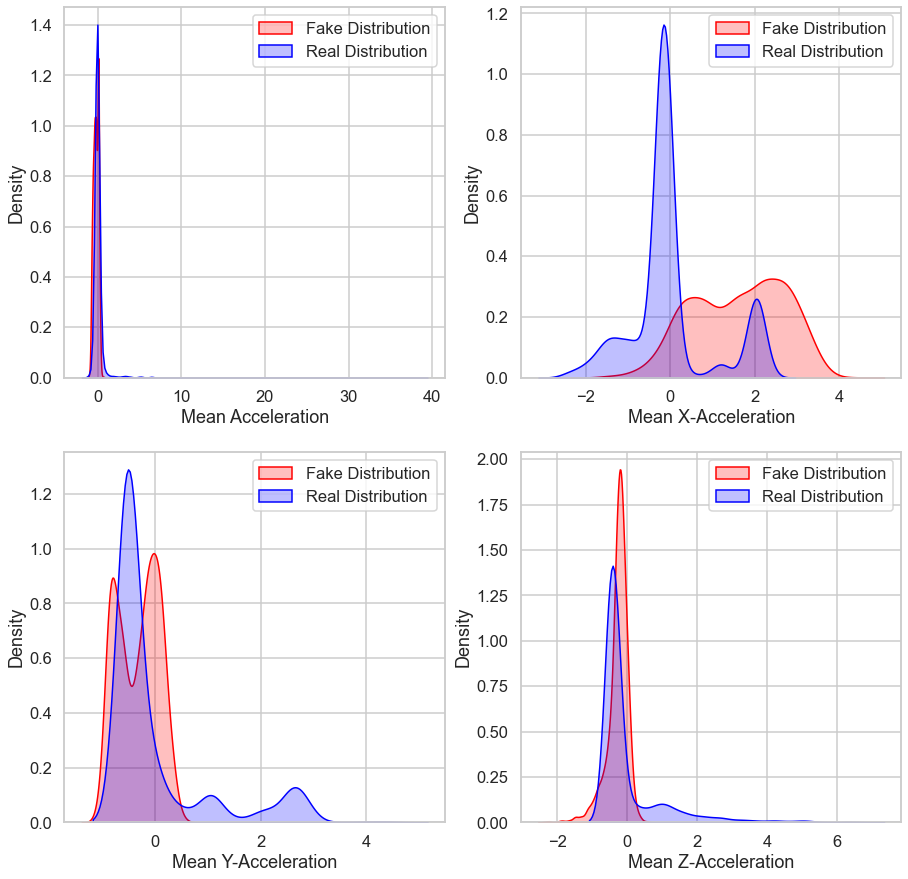

In [15]:
#Number of datum to visualize
sample_size = len(X)
reals = X[0:sample_size, :]
fakes = get_fake_samples(gen, sample_size, z_dim).detach()
density_curves(reals, fakes)

In [16]:
model_output = pd.read_csv('../model_outputs/Test Gan.csv')
model_output.head()

def plot_metrics(data, vanilla = True):
    if vanilla:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
    
        plt.figure(figsize = (15, 15))
        subplot(2, 2, 1)
        sns.scatterplot(x = 'Epoch', y = 'FPR', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 2)
        sns.scatterplot(x = 'Epoch', y = 'Recall', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 3)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 4)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        plt.show()
    else:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
        plt.figure(figsize = (15, 8))
        
        subplot(1, 2, 1)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(1, 2, 2)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        plt.show()

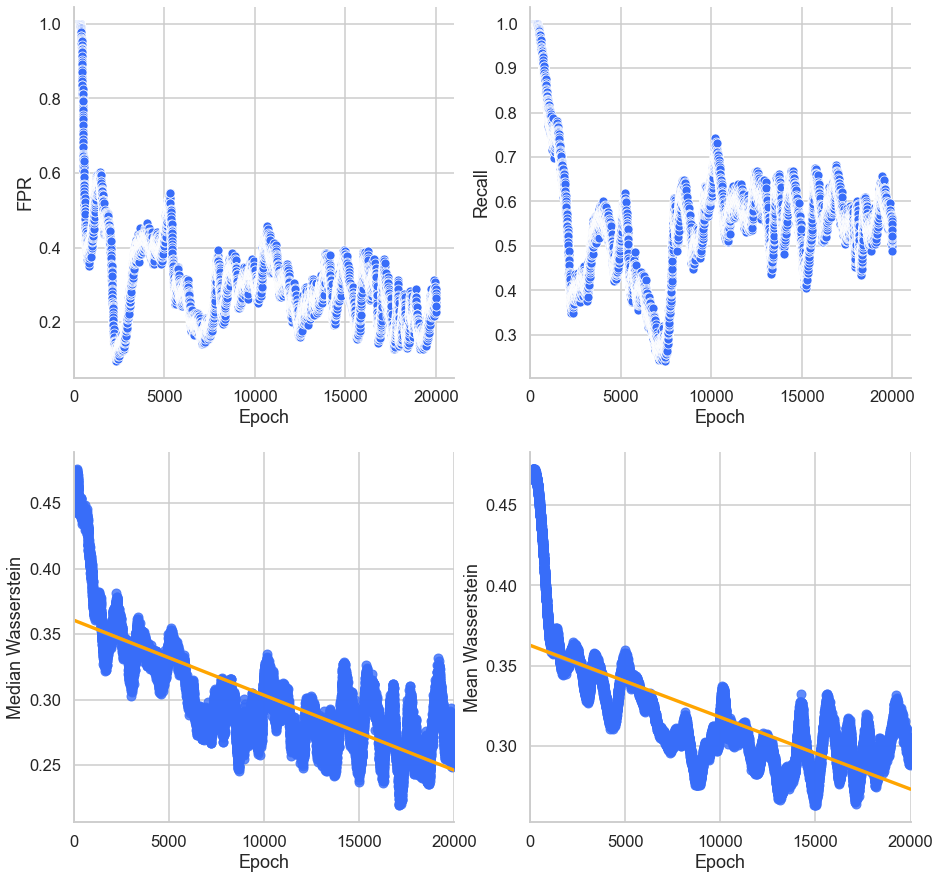

In [17]:
plot_metrics(model_output, True)

# Real/Fake Train Evaluation Metric

In [ ]:
def generate_fake_real_dataset(gen, data, scaler):
    data = interpolation(data) #Interpolates entire dataframe
    not_sitting = data[data['label:SITTING'] == 0] #Only selects rows where sitting is 0
    real_features = not_sitting.iloc[:,1:27] #Selects only acceleration columns
    
    real_features = real_features.values #Converting to a numpy array
    real_features = scaler.transform(real_features) # These are all the scaled acceleration features for non-sitting real data
    real_features_size = real_features.shape[0] #Number of real samples
    y_label_notsitting = [0] * real_features_size #0 corresponds to the non-sitting class
    y_label_notsitting = np.asarray(y_label_notsitting).reshape(-1, 1) #Reshaping into a 2D column vector
    
    #Generating fake acceleration features for sitting data
    latent_vectors = get_noise(real_features_size, z_dim) #Generate the same number of fake sitting samples as real non-sitting samples
    fake_features = gen(latent_vectors).detach().numpy() #Generator already creates scaled features, so no scaling necessary
    y_label_sitting = [1] * real_features_size
    y_label_sitting = np.asarray(y_label_sitting).reshape(-1, 1)
    
    #Concatenating fake/real features and labels
    all_features = np.concatenate((real_features, fake_features), axis = 0) #Vertical concatenation
    all_labels = np.concatenate((y_label_notsitting, y_label_sitting), axis = 0).flatten() #Flatten 2D vector into 1D array for LogisticRegression
    
    #Splitting into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size = 0.2, shuffle = True)
    return X_train, y_train, X_test, y_test

def generate_real_dataset(data, scaler):
    data = interpolation(data) #Interpolating the entire dataframe
    features = data.iloc[:,1:27] #Selecting only acceleration columns
    features = features.values #Converting to a numpy array
    features = scaler.transform(features) #Scaling all rows in the dataframe
    labels = data['label:SITTING'].values
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, shuffle = True)
    return X_train, y_train, X_test, y_test

def train_test_real_fake(X_train, y_train, X_test, y_test):
    classifier = LogisticRegression(penalty = 'l2', C = 0.8)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    f1 = classifier_performance(y_pred, y_test)
    return f1

def train_test_real(X_train, y_train, X_test, y_test): 
    classifier = LogisticRegression(penalty = 'l2', C = 0.8)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    f1 = classifier_performance(y_pred, y_test)
    return f1

def classifier_performance(y_pred, y_test):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for k in range(len(y_pred)):
        #True positive
        if y_test[k] == 1 and y_pred[k] == 1:
            tp += 1
        #False Negative
        elif y_test[k] == 1 and y_pred[k] == 0:
            fn += 1
        #True Negative
        elif y_test[k] == 0 and y_pred[k] == 0:
            tn += 1
        elif y_test[k] == 0 and y_pred[k] == 1:
            fp += 1
        else:
            print("Error")
            exit()
            
    acc = (tp + tn)/(tp + tn + fp + fn)

    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    f1 = 2*(precision * recall / (precision + recall + 0.001))
    
    print(f'Precision: {precision:.3f} Recall: {recall:.3f} F-1 Score: {f1:.3f}')
    
    return acc, f1